# Isopycnal Mixing Water Mass Analysis: Absolute Velocity

In [2]:
# Imports
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import gsw
import cmocean.cm as cmo
import sys
import pyompa
import scipy.interpolate as interp

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data, dist_from_lat_lon

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')



###################################################################################################################
######################################### Setting for water mass analysis #########################################
###################################################################################################################

#Define a parameter to represent remineralization in terms of phosphate
convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[{"oxygen_concentration": -170, "phosphate": 1.0}],
        always_positive=True)
]

paramweightings = {
    "potential_temperature": 1.0,
    "salinity": 1.0,
    "mass": 1.0,
}

settings = {
    "param_names": ["potential_temperature", "salinity", "mass"],
    "convertedparam_groups": convertedparamgroups,
    "param_weightings": paramweightings,
}


## First load glider data

In [103]:
grid_ds_2020 = xr.open_dataset("/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Gridded/RU29_2020_Gridded_ADCP_CTD.nc")
grid_ds_2021a = xr.open_dataset("/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_1_AD2CP_NC/Gridded/RU29_2021_Mission_1_Gridded_ADCP_CTD.nc")
grid_ds_2021b = xr.open_dataset("/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/Gridded/RU29_2021_Mission_2_Gridded_ADCP_CTD.nc")
grid_ds_2022 = xr.open_dataset("/home/jg1200/Data/GliderData/RU36/RU36_03_2022_ADCP/RU36_03_2022_Gridded_ADCP_CTD.nc")

## subset 2022 based on the transects we used in the analysis notebook
grid_ds_2022 = grid_ds_2022.sel(transect_num=[2,3,4,5,6])

## convert density to sigma0
grid_ds_2020.density.values = gsw.sigma0(grid_ds_2020.sal.values,grid_ds_2020.temp.values)+1000
grid_ds_2021a.density.values = gsw.sigma0(grid_ds_2021a.sal.values,grid_ds_2021a.temp.values)+1000
grid_ds_2021b.density.values = gsw.sigma0(grid_ds_2021b.sal.values,grid_ds_2021b.temp.values)+1000
grid_ds_2022.density.values = gsw.sigma0(grid_ds_2022.sal.values,grid_ds_2022.temp.values)+1000

grid_ds_2020

<xarray.Dataset>
Dimensions:       (depth: 98, lat: 6, transect_num: 15)
Coordinates:
  * depth         (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
  * lat           (lat) float64 17.85 17.9 17.95 18.0 18.05 18.1
  * transect_num  (transect_num) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    u             (depth, lat, transect_num) float64 ...
    v             (depth, lat, transect_num) float64 ...
    temp          (depth, lat, transect_num) float64 29.4 29.24 ... nan nan
    sal           (depth, lat, transect_num) float64 34.99 34.91 ... nan nan
    density       (depth, lat, transect_num) float64 1.022e+03 1.022e+03 ... nan
    time          (lat, transect_num) datetime64[ns] ...
Attributes:
    description:  Processed RU29 AD2CP and CTD data from the 2020 Deployment....

## Then load WOA data

In [104]:
temp_ds = xr.open_dataset('https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/temperature/decav/1.00/woa18_decav_t00_01.nc', decode_times=False)
sal_ds  = xr.open_dataset('https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/salinity/decav/1.00/woa18_decav_s00_01.nc', decode_times=False)
temp_ds

<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 4.326e+03
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_an                (time, depth, lat, lon) float32 ...
    t_mn                (time, depth, lat, lon) float32 ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
    t_oa                (time, depth, lat, lon) float32 ...
    t_gp                (time, depth, lat, lon) float64 ...
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-28 
    date_modified:                   2019-07-28

## Subset for NAW/SAW

In [105]:
###################################################################################################################
### Upper NAW ###
min_lon = -60
max_lon = -40
min_lat = 13
max_lat = 17

## subset
naw_temp_ds1 = temp_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=temp_ds.time[0])
naw_sal_ds1  = sal_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=sal_ds.time[0])

## average profile
naw_mean_temp1 = np.nanmax(naw_temp_ds1.t_mn, axis=(1,2))
naw_mean_sal1  = np.nanmax(naw_sal_ds1.s_mn, axis=(1,2))

## convert to SA and PT and calculate sigma0
naw_mean_sal1 = gsw.SA_from_SP(naw_mean_sal1, naw_sal_ds1.depth.values, -40, -30)
naw_mean_temp1 = gsw.pt0_from_t(naw_mean_sal1, naw_mean_temp1, naw_sal_ds1.depth.values)
naw_mean_den1 = gsw.sigma0(naw_mean_sal1,naw_mean_temp1)+1000

## regular depth grid for all so just use this, do this before subsetting naw_mean_den1
mean_depth = naw_sal_ds1.depth.values[np.where((naw_mean_den1>=1024.5) & (naw_mean_den1 <=1027.6))]

## subset by density
naw_den1_ind = np.where((naw_mean_den1>=1024.5) & (naw_mean_den1 <=1026.3))
naw_mean_sal1 = naw_mean_sal1[naw_den1_ind]
naw_mean_temp1 = naw_mean_temp1[naw_den1_ind]
naw_mean_den1 = naw_mean_den1[naw_den1_ind]

###################################################################################################################
### Lower NAW ###
min_lon = -60
max_lon = -40
min_lat = 23
max_lat = 26

## subset
naw_temp_ds2 = temp_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=temp_ds.time[0])
naw_sal_ds2  = sal_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=sal_ds.time[0])

## average profile
naw_mean_temp2 = np.nanmean(naw_temp_ds2.t_mn, axis=(1,2))
naw_mean_sal2  = np.nanmean(naw_sal_ds2.s_mn, axis=(1,2))

## convert to SA and PT and calculate sigma0
naw_mean_sal2 = gsw.SA_from_SP(naw_mean_sal2, naw_sal_ds2.depth.values, -40, -30)
naw_mean_temp2 = gsw.pt0_from_t(naw_mean_sal2, naw_mean_temp2, naw_sal_ds2.depth.values)
naw_mean_den2 = gsw.sigma0(naw_mean_sal2,naw_mean_temp2)+1000

## subset by density
naw_den2_ind = np.where((naw_mean_den2>=1026.3) & (naw_mean_den2 <=1027.6))
naw_mean_sal2 = naw_mean_sal2[naw_den2_ind]
naw_mean_temp2 = naw_mean_temp2[naw_den2_ind]
naw_mean_den2 = naw_mean_den2[naw_den2_ind]

naw_mean_temp = np.concatenate((naw_mean_temp1,naw_mean_temp2))
naw_mean_sal = np.concatenate((naw_mean_sal1,naw_mean_sal2))
naw_mean_den = gsw.sigma0(naw_mean_sal,naw_mean_temp)+1000

###################################################################################################################
###################################################################################################################
### upper SAW ###
min_lon = 0
max_lon = 10
min_lat = -12
max_lat = -8

## subset
saw_temp_ds1 = temp_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=temp_ds.time[0])
saw_sal_ds1  = sal_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=sal_ds.time[0])

## Make average profiles
saw_mean_temp1 = np.nanmean(saw_temp_ds1.t_mn, axis=(1,2))
saw_mean_sal1  = np.nanmean(saw_sal_ds1.s_mn, axis=(1,2))

## convert to SA and PT and calculate sigma0
saw_mean_sal1 = gsw.SA_from_SP(saw_mean_sal1, saw_sal_ds1.depth.values, -40, -30)
saw_mean_temp1 = gsw.pt0_from_t(saw_mean_sal1, saw_mean_temp1, saw_sal_ds1.depth.values)
saw_mean_den1 = gsw.sigma0(saw_mean_sal1,saw_mean_temp1)+1000

## subset by density
saw_den1_ind = np.where((saw_mean_den1>=1024.5) & (saw_mean_den1 <=1026.3))
saw_mean_sal1 = saw_mean_sal1[saw_den1_ind]
saw_mean_temp1 = saw_mean_temp1[saw_den1_ind]
saw_mean_den1 = saw_mean_den1[saw_den1_ind]

###################################################################################################################
### lower SAW ###
min_lon = -32
max_lon = -28
min_lat = -12
max_lat = -8

## subset
saw_temp_ds2 = temp_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=temp_ds.time[0])
saw_sal_ds2  = sal_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=sal_ds.time[0])

## Make average profiles
saw_mean_temp2 = np.nanmean(saw_temp_ds2.t_mn, axis=(1,2))
saw_mean_sal2  = np.nanmean(saw_sal_ds2.s_mn, axis=(1,2))

## convert to SA and PT and calculate sigma0
saw_mean_sal2 = gsw.SA_from_SP(saw_mean_sal2, saw_sal_ds2.depth.values, -40, -30)
saw_mean_temp2 = gsw.pt0_from_t(saw_mean_sal2, saw_mean_temp2, saw_sal_ds2.depth.values)
saw_mean_den2 = gsw.sigma0(saw_mean_sal2,saw_mean_temp2)+1000

## subset by density
saw_den2_ind = np.where((saw_mean_den2>=1026.3) & (saw_mean_den2 <=1027.6))
saw_mean_sal2 = saw_mean_sal2[saw_den2_ind]
saw_mean_temp2 = saw_mean_temp2[saw_den2_ind]
saw_mean_den2 = saw_mean_den2[saw_den2_ind]

saw_mean_temp = np.concatenate((saw_mean_temp1,saw_mean_temp2))
saw_mean_sal = np.concatenate((saw_mean_sal1,saw_mean_sal2))
saw_mean_den = gsw.sigma0(saw_mean_sal,saw_mean_temp)+1000


## Now subset glider data

In [106]:
subset_ds_2020 = grid_ds_2020.where(grid_ds_2020.density >=1024.5)
subset_ds_2021a = grid_ds_2021a.where(grid_ds_2021a.density >=1024.5)
subset_ds_2021b = grid_ds_2021b.where(grid_ds_2021b.density >=1024.5)
subset_ds_2022 = grid_ds_2022.where(grid_ds_2022.density >=1024.5)


## Save a subset copy for the surface layer

In [107]:
subset_ds_2020_surf = grid_ds_2020.where(grid_ds_2020.density <1024.5)
subset_ds_2021a_surf = grid_ds_2021a.where(grid_ds_2021a.density <1024.5)
subset_ds_2021b_surf = grid_ds_2021b.where(grid_ds_2021b.density <1024.5)
subset_ds_2022_surf = grid_ds_2022.where(grid_ds_2022.density <1024.5)


<a list of 8 text.Text objects>

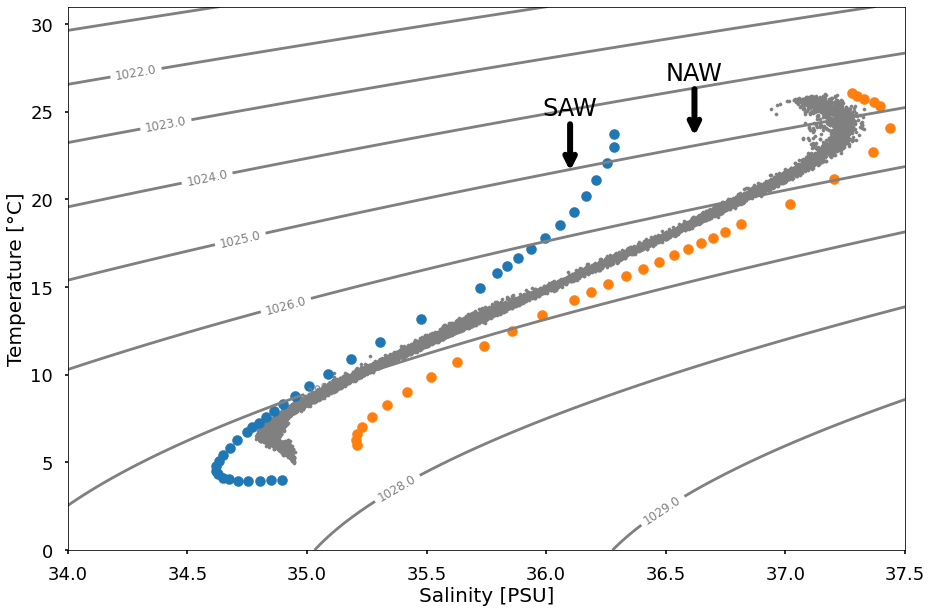

In [108]:
plt.figure(figsize=(15,10))

## markersize
s = 100


plt.scatter(subset_ds_2020.sal.values,subset_ds_2020.temp.values,s=10,c='grey')
plt.scatter(subset_ds_2021a.sal.values,subset_ds_2021a.temp.values,s=10,c='grey')
plt.scatter(subset_ds_2021b.sal.values,subset_ds_2021b.temp.values,s=10,c='grey')
plt.scatter(subset_ds_2022.sal.values,subset_ds_2022.temp.values,s=10,c='grey')



## SAW
plt.scatter(saw_mean_sal,saw_mean_temp,s=s)
plt.annotate(
'SAW', xy=(36.1, 21.5),xytext=(36.1, 24.8) ,
size=24, horizontalalignment="center",
arrowprops=dict(arrowstyle='->',lw=6)
)

## NAW
plt.scatter(naw_mean_sal,naw_mean_temp,s=s)
plt.annotate(
'NAW', xy=(36.62, 23.5),xytext=(36.62, 26.8) ,
size=24, horizontalalignment="center",
arrowprops=dict(arrowstyle='->',lw=6)
)


plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)
plt.ylim(0,31)
plt.xlim(34,37.5)
plt.xlabel('Salinity [PSU]', size=20)
plt.ylabel('Temperature [''\N{DEGREE SIGN}''C]', size=20)

######## This plots the contours
mint=1
maxt=30
mins=34
maxs=37.5
tempL=np.linspace(mint-1,maxt+1,399)
salL=np.linspace(mins-1,maxs+1,399)
Tg, Sg = np.meshgrid(tempL,salL)


z=np.linspace(-1000,0,399)
p = gsw.p_from_z(z,lat=0)
#sigma_theta = gsw.density.rho(Sg, Tg, p)

sigma_theta = gsw.sigma0(Sg, Tg)+1000

#sigma_theta = gsw.sigma0(Sg, Tg)+1000 # ignore effects of pressure on density
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),399)
ind = np.argwhere(sigma_theta > 1015.7)
st_short = sigma_theta[ind]
#cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=np.arange(1020, 1030,1), vmin = 1020, vmax = 1030)
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=np.arange(1020, 1037,1), vmin = 1020, vmax = 1037)
levels = cs.levels
manual_locations = [(34.3, 26), (34.4, 25), (34.6,20), (34.75,16), (34.95,12), (35.15,7), (35.4,3), (36.5,2)]
plt.clabel(cs,levels, fontsize=12,inline=True,fmt='%.1f', manual=manual_locations)



## Need to smooth profiles

In [109]:
griddepth = np.arange(5,1001,10)

naw_interp_mean_temp =  interp.griddata(mean_depth,naw_mean_temp,griddepth)
naw_interp_mean_sal =  interp.griddata(mean_depth,naw_mean_sal,griddepth)
naw_interp_mean_den =  interp.griddata(mean_depth,naw_mean_den,griddepth)

saw_interp_mean_temp =  interp.griddata(mean_depth,saw_mean_temp,griddepth)
saw_interp_mean_sal =  interp.griddata(mean_depth,saw_mean_sal,griddepth)
saw_interp_mean_den =  interp.griddata(mean_depth,saw_mean_den,griddepth)


griddepth_2022 = np.arange(10,1001,20)

naw_interp_mean_temp_2022 =  interp.griddata(mean_depth,naw_mean_temp,griddepth_2022)
naw_interp_mean_sal_2022 =  interp.griddata(mean_depth,naw_mean_sal,griddepth_2022)
naw_interp_mean_den_2022 =  interp.griddata(mean_depth,naw_mean_den,griddepth_2022)

saw_interp_mean_temp_2022 =  interp.griddata(mean_depth,saw_mean_temp,griddepth_2022)
saw_interp_mean_sal_2022 =  interp.griddata(mean_depth,saw_mean_sal,griddepth_2022)
saw_interp_mean_den_2022 =  interp.griddata(mean_depth,saw_mean_den,griddepth_2022)




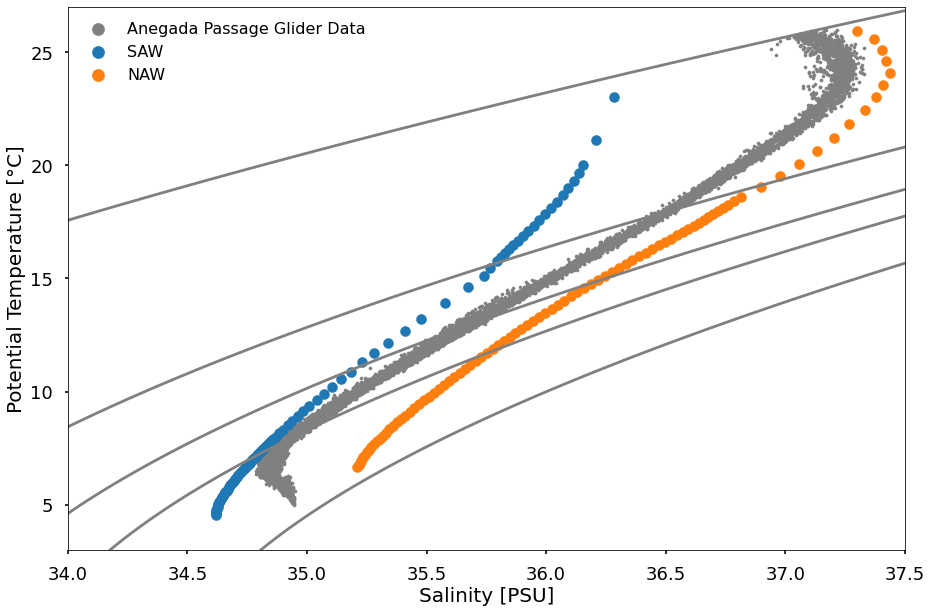

In [110]:
plt.figure(figsize=(15,10))

## markersize
s = 100


plt.scatter(subset_ds_2020.sal.values,subset_ds_2020.temp.values,s=10,c='grey',label='Anegada Passage Glider Data')
plt.scatter(subset_ds_2021a.sal.values,subset_ds_2021a.temp.values,s=10,c='grey')
plt.scatter(subset_ds_2021b.sal.values,subset_ds_2021b.temp.values,s=10,c='grey')
plt.scatter(subset_ds_2022.sal.values,subset_ds_2022.temp.values,s=10,c='grey')



## SAW
plt.scatter(saw_interp_mean_sal,saw_interp_mean_temp,s=s,label='SAW')
## NAW
plt.scatter(naw_interp_mean_sal,naw_interp_mean_temp,s=s,label='NAW')


plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)
plt.ylim(3,27)
plt.xlim(34,37.5)
plt.xlabel('Salinity [PSU]', size=20)
plt.ylabel('Potential Temperature [''\N{DEGREE SIGN}''C]', size=20)
lgnd = plt.legend(frameon=False)
for handle in lgnd.legendHandles:
    handle.set_sizes([150])

######## This plots the contours
mint=1
maxt=30
mins=34
maxs=37.5
tempL=np.linspace(mint-1,maxt+1,399)
salL=np.linspace(mins-1,maxs+1,399)
Tg, Sg = np.meshgrid(tempL,salL)

z=np.linspace(-1000,0,399)
p = gsw.p_from_z(z,lat=0)

sigma_theta = gsw.sigma0(Sg, Tg)+1000

#sigma_theta = gsw.sigma0(Sg, Tg)+1000 # ignore effects of pressure on density
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),399)
ind = np.argwhere(sigma_theta > 1015.7)
st_short = sigma_theta[ind]
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
levels = cs.levels
#manual_locations = [(34.3, 26), (34.4, 25), (34.6,20), (34.75,16), (34.95,12), (35.15,7), (35.4,3), (36.5,2)]
#plt.clabel(cs,levels, fontsize=12,inline=True,fmt='%.1f', manual=manual_locations)



## Save end memebers!

In [111]:
d = {'depth': griddepth, 'naw_temp':naw_interp_mean_temp, 'naw_sal': naw_interp_mean_sal,
     'naw_den': naw_interp_mean_den, 'saw_temp': saw_interp_mean_temp, 'saw_sal': saw_interp_mean_sal, 'saw_den':saw_interp_mean_den}

df = pd.DataFrame(data=d)

df.to_csv('/home/jg1200/Data/naw_saw_endmember_t_s_d_profile.csv')



d = {'depth': griddepth_2022, 'naw_temp':naw_interp_mean_temp_2022, 'naw_sal': naw_interp_mean_sal_2022,
     'naw_den': naw_interp_mean_den_2022, 'saw_temp': saw_interp_mean_temp_2022, 'saw_sal': saw_interp_mean_sal_2022, 'saw_den':saw_interp_mean_den_2022}

df = pd.DataFrame(data=d)

df.to_csv('/home/jg1200/Data/naw_saw_endmember_t_s_d_profile_2022_grid.csv')





In [112]:
## initialize
NAW =       ["NAW",   np.nan,   np.nan]
SAW =       ["SAW",   np.nan,  np.nan]


def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "potential_temperature", "salinity"])
    df["mass"] = 1
    return df

endmemberdf = prepare_endmember_df([NAW, SAW])
endmemberdf

endmember_name  potential_temperature  salinity  mass
0            NAW                    NaN       NaN     1
1            SAW                    NaN       NaN     1

In [113]:

def solve_endmember_fractions_single(df,naw_interp_mean_temp,naw_interp_mean_sal,saw_interp_mean_temp,saw_interp_mean_sal,griddepth):
    
    ## preallocation soln matrix
    naw_frac_df = np.empty(df.temp.shape)
    naw_frac_df[:] = np.nan
    saw_frac_df = np.empty(df.temp.shape)
    saw_frac_df[:] = np.nan

    ## Loop through each row (depth) and perform water mass analysis
    for x in np.arange(0,len(df.depth)):
        
        ## subset to just the depth row of interest and make pandas dataframe
        d = {'potential_temperature': df.temp.values[x,:], 'salinity': df.sal.values[x,:]}
        obs_df = pd.DataFrame(data=d)
        obs_df["mass"] = 1.0

        ## see how many nans there are
        nanlocs = np.where(np.isnan(obs_df['potential_temperature'])==True)[0]
        
        ## skip row if it is all nans
        if len(nanlocs) == len(df.dist):
            pass
        else:
            ## Save location of non-nan indexes for filling sol'n matrix
            nonnanlocs = np.where(np.isnan(obs_df['potential_temperature'])==False)[0]
            ## find matching depth index in source water depth variable
            depth_ind = np.where(griddepth == df.depth.values[x])
            ## oull out NAW and SAW temp and sal
            endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
            endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
            endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
            endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
            ## run analysis
            ompa_soln = pyompa.OMPAProblem(obs_df = obs_df, **settings).solve(endmemberdf,endmember_name_column = "endmember_name")
            ## save soln'n
            naw_frac_df[x,nonnanlocs] = ompa_soln.endmember_fractions[:,0]
            saw_frac_df[x,nonnanlocs] = ompa_soln.endmember_fractions[:,1]
            
    df["naw_frac"]=(['depth', 'dist'],  naw_frac_df)
    df["saw_frac"]=(['depth', 'dist'],  saw_frac_df)

    ############ Now calculate transport!!!!!
    ## preallocate for loop
    transport = np.empty(df.cross_vel.shape)
    transport[:] = np.NaN
    ## calc dz based on depth data
    dz = df.depth.values[1]-df.depth.values[0]
    
    ## loop through and calculate transport in Sv based on dz and dx (dist)
    for x in np.arange(0,len(df.dist)):
        transport[:,x] = (df.cross_vel[:,x].values*dz*df.dist.values[x])/(10**6)
    
    ## now multiply by %naw oand %saw to calculate transport of naw and saw
    naw_transport = transport*naw_frac_df
    saw_transport = transport*saw_frac_df
    
    df["transport"]=(['depth', 'dist'],  transport)
    df["naw_transport"]=(['depth', 'dist'],  naw_transport)
    df["saw_transport"]=(['depth', 'dist'],  saw_transport)
    
    return df


def calc_transport_single(df):
    ############ Now calculate transport!!!!!
    ## preallocate for loop
    transport = np.empty(df.cross_vel.shape)
    transport[:] = np.NaN
    ## calc dz based on depth data
    dz = df.depth.values[1]-df.depth.values[0]
    
    ## loop through and calculate transport in Sv based on dz and dx (dist)
    for x in np.arange(0,len(df.dist)):
        transport[:,x] = (df.cross_vel[:,x].values*dz*df.dist.values[x])/(10**6)

    df["transport"]=(['depth', 'dist'],  transport)

    return df


In [114]:
subset_ds_2021a_surf_final = calc_transport_single(subset_ds_2021a_surf)
subset_ds_2021b_surf_final = calc_transport_single(subset_ds_2021b_surf)

In [115]:
df_2021a_final = solve_endmember_fractions_single(subset_ds_2021a,naw_interp_mean_temp,naw_interp_mean_sal,saw_interp_mean_temp,saw_interp_mean_sal,griddepth)


Dropping 34 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 5 out of 5
status: optimal
optimal value 0.09105951334633017
Original weighted sum squares: 0.09105951334633017
Post fix weighted sum squared: 0.09105951334632893
On example 0 to 5 out of 5
status: optimal
optimal value 0.09105951334633017
Original weighted sum squares: 0.09105951334633017
Post fix weighted sum squared: 0.09105951334632893
objective: 0.09105951334632892
Dropping 19 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 20 out of 20
status: optimal
optimal value 1.6792313911

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 16.466752099925078
Original weighted sum squares: 16.466752099925078
Post fix weighted sum squared: 16.466752099925078
On example 0 to 39 out of 39
status: optimal
optimal value 16.46675209992508
Original weighted sum squares: 16.46675209992508
Post fix weighted sum squared: 16.466752099925078
objective: 16.466752099925078
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 15.340583251162018
Original weighted sum squares: 15.340583251162018
Post fix weighted sum squared: 15.340583251161984
On example 0 to 39 out of 39
status: optimal
optimal value 15.340583251162018
Original weighted sum squares: 15.340583251162018
Post fix weighted sum squared: 15.340583251161984
objective: 15.340583251161982
Endmember-idx mapping is
 OrderedDict([('NAW',

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 29.090541569534174
Original weighted sum squares: 29.090541569534174
Post fix weighted sum squared: 29.090541569534167
On example 0 to 39 out of 39
status: optimal
optimal value 29.090541569534174
Original weighted sum squares: 29.090541569534174
Post fix weighted sum squared: 29.090541569534167
objective: 29.09054156953417
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 26.83109833805024
Original weighted sum squares: 26.83109833805024
Post fix weighted sum squared: 26.831098338050126
On example 0 to 39 out of 39
status: optimal
optimal value 26.83109833805024
Original weighted sum squares: 26.83109833805024
Post fix weighted sum squared: 26.831098338050126
objective: 26.83109833805012
Endmember-idx mapping is
 OrderedDict([('NAW', [0]

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 6.439112146984323
Original weighted sum squares: 6.439112146984323
Post fix weighted sum squared: 6.439112146984307
On example 0 to 39 out of 39
status: optimal
optimal value 6.439112146984323
Original weighted sum squares: 6.439112146984323
Post fix weighted sum squared: 6.439112146984307
objective: 6.439112146984308
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 3.2486676014359324
Original weighted sum squares: 3.2486676014359324
Post fix weighted sum squared: 3.2486676014359226
On example 0 to 39 out of 39
status: optimal
optimal value 3.2486676014359324
Original weighted sum squares: 3.2486676014359324
Post fix weighted sum squared: 3.2486676014359226
objective: 3.2486676014359217
Endmember-idx mapping is
 OrderedDict([('NAW', [0])

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.5553184526540422
Original weighted sum squares: 0.5553184526540422
Post fix weighted sum squared: 0.5553184526540248
On example 0 to 39 out of 39
status: optimal
optimal value 0.5553184526540422
Original weighted sum squares: 0.5553184526540422
Post fix weighted sum squared: 0.5553184526540248
objective: 0.5553184526540249
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 0.5454958979924813
Original weighted sum squares: 0.5454958979924813
Post fix weighted sum squared: 0.545495897992432
On example 0 to 39 out of 39
status: optimal
optimal value 0.5454958979924813
Original weighted sum squares: 0.5454958979924813
Post fix weighted sum squared: 0.545495897992432
objective: 0.545495897992432
Endmember-idx mapping is
 OrderedDict([('NAW', 

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.5483882410605937
Original weighted sum squares: 0.5483882410605937
Post fix weighted sum squared: 0.5483882410606241
On example 0 to 39 out of 39
status: optimal
optimal value 0.5483882410605937
Original weighted sum squares: 0.5483882410605937
Post fix weighted sum squared: 0.5483882410606241
objective: 0.548388241060624
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 0.5797891768248765
Original weighted sum squares: 0.5797891768248765
Post fix weighted sum squared: 0.5797891768248894
On example 0 to 39 out of 39
status: optimal
optimal value 0.5797891768248765
Original weighted sum squares: 0.5797891768248765
Post fix weighted sum squared: 0.5797891768248894
objective: 0.5797891768248894
Endmember-idx mapping is
 OrderedDict([('NAW'

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.6664425925596295
Original weighted sum squares: 0.6664425925596295
Post fix weighted sum squared: 0.6664425925595984
On example 0 to 39 out of 39
status: optimal
optimal value 0.6664425925596295
Original weighted sum squares: 0.6664425925596295
Post fix weighted sum squared: 0.6664425925595984
objective: 0.6664425925595981
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 0.6473998188921606
Original weighted sum squares: 0.6473998188921606
Post fix weighted sum squared: 0.647399818892167
On example 0 to 39 out of 39
status: optimal
optimal value 0.6473998188921606
Original weighted sum squares: 0.6473998188921606
Post fix weighted sum squared: 0.647399818892167
objective: 0.647399818892167
Endmember-idx mapping is
 OrderedDict([('NAW', 

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.6405084889366398
Original weighted sum squares: 0.6405084889366398
Post fix weighted sum squared: 0.6405084889366135
On example 0 to 39 out of 39
status: optimal
optimal value 0.6405084889366398
Original weighted sum squares: 0.6405084889366398
Post fix weighted sum squared: 0.6405084889366135
objective: 0.6405084889366134
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 0.6091999891314556
Original weighted sum squares: 0.6091999891314556
Post fix weighted sum squared: 0.6091999891314408
On example 0 to 39 out of 39
status: optimal
optimal value 0.6091999891314556
Original weighted sum squares: 0.6091999891314556
Post fix weighted sum squared: 0.6091999891314408
objective: 0.6091999891314406
Endmember-idx mapping is
 OrderedDict([('NAW

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.5412256828542644
Original weighted sum squares: 0.5412256828542644
Post fix weighted sum squared: 0.5412256828542737
On example 0 to 39 out of 39
status: optimal
optimal value 0.5412256828542644
Original weighted sum squares: 0.5412256828542644
Post fix weighted sum squared: 0.5412256828542737
objective: 0.5412256828542739
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 38 out of 38
status: optimal
optimal value 0.5216124122713246
Original weighted sum squares: 0.5216124122713246
Post fix weighted sum squared: 0.5216124122712706
On example 0 to 38 out of 38
status: optimal
optimal value 0.5216124122713246
Original weighted sum squares: 0.5216124122713246
Post fix weighted sum squared: 0.5216124122712706
objective: 0.52161

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.39485698919670087
Original weighted sum squares: 0.39485698919670087
Post fix weighted sum squared: 0.3948569891968066
On example 0 to 37 out of 37
status: optimal
optimal value 0.39485698919670087
Original weighted sum squares: 0.39485698919670087
Post fix weighted sum squared: 0.3948569891968066
objective: 0.39485698919680645
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 37 out of 37
status: optimal
optimal value 0.3897608700768289
Original weighted sum squares: 0.3897608700768289
Post fix weighted sum squared: 0.38976087007685645
On example 0 to 37 out of 37
status: optimal
optimal value 0.3897608700768289
Original weighted sum squares: 0.3897608700768289
Post fix weighted sum squared: 0.38976087007685645
objective: 

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.22342096769285913
Original weighted sum squares: 0.22342096769285913
Post fix weighted sum squared: 0.22342096769290704
On example 0 to 36 out of 36
status: optimal
optimal value 0.22342096769285913
Original weighted sum squares: 0.22342096769285913
Post fix weighted sum squared: 0.22342096769290704
objective: 0.22342096769290704
Dropping 5 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 34 out of 34
status: optimal
optimal value 0.16656780092838946
Original weighted sum squares: 0.16656780092838946
Post fix weighted sum squared: 0.1665678009284244
On example 0 to 34 out of 34
status: optimal
optimal value 0.16656780092838946
Original weighted sum squares: 0.16656780092838946
Post fix weighted sum squared: 0.1665678009284244
objecti

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.0935384465815053
Original weighted sum squares: 0.0935384465815053
Post fix weighted sum squared: 0.0935384465814752
On example 0 to 34 out of 34
status: optimal
optimal value 0.0935384465815053
Original weighted sum squares: 0.0935384465815053
Post fix weighted sum squared: 0.0935384465814752
objective: 0.09353844658147518
Dropping 6 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 33 out of 33
status: optimal
optimal value 0.09009749388995851
Original weighted sum squares: 0.09009749388995851
Post fix weighted sum squared: 0.09009749388993553
On example 0 to 33 out of 33
status: optimal
optimal value 0.09009749388995851
Original weighted sum squares: 0.09009749388995851
Post fix weighted sum squared: 0.09009749388993553
objective: 

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.04205026987859237
Original weighted sum squares: 0.04205026987859237
Post fix weighted sum squared: 0.04205026987859877
On example 0 to 31 out of 31
status: optimal
optimal value 0.04205026987859237
Original weighted sum squares: 0.04205026987859237
Post fix weighted sum squared: 0.04205026987859877
objective: 0.04205026987859876
Dropping 8 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.03797387976801744
Original weighted sum squares: 0.03797387976801744
Post fix weighted sum squared: 0.037973879768029135
On example 0 to 31 out of 31
status: optimal
optimal value 0.03797387976801744
Original weighted sum squares: 0.03797387976801744
Post fix weighted sum squared: 0.037973879768029135
obj

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.024007825870890096
Original weighted sum squares: 0.024007825870890096
Post fix weighted sum squared: 0.02400782587088452
On example 0 to 29 out of 29
status: optimal
optimal value 0.024007825870890096
Original weighted sum squares: 0.024007825870890096
Post fix weighted sum squared: 0.02400782587088452
objective: 0.02400782587088452
Dropping 10 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 29 out of 29
status: optimal
optimal value 0.020929426048934524
Original weighted sum squares: 0.020929426048934524
Post fix weighted sum squared: 0.02092942604893507
On example 0 to 29 out of 29
status: optimal
optimal value 0.020929426048934524
Original weighted sum squares: 0.020929426048934524
Post fix weighted sum squared: 0.02092942604893

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.024920476573330786
Original weighted sum squares: 0.024920476573330786
Post fix weighted sum squared: 0.024920476573339005
On example 0 to 26 out of 26
status: optimal
optimal value 0.024920476573330786
Original weighted sum squares: 0.024920476573330786
Post fix weighted sum squared: 0.024920476573339005
objective: 0.024920476573339005
Dropping 13 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 26 out of 26
status: optimal
optimal value 0.023376633209656203
Original weighted sum squares: 0.023376633209656203
Post fix weighted sum squared: 0.023376633209658694
On example 0 to 26 out of 26
status: optimal
optimal value 0.023376633209656203
Original weighted sum squares: 0.023376633209656203
Post fix weighted sum squared: 0.0233766332

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

In [116]:
df_2021a_final

<xarray.Dataset>
Dimensions:        (depth: 98, dist: 39)
Coordinates:
  * depth          (depth) float64 5.0 15.0 25.0 35.0 ... 955.0 965.0 975.0
  * dist           (dist) float64 2.909e+03 3.465e+03 ... 2.001e+03 1.936e+03
Data variables:
    vgeo           (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    cross_vel      (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    along_vel      (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    temp           (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    sal            (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    density        (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    naw_frac       (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    saw_frac       (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    transport      (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    naw_transport  (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    saw_transport  (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Processed RU29 AD2CP velocity, geostrophic velocity, and CT...

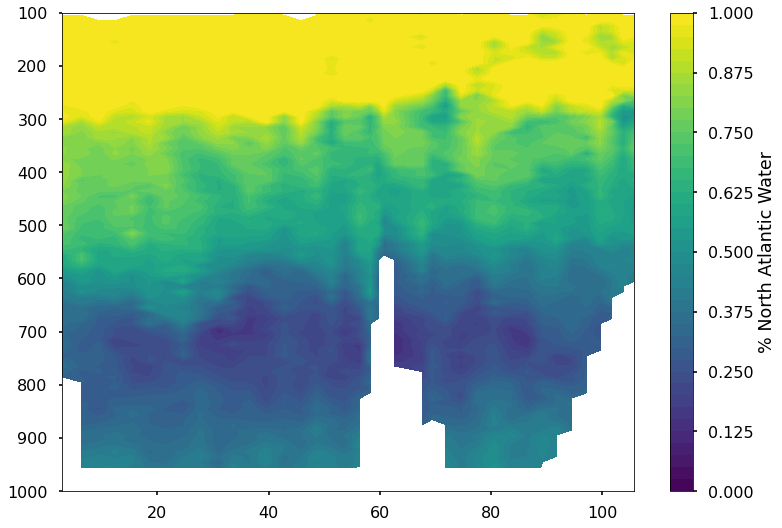

In [117]:
plt.contourf(np.cumsum(df_2021a_final.dist)/1000,df_2021a_final.depth,df_2021a_final.naw_frac,levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% North Atlantic Water')

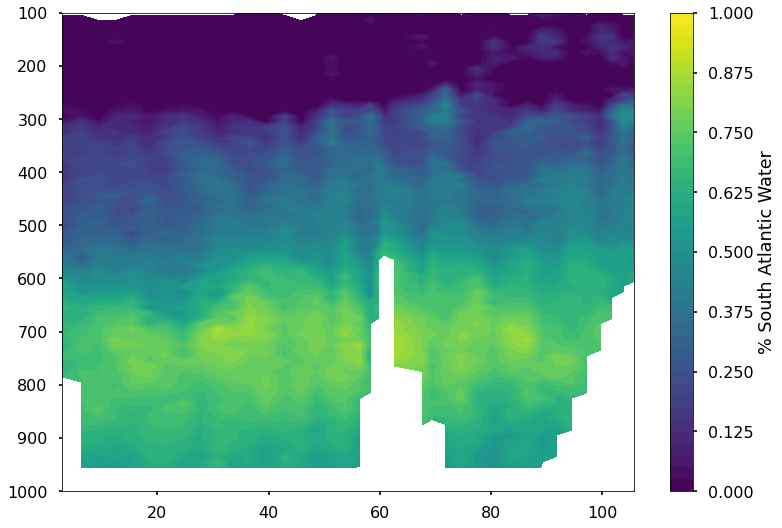

In [118]:
plt.contourf(np.cumsum(df_2021a_final.dist)/1000,df_2021a_final.depth,df_2021a_final.saw_frac,levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% South Atlantic Water')

In [119]:
df_2021b_final = solve_endmember_fractions_single(subset_ds_2021b,naw_interp_mean_temp,naw_interp_mean_sal,saw_interp_mean_temp,saw_interp_mean_sal,griddepth)


Dropping 25 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 9 out of 9
status: optimal
optimal value 1.0610895293090645
Original weighted sum squares: 1.0610895293090645
Post fix weighted sum squared: 1.061089529309065
On example 0 to 9 out of 9
status: optimal
optimal value 1.0610895293090645
Original weighted sum squares: 1.0610895293090645
Post fix weighted sum squared: 1.061089529309065
objective: 1.061089529309065
Dropping 10 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 24 out of 24
status: optimal
optimal value 9.134899463860922
Orig

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 18.873656423538037
Original weighted sum squares: 18.873656423538037
Post fix weighted sum squared: 18.873656423537962
objective: 18.873656423537966
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 19.915567548943486
Original weighted sum squares: 19.915567548943486
Post fix weighted sum squared: 19.915567548943372
On example 0 to 31 out of 31
status: optimal
optimal value 19.915567548943486
Original weighted sum squares: 19.915567548943486
Post fix weighted sum squared: 19.915567548943372
objective: 19.915567548943375
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', '

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 20.028136672140505
Original weighted sum squares: 20.028136672140505
Post fix weighted sum squared: 20.028136672140405
On example 0 to 31 out of 31
status: optimal
optimal value 20.028136672140505
Original weighted sum squares: 20.028136672140505
Post fix weighted sum squared: 20.028136672140405
objective: 20.028136672140405
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 14.64564133561424
Original weighted sum squares: 14.64564133561424
Post fix weighted sum squared: 14.645641335614226
On example 0 to 31 out of 31
status: optimal
optimal value 14.64564133561424
Original weighted sum squares: 14.64564133561424
Post fix weighted sum squared: 14.645641335614226
objective: 14.64564133

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 1.4127074603683079
Original weighted sum squares: 1.4127074603683079
Post fix weighted sum squared: 1.4127074603682734
On example 0 to 31 out of 31
status: optimal
optimal value 1.4127074603683079
Original weighted sum squares: 1.4127074603683079
Post fix weighted sum squared: 1.4127074603682734
objective: 1.4127074603682734
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.8121283384347927
Original weighted sum squares: 0.8121283384347927
Post fix weighted sum squared: 0.8121283384347737
On example 0 to 31 out of 31
status: optimal
optimal value 0.8121283384347927
Original weighted sum squares: 0.8121283384347927
Post fix weighted sum squared: 0.8121283384347737
objective: 0.81212

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.2287953863192765
Original weighted sum squares: 0.2287953863192765
Post fix weighted sum squared: 0.2287953863192541
On example 0 to 31 out of 31
status: optimal
optimal value 0.2287953863192765
Original weighted sum squares: 0.2287953863192765
Post fix weighted sum squared: 0.2287953863192541
objective: 0.22879538631925414
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.23788457678390262
Original weighted sum squares: 0.23788457678390262
Post fix weighted sum squared: 0.23788457678388805
On example 0 to 31 out of 31
status: optimal
optimal value 0.23788457678390262
Original weighted sum squares: 0.23788457678390262
Post fix weighted sum squared: 0.23788457678388805
objective: 

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.22146514196303643
Original weighted sum squares: 0.22146514196303643
Post fix weighted sum squared: 0.22146514196304237
On example 0 to 31 out of 31
status: optimal
optimal value 0.22146514196303643
Original weighted sum squares: 0.22146514196303643
Post fix weighted sum squared: 0.22146514196304237
objective: 0.2214651419630424
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.24803516537301318
Original weighted sum squares: 0.24803516537301318
Post fix weighted sum squared: 0.24803516537305337
On example 0 to 31 out of 31
status: optimal
optimal value 0.24803516537301318
Original weighted sum squares: 0.24803516537301318
Post fix weighted sum squared: 0.24803516537305337
object

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.3298034615929402
Original weighted sum squares: 0.3298034615929402
Post fix weighted sum squared: 0.3298034615929509
On example 0 to 31 out of 31
status: optimal
optimal value 0.3298034615929402
Original weighted sum squares: 0.3298034615929402
Post fix weighted sum squared: 0.3298034615929509
objective: 0.329803461592951
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.36623906678145784
Original weighted sum squares: 0.36623906678145784
Post fix weighted sum squared: 0.3662390667814302
On example 0 to 31 out of 31
status: optimal
optimal value 0.36623906678145784
Original weighted sum squares: 0.36623906678145784
Post fix weighted sum squared: 0.3662390667814302
objective: 0.36

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.45311132933063253
Original weighted sum squares: 0.45311132933063253
Post fix weighted sum squared: 0.4531113293306273
On example 0 to 31 out of 31
status: optimal
optimal value 0.45311132933063253
Original weighted sum squares: 0.45311132933063253
Post fix weighted sum squared: 0.4531113293306273
objective: 0.4531113293306273
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.4334741420876956
Original weighted sum squares: 0.4334741420876956
Post fix weighted sum squared: 0.43347414208768187
On example 0 to 31 out of 31
status: optimal
optimal value 0.4334741420876956
Original weighted sum squares: 0.4334741420876956
Post fix weighted sum squared: 0.43347414208768187
objective: 0

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.4100623741643714
Original weighted sum squares: 0.4100623741643714
Post fix weighted sum squared: 0.41006237416432684
On example 0 to 31 out of 31
status: optimal
optimal value 0.4100623741643714
Original weighted sum squares: 0.4100623741643714
Post fix weighted sum squared: 0.41006237416432684
objective: 0.41006237416432684
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.36853201616546344
Original weighted sum squares: 0.36853201616546344
Post fix weighted sum squared: 0.36853201616546616
On example 0 to 31 out of 31
status: optimal
optimal value 0.36853201616546344
Original weighted sum squares: 0.36853201616546344
Post fix weighted sum squared: 0.36853201616546616
objective

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.2588700719889678
Original weighted sum squares: 0.2588700719889678
Post fix weighted sum squared: 0.25887007198898226
On example 0 to 31 out of 31
status: optimal
optimal value 0.2588700719889678
Original weighted sum squares: 0.2588700719889678
Post fix weighted sum squared: 0.25887007198898226
objective: 0.25887007198898226
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.23138724810065955
Original weighted sum squares: 0.23138724810065955
Post fix weighted sum squared: 0.2313872481006371
On example 0 to 31 out of 31
status: optimal
optimal value 0.23138724810065955
Original weighted sum squares: 0.23138724810065955
Post fix weighted sum squared: 0.2313872481006371
objective: 

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.13072190440228912
Original weighted sum squares: 0.13072190440228912
Post fix weighted sum squared: 0.13072190440231216
On example 0 to 31 out of 31
status: optimal
optimal value 0.13072190440228912
Original weighted sum squares: 0.13072190440228912
Post fix weighted sum squared: 0.13072190440231216
objective: 0.13072190440231216
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.10399816165629788
Original weighted sum squares: 0.10399816165629788
Post fix weighted sum squared: 0.10399816165629089
On example 0 to 31 out of 31
status: optimal
optimal value 0.10399816165629788
Original weighted sum squares: 0.10399816165629788
Post fix weighted sum squared: 0.10399816165629089
objec

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.040493711023877624
Original weighted sum squares: 0.040493711023877624
Post fix weighted sum squared: 0.04049371102385728
On example 0 to 31 out of 31
status: optimal
optimal value 0.040493711023877624
Original weighted sum squares: 0.040493711023877624
Post fix weighted sum squared: 0.04049371102385728
objective: 0.040493711023857286
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.036380622691173016
Original weighted sum squares: 0.036380622691173016
Post fix weighted sum squared: 0.03638062269116734
On example 0 to 31 out of 31
status: optimal
optimal value 0.036380622691173016
Original weighted sum squares: 0.036380622691173016
Post fix weighted sum squared: 0.03638062269116

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.024283670955380966
Original weighted sum squares: 0.024283670955380966
Post fix weighted sum squared: 0.024283670955384393
On example 0 to 31 out of 31
status: optimal
optimal value 0.024283670955380966
Original weighted sum squares: 0.024283670955380966
Post fix weighted sum squared: 0.024283670955384393
objective: 0.02428367095538439
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.018193159751378012
Original weighted sum squares: 0.018193159751378012
Post fix weighted sum squared: 0.018193159751378918
On example 0 to 31 out of 31
status: optimal
optimal value 0.018193159751378012
Original weighted sum squares: 0.018193159751378012
Post fix weighted sum squared: 0.018193159751

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.047877009008375195
Original weighted sum squares: 0.047877009008375195
Post fix weighted sum squared: 0.04787700900837786
On example 0 to 31 out of 31
status: optimal
optimal value 0.047877009008375195
Original weighted sum squares: 0.047877009008375195
Post fix weighted sum squared: 0.04787700900837786
objective: 0.047877009008377866
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.04763137331757169
Original weighted sum squares: 0.04763137331757169
Post fix weighted sum squared: 0.04763137331759798
On example 0 to 31 out of 31
status: optimal
optimal value 0.04763137331757169
Original weighted sum squares: 0.04763137331757169
Post fix weighted sum squared: 0.04763137331759798


/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.13901006865745616
Original weighted sum squares: 0.13901006865745616
Post fix weighted sum squared: 0.1390100686574764
On example 0 to 31 out of 31
status: optimal
optimal value 0.13901006865745616
Original weighted sum squares: 0.13901006865745616
Post fix weighted sum squared: 0.1390100686574764
objective: 0.1390100686574764
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.1614850727166794
Original weighted sum squares: 0.1614850727166794
Post fix weighted sum squared: 0.1614850727166918
On example 0 to 31 out of 31
status: optimal
optimal value 0.1614850727166794
Original weighted sum squares: 0.1614850727166794
Post fix weighted sum squared: 0.1614850727166918
objective: 0.1

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

status: optimal
optimal value 0.33438449428159267
Original weighted sum squares: 0.33438449428159267
Post fix weighted sum squared: 0.33438449428160644
On example 0 to 31 out of 31
status: optimal
optimal value 0.33438449428159267
Original weighted sum squares: 0.33438449428159267
Post fix weighted sum squared: 0.33438449428160644
objective: 0.3343844942816063
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.36831082940070775
Original weighted sum squares: 0.36831082940070775
Post fix weighted sum squared: 0.36831082940078014
On example 0 to 31 out of 31
status: optimal
optimal value 0.36831082940070775
Original weighted sum squares: 0.36831082940070775
Post fix weighted sum squared: 0.36831082940078014
object

/tmp/ipykernel_243104/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_int

In [120]:
df_2021b_final

<xarray.Dataset>
Dimensions:        (depth: 102, dist: 34)
Coordinates:
  * depth          (depth) float64 5.0 15.0 25.0 ... 995.0 1.005e+03 1.015e+03
  * dist           (dist) float64 2.952e+03 3.352e+03 ... 2.71e+03 2.97e+03
Data variables:
    vgeo           (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    cross_vel      (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    along_vel      (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    temp           (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    sal            (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    density        (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    naw_frac       (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    saw_frac       (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    transport      (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    naw_transport  (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    saw_transport  (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Processed RU29 AD2CP velocity, geostrophic velocity, and CT...

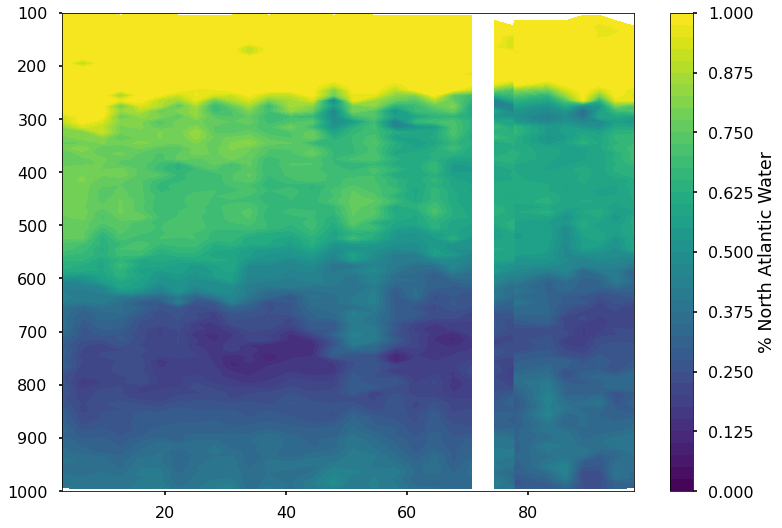

In [121]:
plt.contourf(np.cumsum(df_2021b_final.dist)/1000,df_2021b_final.depth,df_2021b_final.naw_frac,levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% North Atlantic Water')

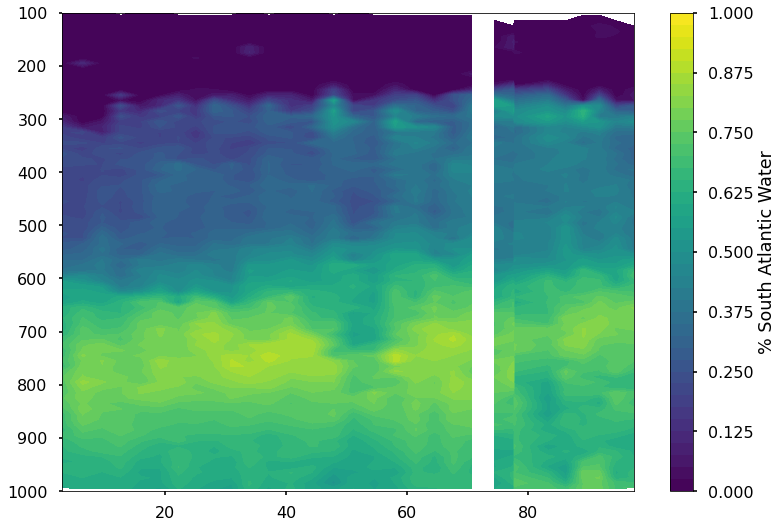

In [122]:
plt.contourf(np.cumsum(df_2021b_final.dist)/1000,df_2021b_final.depth,df_2021b_final.saw_frac,levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% South Atlantic Water')

## 2021a

In [123]:
np.nansum(df_2021a_final.naw_transport)

-2.5182101325101955

In [124]:
np.nansum(df_2021a_final.saw_transport)

-1.4799534007063349

In [125]:
np.nansum(df_2021a_final.transport)

-3.998163533216531

In [126]:
np.nansum(df_2021a_final.naw_transport)/np.nansum(df_2021a_final.transport)

0.6298417039695948

In [127]:
np.nansum(df_2021a_final.saw_transport)/np.nansum(df_2021a_final.transport)

0.37015829603040507

### just surface layer now

In [128]:
np.nansum(df_2021a_final.saw_transport)+np.nansum(subset_ds_2021a_surf_final.transport)

-1.8770831715342706

## total SAW transport now

In [129]:
np.nansum(subset_ds_2021a_surf_final.transport)

-0.39712977082793577

In [130]:
np.nansum(subset_ds_2021a_surf_final.transport)

-0.39712977082793577

In [131]:
np.nansum(subset_ds_2021a_surf_final.transport)/-4.43

0.08964554646228799

## 2021b

In [132]:
np.nansum(df_2021b_final.naw_transport)

-2.8791003053357525

In [133]:
np.nansum(df_2021b_final.saw_transport)

-1.957188479728266

In [134]:
np.nansum(df_2021b_final.transport)

-4.836288785064019

In [135]:
np.nansum(df_2021b_final.naw_transport)/np.nansum(df_2021b_final.transport)

0.5953119082192362

In [136]:
np.nansum(df_2021b_final.saw_transport)/np.nansum(df_2021b_final.transport)

0.4046880917807637

### just surface layer now

In [137]:
np.nansum(df_2021b_final.saw_transport)+np.nansum(subset_ds_2021b_surf_final.transport)

-2.32990682232375

In [138]:
np.nansum(subset_ds_2021b_surf_final.transport)/-5.24

0.0711294546937946

### total SAW now

In [139]:
np.nansum(subset_ds_2021b_surf_final.transport)

-0.37271834259548375

# Now do it for the repeat transects for the 2020 and 2022 deployments

In [140]:

def solve_endmember_fractions_multiple(df,naw_interp_mean_temp,naw_interp_mean_sal,saw_interp_mean_temp,saw_interp_mean_sal,griddepth):

    ## preallocation soln matrix
    naw_frac_df = np.empty(df.temp.shape)
    naw_frac_df[:] = np.nan
    saw_frac_df = np.empty(df.temp.shape)
    saw_frac_df[:] = np.nan

    ## Loop through each transect
    for y in np.arange(0,len(df.transect_num)):

        ## Then loop through each row (depth) and perform water mass analysis
        for x in np.arange(0,len(df.depth)):

            ## subset to just the depth row of interest and make pandas dataframe
            d = {'potential_temperature': df.temp.values[x,:,y], 'salinity': df.sal.values[x,:,y]}
            obs_df = pd.DataFrame(data=d)
            obs_df["mass"] = 1.0

            ## see how many nans there are
            nanlocs = np.where(np.isnan(obs_df['potential_temperature'])==True)[0]

            ## skip row if it is all nans
            if len(nanlocs) == len(df.lat):
                pass
            else:
                ## Save location of non-nan indexes for filling sol'n matrix
                nonnanlocs = np.where(np.isnan(obs_df['potential_temperature'])==False)[0]
                ## find matching depth index in source water depth variable
                depth_ind = np.where(griddepth == df.depth.values[x])
                ## oull out NAW and SAW temp and sal
                endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
                endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
                endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
                endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
                ## run analysis
                ompa_soln = pyompa.OMPAProblem(obs_df = obs_df, **settings).solve(endmemberdf,endmember_name_column = "endmember_name")
                ## save soln'n
                naw_frac_df[x,nonnanlocs,y] = ompa_soln.endmember_fractions[:,0]
                saw_frac_df[x,nonnanlocs,y] = ompa_soln.endmember_fractions[:,1]

    df["naw_frac"]=(['depth', 'lat', 'transect_num'],  naw_frac_df)
    df["saw_frac"]=(['depth', 'lat', 'transect_num'],  saw_frac_df)

    ############ Now calculate transport!!!!!
    ## preallocate for loop
    transport = np.empty(df.temp.shape)
    transport[:] = np.NaN
    ## calc dz based on depth data
    dz = df.depth.values[1]-df.depth.values[0]
    ## lon hard-coded due to grid design
    distance = dist_from_lat_lon(subset_ds_2020.lat[0], -64.80, subset_ds_2020.lat[1], -64.80)

    ## loop through and calculate transport in Sv based on dz and dx (dist)
    for x in np.arange(0,len(df.transect_num)):
        transport[:,:,x] = (df.u[:,:,x].values*dz*distance)/(10**6)

    ## now multiply by %naw oand %saw to calculate transport of naw and saw
    naw_transport = transport*naw_frac_df
    saw_transport = transport*saw_frac_df

    df["transport"]=(['depth', 'lat', 'transect_num'],  transport)
    df["naw_transport"]=(['depth', 'lat', 'transect_num'],  naw_transport)
    df["saw_transport"]=(['depth', 'lat', 'transect_num'],  saw_transport)

    return df







def calc_transport_multiple(df):
    ############ Now calculate transport!!!!!
    ## preallocate for loop
    transport = np.empty(df.temp.shape)
    transport[:] = np.NaN
    ## calc dz based on depth data
    dz = df.depth.values[1]-df.depth.values[0]
    ## lon hard-coded due to grid design
    distance = dist_from_lat_lon(subset_ds_2020.lat[0], -64.80, subset_ds_2020.lat[1], -64.80)

    ## loop through and calculate transport in Sv based on dz and dx (dist)
    for x in np.arange(0,len(df.transect_num)):
        transport[:,:,x] = (df.u[:,:,x].values*dz*distance)/(10**6)

    df["transport"]=(['depth', 'lat', 'transect_num'],  transport)

    return df



In [141]:
subset_ds_2020_surf_final = calc_transport_multiple(subset_ds_2020_surf)
subset_ds_2022_surf_final = calc_transport_multiple(subset_ds_2022_surf)

In [143]:
df_2020_final = solve_endmember_fractions_multiple(subset_ds_2020,naw_interp_mean_temp,naw_interp_mean_sal,saw_interp_mean_temp,saw_interp_mean_sal,griddepth)


Dropping 5 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 1 out of 1
status: optimal
optimal value 0.10061590443975327
Original weighted sum squares: 0.10061590443975327
Post fix weighted sum squared: 0.10061590443975327
On example 0 to 1 out of 1
status: optimal
optimal value 0.10061590443975327
Original weighted sum squares: 0.10061590443975327
Post fix weighted sum squared: 0.10061590443975327
objective: 0.10061590443975327
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.3185905204130868
Original weighted sum squares: 1.3185905204130868
Pos

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.0522069862812107
Original weighted sum squares: 1.0522069862812107
Post fix weighted sum squared: 1.0522069862812116
objective: 1.0522069862812116
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.2077975070201978
Original weighted sum squares: 1.2077975070201978
Post fix weighted sum squared: 1.2077975070201958
On example 0 to 6 out of 6
status: optimal
optimal value 1.2077975070201978
Original weighted sum squares: 1.2077975070201978
Post fix weighted sum squared: 1.2077975070201958
objective: 1.2077975070201958
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 2.962727361811463
Original weighted sum squares: 2.962727361811463
Post fix weighted sum squared: 2.9627273618114516
objective: 2.962727361811451
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.1304613213447725
Original weighted sum squares: 3.1304613213447725
Post fix weighted sum squared: 3.130461321344773
On example 0 to 6 out of 6
status: optimal
optimal value 3.1304613213447725
Original weighted sum squares: 3.1304613213447725
Post fix weighted sum squared: 3.130461321344773
objective: 3.1304613213447734
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.3733598599279104
Original weighted sum squares: 1.3733598599279104
Post fix weighted sum squared: 1.3733598599279127
objective: 1.3733598599279127
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.9923433491651158
Original weighted sum squares: 0.9923433491651158
Post fix weighted sum squared: 0.992343349165117
On example 0 to 6 out of 6
status: optimal
optimal value 0.9923433491651158
Original weighted sum squares: 0.9923433491651158
Post fix weighted sum squared: 0.992343349165117
objective: 0.992343349165117
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.23307510378681442
Original weighted sum squares: 0.23307510378681442
Post fix weighted sum squared: 0.2330751037868078
objective: 0.2330751037868078
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17728518722109093
Original weighted sum squares: 0.17728518722109093
Post fix weighted sum squared: 0.17728518722108733
On example 0 to 6 out of 6
status: optimal
optimal value 0.17728518722109093
Original weighted sum squares: 0.17728518722109093
Post fix weighted sum squared: 0.17728518722108733
objective: 0.1772851872210873
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.12060693094106945
Original weighted sum squares: 0.12060693094106945
Post fix weighted sum squared: 0.12060693094107264
objective: 0.12060693094107262
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1256124917804054
Original weighted sum squares: 0.1256124917804054
Post fix weighted sum squared: 0.12561249178042386
On example 0 to 6 out of 6
status: optimal
optimal value 0.1256124917804054
Original weighted sum squares: 0.1256124917804054
Post fix weighted sum squared: 0.12561249178042386
objective: 0.12561249178042386
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.13203590352317648
Original weighted sum squares: 0.13203590352317648
Post fix weighted sum squared: 0.13203590352317837
objective: 0.13203590352317837
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1265117700205317
Original weighted sum squares: 0.1265117700205317
Post fix weighted sum squared: 0.12651177002052116
On example 0 to 6 out of 6
status: optimal
optimal value 0.1265117700205317
Original weighted sum squares: 0.1265117700205317
Post fix weighted sum squared: 0.12651177002052116
objective: 0.12651177002052116
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 0.13545449598183784
Original weighted sum squares: 0.13545449598183784
Post fix weighted sum squared: 0.1354544959818359
objective: 0.1354544959818359
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.13490998317395692
Original weighted sum squares: 0.13490998317395692
Post fix weighted sum squared: 0.13490998317395103
On example 0 to 6 out of 6
status: optimal
optimal value 0.13490998317395692
Original weighted sum squares: 0.13490998317395692
Post fix weighted sum squared: 0.13490998317395103
objective: 0.13490998317395103
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.12340532297381554
Original weighted sum squares: 0.12340532297381554
Post fix weighted sum squared: 0.12340532297380376
objective: 0.12340532297380374
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1132286310781434
Original weighted sum squares: 0.1132286310781434
Post fix weighted sum squared: 0.1132286310781434
On example 0 to 6 out of 6
status: optimal
optimal value 0.1132286310781434
Original weighted sum squares: 0.1132286310781434
Post fix weighted sum squared: 0.1132286310781434
objective: 0.1132286310781434
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exampl

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 0.0857814397462365
Original weighted sum squares: 0.0857814397462365
Post fix weighted sum squared: 0.08578143974624175
objective: 0.08578143974624175
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.08062506487464802
Original weighted sum squares: 0.08062506487464802
Post fix weighted sum squared: 0.08062506487463862
On example 0 to 6 out of 6
status: optimal
optimal value 0.08062506487464802
Original weighted sum squares: 0.08062506487464802
Post fix weighted sum squared: 0.08062506487463862
objective: 0.08062506487463864
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.042565360192954024
Original weighted sum squares: 0.042565360192954024
Post fix weighted sum squared: 0.04256536019296222
objective: 0.04256536019296222
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.03527137444682571
Original weighted sum squares: 0.03527137444682571
Post fix weighted sum squared: 0.035271374446823794
On example 0 to 6 out of 6
status: optimal
optimal value 0.03527137444682571
Original weighted sum squares: 0.03527137444682571
Post fix weighted sum squared: 0.035271374446823794
objective: 0.035271374446823794
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.026140391033354
Original weighted sum squares: 0.026140391033354
Post fix weighted sum squared: 0.026140391033347716
objective: 0.026140391033347716
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.023280014226650533
Original weighted sum squares: 0.023280014226650533
Post fix weighted sum squared: 0.023280014226645513
On example 0 to 6 out of 6
status: optimal
optimal value 0.023280014226650533
Original weighted sum squares: 0.023280014226650533
Post fix weighted sum squared: 0.023280014226645513
objective: 0.023280014226645517
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.011935889581035402
Original weighted sum squares: 0.011935889581035402
Post fix weighted sum squared: 0.011935889581037975
objective: 0.011935889581037973
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.012744639917862614
Original weighted sum squares: 0.012744639917862614
Post fix weighted sum squared: 0.012744639917863497
On example 0 to 6 out of 6
status: optimal
optimal value 0.012744639917862614
Original weighted sum squares: 0.012744639917862614
Post fix weighted sum squared: 0.012744639917863497
objective: 0.012744639917863497
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.005726143959351539
Original weighted sum squares: 0.005726143959351539
Post fix weighted sum squared: 0.005726143959351539
objective: 0.005726143959351538
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.005831992437423145
Original weighted sum squares: 0.005831992437423145
Post fix weighted sum squared: 0.005831992437420016
On example 0 to 6 out of 6
status: optimal
optimal value 0.005831992437423145
Original weighted sum squares: 0.005831992437423145
Post fix weighted sum squared: 0.005831992437420016
objective: 0.005831992437420016
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.0038564338234114356
Original weighted sum squares: 0.0038564338234114356
Post fix weighted sum squared: 0.003856433823411771
objective: 0.0038564338234117713
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.004744553034185069
Original weighted sum squares: 0.004744553034185069
Post fix weighted sum squared: 0.004744553034185153
On example 0 to 6 out of 6
status: optimal
optimal value 0.004744553034185069
Original weighted sum squares: 0.004744553034185069
Post fix weighted sum squared: 0.004744553034185153
objective: 0.004744553034185153
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign cons

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.30705518302635976
Original weighted sum squares: 0.30705518302635976
Post fix weighted sum squared: 0.30705518302636114
On example 0 to 5 out of 5
status: optimal
optimal value 0.30705518302635976
Original weighted sum squares: 0.30705518302635976
Post fix weighted sum squared: 0.30705518302636114
objective: 0.30705518302636114
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.9886950131433374
Original weighted sum squares: 0.9886950131433374
Post fix weighted sum squared: 0.9886950131433352
On example 0 to 6 out of 6
status: optimal
optimal value 0.9886950131433374
Original weighted sum squares: 0.9886950131433374
Post fix weighted sum squared: 0.9886950131433352
objective: 0.9886950131433352
Endmember-idx mapping is
 OrderedDict([('NA

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.6167592216668252
Original weighted sum squares: 1.6167592216668252
Post fix weighted sum squared: 1.6167592216668127
objective: 1.616759221666813
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.3217204039910273
Original weighted sum squares: 1.3217204039910273
Post fix weighted sum squared: 1.3217204039910302
On example 0 to 6 out of 6
status: optimal
optimal value 1.3217204039910273
Original weighted sum squares: 1.3217204039910273
Post fix weighted sum squared: 1.3217204039910302
objective: 1.3217204039910302
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 t

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 2.091175131427201
Original weighted sum squares: 2.091175131427201
Post fix weighted sum squared: 2.0911751314271974
objective: 2.091175131427198
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.9403863888853836
Original weighted sum squares: 2.9403863888853836
Post fix weighted sum squared: 2.9403863888853774
On example 0 to 6 out of 6
status: optimal
optimal value 2.9403863888853836
Original weighted sum squares: 2.9403863888853836
Post fix weighted sum squared: 2.9403863888853774
objective: 2.940386388885377
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 0.7477953294112533
Original weighted sum squares: 0.7477953294112533
Post fix weighted sum squared: 0.7477953294112517
objective: 0.7477953294112518
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.5762940188872384
Original weighted sum squares: 0.5762940188872384
Post fix weighted sum squared: 0.5762940188872394
On example 0 to 6 out of 6
status: optimal
optimal value 0.5762940188872384
Original weighted sum squares: 0.5762940188872384
Post fix weighted sum squared: 0.5762940188872394
objective: 0.5762940188872394
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 ou

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1633476550592768
Original weighted sum squares: 0.1633476550592768
Post fix weighted sum squared: 0.16334765505926768
objective: 0.16334765505926768
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17780785665495102
Original weighted sum squares: 0.17780785665495102
Post fix weighted sum squared: 0.17780785665495905
On example 0 to 6 out of 6
status: optimal
optimal value 0.17780785665495102
Original weighted sum squares: 0.17780785665495102
Post fix weighted sum squared: 0.17780785665495905
objective: 0.17780785665495907
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.16751467689741223
Original weighted sum squares: 0.16751467689741223
Post fix weighted sum squared: 0.1675146768974246
objective: 0.1675146768974246
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1642002688631768
Original weighted sum squares: 0.1642002688631768
Post fix weighted sum squared: 0.16420026886317943
On example 0 to 6 out of 6
status: optimal
optimal value 0.1642002688631768
Original weighted sum squares: 0.1642002688631768
Post fix weighted sum squared: 0.16420026886317943
objective: 0.16420026886317943
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On examp

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.15131368634419348
Original weighted sum squares: 0.15131368634419348
Post fix weighted sum squared: 0.15131368634418318
objective: 0.15131368634418318
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1528365247710153
Original weighted sum squares: 0.1528365247710153
Post fix weighted sum squared: 0.15283652477104037
On example 0 to 6 out of 6
status: optimal
optimal value 0.1528365247710153
Original weighted sum squares: 0.1528365247710153
Post fix weighted sum squared: 0.15283652477104037
objective: 0.1528365247710404
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exam

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.14657124660407034
Original weighted sum squares: 0.14657124660407034
Post fix weighted sum squared: 0.1465712466040558
objective: 0.1465712466040558
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.14088788775555805
Original weighted sum squares: 0.14088788775555805
Post fix weighted sum squared: 0.14088788775555805
On example 0 to 6 out of 6
status: optimal
optimal value 0.14088788775555805
Original weighted sum squares: 0.14088788775555805
Post fix weighted sum squared: 0.14088788775555805
objective: 0.14088788775555805
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1063400335482054
Original weighted sum squares: 0.1063400335482054
Post fix weighted sum squared: 0.10634003354820698
objective: 0.10634003354820698
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.09943561521488789
Original weighted sum squares: 0.09943561521488789
Post fix weighted sum squared: 0.09943561521487976
On example 0 to 6 out of 6
status: optimal
optimal value 0.09943561521488789
Original weighted sum squares: 0.09943561521488789
Post fix weighted sum squared: 0.09943561521487976
objective: 0.09943561521487976
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.06461179217413446
Original weighted sum squares: 0.06461179217413446
Post fix weighted sum squared: 0.06461179217412774
objective: 0.06461179217412774
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.065412723561267
Original weighted sum squares: 0.065412723561267
Post fix weighted sum squared: 0.06541272356127366
On example 0 to 6 out of 6
status: optimal
optimal value 0.065412723561267
Original weighted sum squares: 0.065412723561267
Post fix weighted sum squared: 0.06541272356127366
objective: 0.06541272356127367
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 0.025061145413855207
Original weighted sum squares: 0.025061145413855207
Post fix weighted sum squared: 0.025061145413851633
objective: 0.025061145413851633
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.02174049437271385
Original weighted sum squares: 0.02174049437271385
Post fix weighted sum squared: 0.02174049437271731
On example 0 to 6 out of 6
status: optimal
optimal value 0.02174049437271385
Original weighted sum squares: 0.02174049437271385
Post fix weighted sum squared: 0.02174049437271731
objective: 0.021740494372717314
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.023384131915604914
Original weighted sum squares: 0.023384131915604914
Post fix weighted sum squared: 0.02338413191560399
objective: 0.02338413191560399
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.019841992558552905
Original weighted sum squares: 0.019841992558552905
Post fix weighted sum squared: 0.019841992558557613
On example 0 to 6 out of 6
status: optimal
optimal value 0.019841992558552905
Original weighted sum squares: 0.019841992558552905
Post fix weighted sum squared: 0.019841992558557613
objective: 0.019841992558557613
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.010842301842899922
Original weighted sum squares: 0.010842301842899922
Post fix weighted sum squared: 0.010842301842899912
objective: 0.010842301842899912
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.00960907001232178
Original weighted sum squares: 0.00960907001232178
Post fix weighted sum squared: 0.00960907001232178
On example 0 to 6 out of 6
status: optimal
optimal value 0.00960907001232178
Original weighted sum squares: 0.00960907001232178
Post fix weighted sum squared: 0.00960907001232178
objective: 0.00960907001232178
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.007662063475339675
Original weighted sum squares: 0.007662063475339675
Post fix weighted sum squared: 0.007662063475337215
objective: 0.007662063475337214
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.007237493458435324
Original weighted sum squares: 0.007237493458435324
Post fix weighted sum squared: 0.007237493458433504
On example 0 to 6 out of 6
status: optimal
optimal value 0.007237493458435324
Original weighted sum squares: 0.007237493458435324
Post fix weighted sum squared: 0.007237493458433504
objective: 0.007237493458433504
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.009451110756930012
Original weighted sum squares: 0.009451110756930012
Post fix weighted sum squared: 0.009451110756931141
objective: 0.009451110756931141
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.013465404101429074
Original weighted sum squares: 0.013465404101429074
Post fix weighted sum squared: 0.013465404101429074
On example 0 to 6 out of 6
status: optimal
optimal value 0.013465404101429074
Original weighted sum squares: 0.013465404101429074
Post fix weighted sum squared: 0.013465404101429074
objective: 0.013465404101429074
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.117077396503499
Original weighted sum squares: 1.117077396503499
Post fix weighted sum squared: 1.1170773965035172
On example 0 to 6 out of 6
status: optimal
optimal value 1.117077396503499
Original weighted sum squares: 1.117077396503499
Post fix weighted sum squared: 1.1170773965035172
objective: 1.1170773965035172
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.3117121082311263
Original weighted sum squares: 1.3117121082311263
Post fix weighted sum squared: 1.3117121082311283
On example 0 to 6 out of 6
status: optimal
optimal value 1.3117121082311263
Original weighted sum squares: 1.3117121082311263
Post fix weighted sum squared: 1.3117121082311283
objective: 1.3117121082311283
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), (

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.6281014876351763
Original weighted sum squares: 1.6281014876351763
Post fix weighted sum squared: 1.6281014876351745
objective: 1.6281014876351747
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.631920988511291
Original weighted sum squares: 1.631920988511291
Post fix weighted sum squared: 1.6319209885112849
On example 0 to 6 out of 6
status: optimal
optimal value 1.631920988511291
Original weighted sum squares: 1.631920988511291
Post fix weighted sum squared: 1.6319209885112849
objective: 1.6319209885112846
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 3.52201289784896
Original weighted sum squares: 3.52201289784896
Post fix weighted sum squared: 3.5220128978489726
objective: 3.522012897848973
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.9144102437090296
Original weighted sum squares: 2.9144102437090296
Post fix weighted sum squared: 2.914410243709003
On example 0 to 6 out of 6
status: optimal
optimal value 2.9144102437090296
Original weighted sum squares: 2.9144102437090296
Post fix weighted sum squared: 2.914410243709003
objective: 2.914410243709003
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.45316443431100895
Original weighted sum squares: 0.45316443431100895
Post fix weighted sum squared: 0.4531644343110119
objective: 0.4531644343110119
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.3077024305059527
Original weighted sum squares: 0.3077024305059527
Post fix weighted sum squared: 0.3077024305059578
On example 0 to 6 out of 6
status: optimal
optimal value 0.3077024305059527
Original weighted sum squares: 0.3077024305059527
Post fix weighted sum squared: 0.3077024305059578
objective: 0.3077024305059578
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.12597220123083724
Original weighted sum squares: 0.12597220123083724
Post fix weighted sum squared: 0.12597220123084088
objective: 0.12597220123084088
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.11404222209301074
Original weighted sum squares: 0.11404222209301074
Post fix weighted sum squared: 0.11404222209301074
On example 0 to 6 out of 6
status: optimal
optimal value 0.11404222209301074
Original weighted sum squares: 0.11404222209301074
Post fix weighted sum squared: 0.11404222209301074
objective: 0.11404222209301074
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.13467754009624663
Original weighted sum squares: 0.13467754009624663
Post fix weighted sum squared: 0.13467754009625066
objective: 0.13467754009625066
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.13311441855053455
Original weighted sum squares: 0.13311441855053455
Post fix weighted sum squared: 0.13311441855053996
On example 0 to 6 out of 6
status: optimal
optimal value 0.13311441855053455
Original weighted sum squares: 0.13311441855053455
Post fix weighted sum squared: 0.13311441855053996
objective: 0.13311441855053996
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1440937730865173
Original weighted sum squares: 0.1440937730865173
Post fix weighted sum squared: 0.14409377308651547
objective: 0.14409377308651547
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15266864032879762
Original weighted sum squares: 0.15266864032879762
Post fix weighted sum squared: 0.1526686403287936
On example 0 to 6 out of 6
status: optimal
optimal value 0.15266864032879762
Original weighted sum squares: 0.15266864032879762
Post fix weighted sum squared: 0.1526686403287936
objective: 0.1526686403287936
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exam

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 0.16045956560818764
Original weighted sum squares: 0.16045956560818764
Post fix weighted sum squared: 0.16045956560818328
objective: 0.16045956560818325
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.16479289917977577
Original weighted sum squares: 0.16479289917977577
Post fix weighted sum squared: 0.1647928991797797
On example 0 to 6 out of 6
status: optimal
optimal value 0.16479289917977577
Original weighted sum squares: 0.16479289917977577
Post fix weighted sum squared: 0.1647928991797797
objective: 0.16479289917977974
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.12297705486395805
Original weighted sum squares: 0.12297705486395805
Post fix weighted sum squared: 0.12297705486394059
On example 0 to 6 out of 6
status: optimal
optimal value 0.12297705486395805
Original weighted sum squares: 0.12297705486395805
Post fix weighted sum squared: 0.12297705486394059
objective: 0.12297705486394059
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.12679374127012732
Original weighted sum squares: 0.12679374127012732
Post fix weighted sum squared: 0.1267937412701251
On example 0 to 6 out of 6
status: optimal
optimal value 0.12679374127012732
Original weighted sum squares: 0.12679374127012732
Post fix weighted sum squared: 0.1267937412701251
objective: 0.1267937412701251
Endmember-idx mapping is
 OrderedDict([

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.08084179560160634
Original weighted sum squares: 0.08084179560160634
Post fix weighted sum squared: 0.08084179560160762
objective: 0.08084179560160763
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.07170652663691095
Original weighted sum squares: 0.07170652663691095
Post fix weighted sum squared: 0.07170652663690785
On example 0 to 6 out of 6
status: optimal
optimal value 0.07170652663691095
Original weighted sum squares: 0.07170652663691095
Post fix weighted sum squared: 0.07170652663690785
objective: 0.07170652663690785
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.029024879556397314
Original weighted sum squares: 0.029024879556397314
Post fix weighted sum squared: 0.029024879556404565
objective: 0.029024879556404568
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.023361458377597837
Original weighted sum squares: 0.023361458377597837
Post fix weighted sum squared: 0.023361458377595293
On example 0 to 6 out of 6
status: optimal
optimal value 0.023361458377597837
Original weighted sum squares: 0.023361458377597837
Post fix weighted sum squared: 0.023361458377595293
objective: 0.023361458377595293
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.01696891521710399
Original weighted sum squares: 0.01696891521710399
Post fix weighted sum squared: 0.016968915217096724
objective: 0.016968915217096724
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.01616834584819183
Original weighted sum squares: 0.01616834584819183
Post fix weighted sum squared: 0.016168345848191053
On example 0 to 6 out of 6
status: optimal
optimal value 0.01616834584819183
Original weighted sum squares: 0.01616834584819183
Post fix weighted sum squared: 0.016168345848191053
objective: 0.016168345848191053
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.01585974680333902
Original weighted sum squares: 0.01585974680333902
Post fix weighted sum squared: 0.015859746803343195
objective: 0.015859746803343195
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.011720534317619638
Original weighted sum squares: 0.011720534317619638
Post fix weighted sum squared: 0.011720534317620063
On example 0 to 6 out of 6
status: optimal
optimal value 0.011720534317619638
Original weighted sum squares: 0.011720534317619638
Post fix weighted sum squared: 0.011720534317620063
objective: 0.011720534317620062
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.0049483712468664925
Original weighted sum squares: 0.0049483712468664925
Post fix weighted sum squared: 0.004948371246866468
objective: 0.004948371246866469
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0077321376607153765
Original weighted sum squares: 0.0077321376607153765
Post fix weighted sum squared: 0.007732137660712762
On example 0 to 6 out of 6
status: optimal
optimal value 0.0077321376607153765
Original weighted sum squares: 0.0077321376607153765
Post fix weighted sum squared: 0.007732137660712762
objective: 0.007732137660712762
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign c

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.007427687558861086
Original weighted sum squares: 0.007427687558861086
Post fix weighted sum squared: 0.007427687558862139
objective: 0.00742768755886214
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.01160103706492048
Original weighted sum squares: 0.01160103706492048
Post fix weighted sum squared: 0.011601037064922517
On example 0 to 6 out of 6
status: optimal
optimal value 0.01160103706492048
Original weighted sum squares: 0.01160103706492048
Post fix weighted sum squared: 0.011601037064922517
objective: 0.011601037064922517
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.4333310145536482
Original weighted sum squares: 1.4333310145536482
Post fix weighted sum squared: 1.4333310145536504
On example 0 to 6 out of 6
status: optimal
optimal value 1.4333310145536482
Original weighted sum squares: 1.4333310145536482
Post fix weighted sum squared: 1.4333310145536504
objective: 1.4333310145536506
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.551661854507403
Original weighted sum squares: 1.551661854507403
Post fix weighted sum squared: 1.551661854507423
On example 0 to 6 out of 6
status: optimal
optimal value 1.551661854507403
Original weighted sum squares: 1.551661854507403
Post fix weighted sum squared: 1.551661854507423
objective: 1.5516618545074232
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('S

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 2.388883530749954
Original weighted sum squares: 2.388883530749954
Post fix weighted sum squared: 2.3888835307499456
objective: 2.388883530749945
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.2627450805125826
Original weighted sum squares: 3.2627450805125826
Post fix weighted sum squared: 3.2627450805125684
On example 0 to 6 out of 6
status: optimal
optimal value 3.2627450805125826
Original weighted sum squares: 3.2627450805125826
Post fix weighted sum squared: 3.2627450805125684
objective: 3.262745080512568
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 5.347292580486496
Original weighted sum squares: 5.347292580486496
Post fix weighted sum squared: 5.347292580486483
objective: 5.347292580486483
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.5830215121461726
Original weighted sum squares: 2.5830215121461726
Post fix weighted sum squared: 2.583021512146179
On example 0 to 6 out of 6
status: optimal
optimal value 2.5830215121461726
Original weighted sum squares: 2.5830215121461726
Post fix weighted sum squared: 2.583021512146179
objective: 2.583021512146179
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 ou

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.3270908547965801
Original weighted sum squares: 0.3270908547965801
Post fix weighted sum squared: 0.3270908547965841
objective: 0.3270908547965841
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.3926066629714872
Original weighted sum squares: 0.3926066629714872
Post fix weighted sum squared: 0.39260666297148905
On example 0 to 6 out of 6
status: optimal
optimal value 0.3926066629714872
Original weighted sum squares: 0.3926066629714872
Post fix weighted sum squared: 0.39260666297148905
objective: 0.392606662971489
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.11996938338826182
Original weighted sum squares: 0.11996938338826182
Post fix weighted sum squared: 0.11996938338827084
objective: 0.11996938338827084
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.11097858919322805
Original weighted sum squares: 0.11097858919322805
Post fix weighted sum squared: 0.11097858919323622
On example 0 to 6 out of 6
status: optimal
optimal value 0.11097858919322805
Original weighted sum squares: 0.11097858919322805
Post fix weighted sum squared: 0.11097858919323622
objective: 0.11097858919323622
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.11413702890879761
Original weighted sum squares: 0.11413702890879761
Post fix weighted sum squared: 0.11413702890880122
objective: 0.1141370289088012
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.11810965186340845
Original weighted sum squares: 0.11810965186340845
Post fix weighted sum squared: 0.11810965186341006
On example 0 to 6 out of 6
status: optimal
optimal value 0.11810965186340845
Original weighted sum squares: 0.11810965186340845
Post fix weighted sum squared: 0.11810965186341006
objective: 0.11810965186341006
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.14354389996514244
Original weighted sum squares: 0.14354389996514244
Post fix weighted sum squared: 0.14354389996516823
objective: 0.14354389996516823
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15201886783300983
Original weighted sum squares: 0.15201886783300983
Post fix weighted sum squared: 0.15201886783300314
On example 0 to 6 out of 6
status: optimal
optimal value 0.15201886783300983
Original weighted sum squares: 0.15201886783300983
Post fix weighted sum squared: 0.15201886783300314
objective: 0.1520188678330031
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1474289665738193
Original weighted sum squares: 0.1474289665738193
Post fix weighted sum squared: 0.1474289665738193
objective: 0.1474289665738193
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15530824255775083
Original weighted sum squares: 0.15530824255775083
Post fix weighted sum squared: 0.15530824255773648
On example 0 to 6 out of 6
status: optimal
optimal value 0.15530824255775083
Original weighted sum squares: 0.15530824255775083
Post fix weighted sum squared: 0.15530824255773648
objective: 0.15530824255773648
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 0.11822992113402937
Original weighted sum squares: 0.11822992113402937
Post fix weighted sum squared: 0.11822992113401634
objective: 0.11822992113401634
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.10014476666877212
Original weighted sum squares: 0.10014476666877212
Post fix weighted sum squared: 0.10014476666878572
On example 0 to 6 out of 6
status: optimal
optimal value 0.10014476666877212
Original weighted sum squares: 0.10014476666877212
Post fix weighted sum squared: 0.10014476666878572
objective: 0.10014476666878572
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exampl

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.07981751766818658
Original weighted sum squares: 0.07981751766818658
Post fix weighted sum squared: 0.07981751766819536
objective: 0.07981751766819536
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.07182219259900807
Original weighted sum squares: 0.07182219259900807
Post fix weighted sum squared: 0.07182219259900607
On example 0 to 6 out of 6
status: optimal
optimal value 0.07182219259900807
Original weighted sum squares: 0.07182219259900807
Post fix weighted sum squared: 0.07182219259900607
objective: 0.07182219259900607
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.03280161444179669
Original weighted sum squares: 0.03280161444179669
Post fix weighted sum squared: 0.032801614441801255
objective: 0.032801614441801255
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.030421148167270796
Original weighted sum squares: 0.030421148167270796
Post fix weighted sum squared: 0.03042114816727514
On example 0 to 6 out of 6
status: optimal
optimal value 0.030421148167270796
Original weighted sum squares: 0.030421148167270796
Post fix weighted sum squared: 0.03042114816727514
objective: 0.03042114816727514
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.03208470438731343
Original weighted sum squares: 0.03208470438731343
Post fix weighted sum squared: 0.03208470438731652
objective: 0.03208470438731652
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.023375786316056534
Original weighted sum squares: 0.023375786316056534
Post fix weighted sum squared: 0.023375786316056534
On example 0 to 6 out of 6
status: optimal
optimal value 0.023375786316056534
Original weighted sum squares: 0.023375786316056534
Post fix weighted sum squared: 0.023375786316056534
objective: 0.023375786316056534
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.012893972181090282
Original weighted sum squares: 0.012893972181090282
Post fix weighted sum squared: 0.012893972181090282
objective: 0.01289397218109028
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.009712422119846758
Original weighted sum squares: 0.009712422119846758
Post fix weighted sum squared: 0.009712422119848685
On example 0 to 6 out of 6
status: optimal
optimal value 0.009712422119846758
Original weighted sum squares: 0.009712422119846758
Post fix weighted sum squared: 0.009712422119848685
objective: 0.009712422119848687
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.00630798369319588
Original weighted sum squares: 0.00630798369319588
Post fix weighted sum squared: 0.006307983693194345
objective: 0.006307983693194345
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.006969001335128745
Original weighted sum squares: 0.006969001335128745
Post fix weighted sum squared: 0.006969001335128659
On example 0 to 6 out of 6
status: optimal
optimal value 0.006969001335128745
Original weighted sum squares: 0.006969001335128745
Post fix weighted sum squared: 0.006969001335128659
objective: 0.006969001335128659
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.005895468146506722
Original weighted sum squares: 0.005895468146506722
Post fix weighted sum squared: 0.005895468146506243
objective: 0.005895468146506243
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.007070153552073783
Original weighted sum squares: 0.007070153552073783
Post fix weighted sum squared: 0.00707015355207548
On example 0 to 6 out of 6
status: optimal
optimal value 0.007070153552073783
Original weighted sum squares: 0.007070153552073783
Post fix weighted sum squared: 0.00707015355207548
objective: 0.00707015355207548
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.409382076029436
Original weighted sum squares: 1.409382076029436
Post fix weighted sum squared: 1.409382076029456
On example 0 to 6 out of 6
status: optimal
optimal value 1.409382076029436
Original weighted sum squares: 1.409382076029436
Post fix weighted sum squared: 1.409382076029456
objective: 1.4093820760294562
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.0428407116502365
Original weighted sum squares: 2.0428407116502365
Post fix weighted sum squared: 2.0428407116502365
On example 0 to 6 out of 6
status: optimal
optimal value 2.0428407116502365
Original weighted sum squares: 2.0428407116502365
Post fix weighted sum squared: 2.0428407116502365
objective: 2.042840711650236
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SA

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.7932024939217706
Original weighted sum squares: 1.7932024939217706
Post fix weighted sum squared: 1.7932024939217712
objective: 1.7932024939217712
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.8196084836607065
Original weighted sum squares: 1.8196084836607065
Post fix weighted sum squared: 1.8196084836607112
On example 0 to 6 out of 6
status: optimal
optimal value 1.8196084836607065
Original weighted sum squares: 1.8196084836607065
Post fix weighted sum squared: 1.8196084836607112
objective: 1.8196084836607112
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 2.134593584915104
Original weighted sum squares: 2.134593584915104
Post fix weighted sum squared: 2.1345935849151103
objective: 2.1345935849151103
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.12584663141892
Original weighted sum squares: 1.12584663141892
Post fix weighted sum squared: 1.1258466314189197
On example 0 to 6 out of 6
status: optimal
optimal value 1.12584663141892
Original weighted sum squares: 1.12584663141892
Post fix weighted sum squared: 1.1258466314189197
objective: 1.12584663141892
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.22825878165090935
Original weighted sum squares: 0.22825878165090935
Post fix weighted sum squared: 0.22825878165091298
objective: 0.228258781650913
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17853101561614065
Original weighted sum squares: 0.17853101561614065
Post fix weighted sum squared: 0.17853101561615672
On example 0 to 6 out of 6
status: optimal
optimal value 0.17853101561614065
Original weighted sum squares: 0.17853101561614065
Post fix weighted sum squared: 0.17853101561615672
objective: 0.17853101561615675
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.12425065839152594
Original weighted sum squares: 0.12425065839152594
Post fix weighted sum squared: 0.12425065839153418
objective: 0.12425065839153418
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.13705602571790632
Original weighted sum squares: 0.13705602571790632
Post fix weighted sum squared: 0.13705602571790632
On example 0 to 6 out of 6
status: optimal
optimal value 0.13705602571790632
Original weighted sum squares: 0.13705602571790632
Post fix weighted sum squared: 0.13705602571790632
objective: 0.13705602571790632
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.10673883672610476
Original weighted sum squares: 0.10673883672610476
Post fix weighted sum squared: 0.10673883672610476
objective: 0.10673883672610476
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.12246388226910437
Original weighted sum squares: 0.12246388226910437
Post fix weighted sum squared: 0.12246388226911728
On example 0 to 6 out of 6
status: optimal
optimal value 0.12246388226910437
Original weighted sum squares: 0.12246388226910437
Post fix weighted sum squared: 0.12246388226911728
objective: 0.12246388226911725
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1452448244566078
Original weighted sum squares: 0.1452448244566078
Post fix weighted sum squared: 0.1452448244566078
objective: 0.14524482445660777
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.16301926012004908
Original weighted sum squares: 0.16301926012004908
Post fix weighted sum squared: 0.16301926012005113
On example 0 to 6 out of 6
status: optimal
optimal value 0.16301926012004908
Original weighted sum squares: 0.16301926012004908
Post fix weighted sum squared: 0.16301926012005113
objective: 0.16301926012005113
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.13332895099848535
Original weighted sum squares: 0.13332895099848535
Post fix weighted sum squared: 0.13332895099846487
objective: 0.13332895099846487
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.124925762691568
Original weighted sum squares: 0.124925762691568
Post fix weighted sum squared: 0.12492576269155188
On example 0 to 6 out of 6
status: optimal
optimal value 0.124925762691568
Original weighted sum squares: 0.124925762691568
Post fix weighted sum squared: 0.12492576269155188
objective: 0.1249257626915519
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.09892141085613834
Original weighted sum squares: 0.09892141085613834
Post fix weighted sum squared: 0.09892141085615211
objective: 0.09892141085615211
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.09302217456547111
Original weighted sum squares: 0.09302217456547111
Post fix weighted sum squared: 0.09302217456546975
On example 0 to 6 out of 6
status: optimal
optimal value 0.09302217456547111
Original weighted sum squares: 0.09302217456547111
Post fix weighted sum squared: 0.09302217456546975
objective: 0.09302217456546975
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.062372116526987306
Original weighted sum squares: 0.062372116526987306
Post fix weighted sum squared: 0.06237211652698344
objective: 0.06237211652698344
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.051768955308987154
Original weighted sum squares: 0.051768955308987154
Post fix weighted sum squared: 0.051768955308987154
On example 0 to 6 out of 6
status: optimal
optimal value 0.051768955308987154
Original weighted sum squares: 0.051768955308987154
Post fix weighted sum squared: 0.051768955308987154
objective: 0.05176895530898715
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.021945582280646657
Original weighted sum squares: 0.021945582280646657
Post fix weighted sum squared: 0.02194558228064865
objective: 0.02194558228064865
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.01998029258859076
Original weighted sum squares: 0.01998029258859076
Post fix weighted sum squared: 0.0199802925885879
On example 0 to 6 out of 6
status: optimal
optimal value 0.01998029258859076
Original weighted sum squares: 0.01998029258859076
Post fix weighted sum squared: 0.0199802925885879
objective: 0.019980292588587897
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
O

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.017865771756432395
Original weighted sum squares: 0.017865771756432395
Post fix weighted sum squared: 0.017865771756431382
objective: 0.017865771756431385
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.01912689033566601
Original weighted sum squares: 0.01912689033566601
Post fix weighted sum squared: 0.019126890335668296
On example 0 to 6 out of 6
status: optimal
optimal value 0.01912689033566601
Original weighted sum squares: 0.01912689033566601
Post fix weighted sum squared: 0.019126890335668296
objective: 0.019126890335668296
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.009937345839340691
Original weighted sum squares: 0.009937345839340691
Post fix weighted sum squared: 0.009937345839342445
objective: 0.009937345839342445
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.01238128208016874
Original weighted sum squares: 0.01238128208016874
Post fix weighted sum squared: 0.012381282080169443
On example 0 to 6 out of 6
status: optimal
optimal value 0.01238128208016874
Original weighted sum squares: 0.01238128208016874
Post fix weighted sum squared: 0.012381282080169443
objective: 0.012381282080169443
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.00794301191428672
Original weighted sum squares: 0.00794301191428672
Post fix weighted sum squared: 0.007943011914286318
objective: 0.007943011914286318
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.006926915079111521
Original weighted sum squares: 0.006926915079111521
Post fix weighted sum squared: 0.006926915079111553
On example 0 to 6 out of 6
status: optimal
optimal value 0.006926915079111521
Original weighted sum squares: 0.006926915079111521
Post fix weighted sum squared: 0.006926915079111553
objective: 0.006926915079111554
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.019280158443871796
Original weighted sum squares: 0.019280158443871796
Post fix weighted sum squared: 0.019280158443877652
objective: 0.01928015844387765
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.01570348532932401
Original weighted sum squares: 0.01570348532932401
Post fix weighted sum squared: 0.015703485329328543
On example 0 to 6 out of 6
status: optimal
optimal value 0.01570348532932401
Original weighted sum squares: 0.01570348532932401
Post fix weighted sum squared: 0.015703485329328543
objective: 0.015703485329328543
Dropping 5 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 2.3401711609116957
Original weighted sum squares: 2.3401711609116957
Post fix weighted sum squared: 2.3401711609116953
On example 0 to 6 out of 6
status: optimal
optimal value 2.3401711609116957
Original weighted sum squares: 2.3401711609116957
Post fix weighted sum squared: 2.3401711609116953
objective: 2.340171160911695
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.7269216052025256
Original weighted sum squares: 1.7269216052025256
Post fix weighted sum squared: 1.726921605202525
On example 0 to 6 out of 6
status: optimal
optimal value 1.7269216052025256
Original weighted sum squares: 1.7269216052025256
Post fix weighted sum squared: 1.726921605202525
objective: 1.726921605202525
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), (

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.3122805258811647
Original weighted sum squares: 1.3122805258811647
Post fix weighted sum squared: 1.3122805258811638
objective: 1.3122805258811638
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.7410771604861515
Original weighted sum squares: 1.7410771604861515
Post fix weighted sum squared: 1.7410771604861515
On example 0 to 6 out of 6
status: optimal
optimal value 1.7410771604861515
Original weighted sum squares: 1.7410771604861515
Post fix weighted sum squared: 1.7410771604861515
objective: 1.7410771604861515
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 1.519053835048448
Original weighted sum squares: 1.519053835048448
Post fix weighted sum squared: 1.5190538350484353
objective: 1.5190538350484353
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.2158712949409323
Original weighted sum squares: 1.2158712949409323
Post fix weighted sum squared: 1.2158712949409298
On example 0 to 6 out of 6
status: optimal
optimal value 1.2158712949409323
Original weighted sum squares: 1.2158712949409323
Post fix weighted sum squared: 1.2158712949409298
objective: 1.2158712949409298
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.16216912321286953
Original weighted sum squares: 0.16216912321286953
Post fix weighted sum squared: 0.16216912321288626
objective: 0.16216912321288626
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.13056417266801085
Original weighted sum squares: 0.13056417266801085
Post fix weighted sum squared: 0.13056417266800735
On example 0 to 6 out of 6
status: optimal
optimal value 0.13056417266801085
Original weighted sum squares: 0.13056417266801085
Post fix weighted sum squared: 0.13056417266800735
objective: 0.13056417266800735
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.11462548491856363
Original weighted sum squares: 0.11462548491856363
Post fix weighted sum squared: 0.11462548491856331
objective: 0.11462548491856331
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.10075768987225928
Original weighted sum squares: 0.10075768987225928
Post fix weighted sum squared: 0.10075768987226118
On example 0 to 6 out of 6
status: optimal
optimal value 0.10075768987225928
Original weighted sum squares: 0.10075768987225928
Post fix weighted sum squared: 0.10075768987226118
objective: 0.10075768987226118
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.13557442226109828
Original weighted sum squares: 0.13557442226109828
Post fix weighted sum squared: 0.13557442226111358
objective: 0.13557442226111358
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1313124948348256
Original weighted sum squares: 0.1313124948348256
Post fix weighted sum squared: 0.13131249483481797
On example 0 to 6 out of 6
status: optimal
optimal value 0.1313124948348256
Original weighted sum squares: 0.1313124948348256
Post fix weighted sum squared: 0.13131249483481797
objective: 0.13131249483481797
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.16754525170176035
Original weighted sum squares: 0.16754525170176035
Post fix weighted sum squared: 0.16754525170176268
objective: 0.16754525170176265
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1676023545567742
Original weighted sum squares: 0.1676023545567742
Post fix weighted sum squared: 0.1676023545567742
On example 0 to 6 out of 6
status: optimal
optimal value 0.1676023545567742
Original weighted sum squares: 0.1676023545567742
Post fix weighted sum squared: 0.1676023545567742
objective: 0.16760235455677416
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On examp

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.13866081270536124
Original weighted sum squares: 0.13866081270536124
Post fix weighted sum squared: 0.13866081270534966
objective: 0.13866081270534966
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.13976747135243944
Original weighted sum squares: 0.13976747135243944
Post fix weighted sum squared: 0.13976747135243922
On example 0 to 6 out of 6
status: optimal
optimal value 0.13976747135243944
Original weighted sum squares: 0.13976747135243944
Post fix weighted sum squared: 0.13976747135243922
objective: 0.13976747135243922
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.10524107089653226
Original weighted sum squares: 0.10524107089653226
Post fix weighted sum squared: 0.10524107089653226
objective: 0.10524107089653226
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0966863477468329
Original weighted sum squares: 0.0966863477468329
Post fix weighted sum squared: 0.09668634774685403
On example 0 to 6 out of 6
status: optimal
optimal value 0.0966863477468329
Original weighted sum squares: 0.0966863477468329
Post fix weighted sum squared: 0.09668634774685403
objective: 0.09668634774685404
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.0609142218876222
Original weighted sum squares: 0.0609142218876222
Post fix weighted sum squared: 0.06091422188762093
objective: 0.060914221887620926
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.05565467323538933
Original weighted sum squares: 0.05565467323538933
Post fix weighted sum squared: 0.05565467323539953
On example 0 to 6 out of 6
status: optimal
optimal value 0.05565467323538933
Original weighted sum squares: 0.05565467323538933
Post fix weighted sum squared: 0.05565467323539953
objective: 0.05565467323539953
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.037080740843890576
Original weighted sum squares: 0.037080740843890576
Post fix weighted sum squared: 0.037080740843890576
objective: 0.037080740843890576
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.03535890551651146
Original weighted sum squares: 0.03535890551651146
Post fix weighted sum squared: 0.03535890551650598
On example 0 to 6 out of 6
status: optimal
optimal value 0.03535890551651146
Original weighted sum squares: 0.03535890551651146
Post fix weighted sum squared: 0.03535890551650598
objective: 0.03535890551650598
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.02081302583901344
Original weighted sum squares: 0.02081302583901344
Post fix weighted sum squared: 0.020813025839015398
objective: 0.020813025839015398
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.020304976921151144
Original weighted sum squares: 0.020304976921151144
Post fix weighted sum squared: 0.020304976921153208
On example 0 to 6 out of 6
status: optimal
optimal value 0.020304976921151144
Original weighted sum squares: 0.020304976921151144
Post fix weighted sum squared: 0.020304976921153208
objective: 0.020304976921153208
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.009835762726276493
Original weighted sum squares: 0.009835762726276493
Post fix weighted sum squared: 0.00983576272627686
objective: 0.00983576272627686
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.009171524374293957
Original weighted sum squares: 0.009171524374293957
Post fix weighted sum squared: 0.009171524374291931
On example 0 to 6 out of 6
status: optimal
optimal value 0.009171524374293957
Original weighted sum squares: 0.009171524374293957
Post fix weighted sum squared: 0.009171524374291931
objective: 0.009171524374291933
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.0018787508800563034
Original weighted sum squares: 0.0018787508800563034
Post fix weighted sum squared: 0.001878750880056689
objective: 0.001878750880056689
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.003167872087618503
Original weighted sum squares: 0.003167872087618503
Post fix weighted sum squared: 0.003167872087619514
On example 0 to 6 out of 6
status: optimal
optimal value 0.003167872087618503
Original weighted sum squares: 0.003167872087618503
Post fix weighted sum squared: 0.003167872087619514
objective: 0.003167872087619514
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign const

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.015245756426664656
Original weighted sum squares: 0.015245756426664656
Post fix weighted sum squared: 0.015245756426671883
objective: 0.015245756426671883
Dropping 5 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 1 out of 1
status: optimal
optimal value 0.016596961848258058
Original weighted sum squares: 0.016596961848258058
Post fix weighted sum squared: 0.01659696184825693
On example 0 to 1 out of 1
status: optimal
optimal value 0.016596961848258058
Original weighted sum squares: 0.016596961848258058
Post fix weighted sum squared: 0.01659696184825693
objective: 0.01659696184825693
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.1504423940270283
Original weighted sum squares: 1.1504423940270283
Post fix weighted sum squared: 1.1504423940270283
objective: 1.1504423940270285
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.3311265534635088
Original weighted sum squares: 1.3311265534635088
Post fix weighted sum squared: 1.3311265534635026
On example 0 to 6 out of 6
status: optimal
optimal value 1.3311265534635088
Original weighted sum squares: 1.3311265534635088
Post fix weighted sum squared: 1.3311265534635026
objective: 1.3311265534635028
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 1.2106752947738073
Original weighted sum squares: 1.2106752947738073
Post fix weighted sum squared: 1.2106752947738073
On example 0 to 6 out of 6
status: optimal
optimal value 1.2106752947738073
Original weighted sum squares: 1.2106752947738073
Post fix weighted sum squared: 1.2106752947738073
objective: 1.2106752947738073
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.587232643139606
Original weighted sum squares: 1.587232643139606
Post fix weighted sum squared: 1.5872326431396035
On example 0 to 6 out of 6
status: optimal
optimal value 1.587232643139606
Original weighted sum squares: 1.587232643139606
Post fix weighted sum squared: 1.5872326431396035
objective: 1.5872326431396038
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.8283171078340346
Original weighted sum squares: 1.8283171078340346
Post fix weighted sum squared: 1.8283171078340255
objective: 1.8283171078340257
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.0671266435513571
Original weighted sum squares: 1.0671266435513571
Post fix weighted sum squared: 1.0671266435513567
On example 0 to 6 out of 6
status: optimal
optimal value 1.0671266435513571
Original weighted sum squares: 1.0671266435513571
Post fix weighted sum squared: 1.0671266435513567
objective: 1.0671266435513567
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.17376710729027328
Original weighted sum squares: 0.17376710729027328
Post fix weighted sum squared: 0.17376710729026706
objective: 0.17376710729026706
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.14675011292955364
Original weighted sum squares: 0.14675011292955364
Post fix weighted sum squared: 0.14675011292954793
On example 0 to 6 out of 6
status: optimal
optimal value 0.14675011292955364
Original weighted sum squares: 0.14675011292955364
Post fix weighted sum squared: 0.14675011292954793
objective: 0.14675011292954793
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1286541071706978
Original weighted sum squares: 0.1286541071706978
Post fix weighted sum squared: 0.12865410717070955
On example 0 to 6 out of 6
status: optimal
optimal value 0.1286541071706978
Original weighted sum squares: 0.1286541071706978
Post fix weighted sum squared: 0.12865410717070955
objective: 0.12865410717070958
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.12108586534841018
Original weighted sum squares: 0.12108586534841018
Post fix weighted sum squared: 0.12108586534841007
On example 0 to 6 out of 6
status: optimal
optimal value 0.12108586534841018
Original weighted sum squares: 0.12108586534841018
Post fix weighted sum squared: 0.12108586534841007
objective: 0.12108586534841004
Endmember-idx mapping is
 OrderedDict([(

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.14692334797414935
Original weighted sum squares: 0.14692334797414935
Post fix weighted sum squared: 0.1469233479741475
objective: 0.1469233479741475
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1457495962698927
Original weighted sum squares: 0.1457495962698927
Post fix weighted sum squared: 0.1457495962698927
On example 0 to 6 out of 6
status: optimal
optimal value 0.1457495962698927
Original weighted sum squares: 0.1457495962698927
Post fix weighted sum squared: 0.1457495962698927
objective: 0.14574959626989267
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.16649218401710042
Original weighted sum squares: 0.16649218401710042
Post fix weighted sum squared: 0.16649218401709187
objective: 0.16649218401709187
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.16693803202599605
Original weighted sum squares: 0.16693803202599605
Post fix weighted sum squared: 0.1669380320259897
On example 0 to 6 out of 6
status: optimal
optimal value 0.16693803202599605
Original weighted sum squares: 0.16693803202599605
Post fix weighted sum squared: 0.1669380320259897
objective: 0.1669380320259897
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 0.11505106795213219
Original weighted sum squares: 0.11505106795213219
Post fix weighted sum squared: 0.11505106795213432
objective: 0.11505106795213432
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 5 out of 5
status: optimal
optimal value 0.11676130325364616
Original weighted sum squares: 0.11676130325364616
Post fix weighted sum squared: 0.11676130325363633
On example 0 to 5 out of 5
status: optimal
optimal value 0.11676130325364616
Original weighted sum squares: 0.11676130325364616
Post fix weighted sum squared: 0.11676130325363633
objective: 0.11676130325363632
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', '

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.08664068310966952
Original weighted sum squares: 0.08664068310966952
Post fix weighted sum squared: 0.08664068310968095
objective: 0.08664068310968095
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 4 out of 4
status: optimal
optimal value 0.08067724399471643
Original weighted sum squares: 0.08067724399471643
Post fix weighted sum squared: 0.08067724399472012
On example 0 to 4 out of 4
status: optimal
optimal value 0.08067724399471643
Original weighted sum squares: 0.08067724399471643
Post fix weighted sum squared: 0.08067724399472012
objective: 0.08067724399472012
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperat

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.06349321942384259
Original weighted sum squares: 0.06349321942384259
Post fix weighted sum squared: 0.06349321942384928
objective: 0.06349321942384928
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 4 out of 4
status: optimal
optimal value 0.04919153471219158
Original weighted sum squares: 0.04919153471219158
Post fix weighted sum squared: 0.049191534712199586
On example 0 to 4 out of 4
status: optimal
optimal value 0.04919153471219158
Original weighted sum squares: 0.04919153471219158
Post fix weighted sum squared: 0.049191534712199586
objective: 0.049191534712199586
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_tempe

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 0.0304999725593599
Original weighted sum squares: 0.0304999725593599
Post fix weighted sum squared: 0.030499972559356492
objective: 0.030499972559356485
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 4 out of 4
status: optimal
optimal value 0.03277285775708734
Original weighted sum squares: 0.03277285775708734
Post fix weighted sum squared: 0.03277285775708102
On example 0 to 4 out of 4
status: optimal
optimal value 0.03277285775708734
Original weighted sum squares: 0.03277285775708734
Post fix weighted sum squared: 0.03277285775708102
objective: 0.03277285775708102
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', '

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.023813231808739885
Original weighted sum squares: 0.023813231808739885
Post fix weighted sum squared: 0.023813231808742095
objective: 0.02381323180874209
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 4 out of 4
status: optimal
optimal value 0.01892769626231229
Original weighted sum squares: 0.01892769626231229
Post fix weighted sum squared: 0.01892769626231525
On example 0 to 4 out of 4
status: optimal
optimal value 0.01892769626231229
Original weighted sum squares: 0.01892769626231229
Post fix weighted sum squared: 0.01892769626231525
objective: 0.01892769626231525
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_tempe

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.00763466481949425
Original weighted sum squares: 0.00763466481949425
Post fix weighted sum squared: 0.007634664819492951
objective: 0.007634664819492952
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 4 out of 4
status: optimal
optimal value 0.006722981363831581
Original weighted sum squares: 0.006722981363831581
Post fix weighted sum squared: 0.006722981363831581
On example 0 to 4 out of 4
status: optimal
optimal value 0.006722981363831581
Original weighted sum squares: 0.006722981363831581
Post fix weighted sum squared: 0.006722981363831581
objective: 0.006722981363831581
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.001295239982320568
Original weighted sum squares: 0.001295239982320568
Post fix weighted sum squared: 0.0012952399823199165
objective: 0.0012952399823199165
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 4 out of 4
status: optimal
optimal value 0.001971003002235544
Original weighted sum squares: 0.001971003002235544
Post fix weighted sum squared: 0.0019710030022355614
On example 0 to 4 out of 4
status: optimal
optimal value 0.001971003002235544
Original weighted sum squares: 0.001971003002235544
Post fix weighted sum squared: 0.0019710030022355614
objective: 0.0019710030022355614
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['po

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.29778991478847255
Original weighted sum squares: 0.29778991478847255
Post fix weighted sum squared: 0.29778991478847255
On example 0 to 4 out of 4
status: optimal
optimal value 0.29778991478847255
Original weighted sum squares: 0.29778991478847255
Post fix weighted sum squared: 0.29778991478847255
objective: 0.2977899147884726
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 5 out of 5
status: optimal
optimal value 0.4822583459178545
Original weighted sum squares: 0.4822583459178545
Post fix weighted sum squared: 0.48225834591785627
On example 0 to 5 out of 5
status: optimal
optimal value 0.4822583459178545
Original weighted sum squares: 0.4822583459178545
Post fix weighted sum squared: 0.48225834591785627
objective: 0.482

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.202499095584677
Original weighted sum squares: 1.202499095584677
Post fix weighted sum squared: 1.2024990955846757
objective: 1.202499095584676
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.3622632741983718
Original weighted sum squares: 1.3622632741983718
Post fix weighted sum squared: 1.3622632741983711
On example 0 to 6 out of 6
status: optimal
optimal value 1.3622632741983718
Original weighted sum squares: 1.3622632741983718
Post fix weighted sum squared: 1.3622632741983711
objective: 1.362263274198371
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.8003332764336433
Original weighted sum squares: 1.8003332764336433
Post fix weighted sum squared: 1.8003332764336408
objective: 1.800333276433641
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.8247958620295197
Original weighted sum squares: 2.8247958620295197
Post fix weighted sum squared: 2.8247958620295197
On example 0 to 6 out of 6
status: optimal
optimal value 2.8247958620295197
Original weighted sum squares: 2.8247958620295197
Post fix weighted sum squared: 2.8247958620295197
objective: 2.82479586202952
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.9123014654375943
Original weighted sum squares: 0.9123014654375943
Post fix weighted sum squared: 0.912301465437594
objective: 0.912301465437594
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.29455020356042516
Original weighted sum squares: 0.29455020356042516
Post fix weighted sum squared: 0.2945502035604295
On example 0 to 6 out of 6
status: optimal
optimal value 0.29455020356042516
Original weighted sum squares: 0.29455020356042516
Post fix weighted sum squared: 0.2945502035604295
objective: 0.2945502035604295
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1348237643211419
Original weighted sum squares: 0.1348237643211419
Post fix weighted sum squared: 0.13482376432113655
objective: 0.13482376432113655
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.13300127157472394
Original weighted sum squares: 0.13300127157472394
Post fix weighted sum squared: 0.13300127157472902
On example 0 to 6 out of 6
status: optimal
optimal value 0.13300127157472394
Original weighted sum squares: 0.13300127157472394
Post fix weighted sum squared: 0.13300127157472902
objective: 0.13300127157472902
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.13172687378031667
Original weighted sum squares: 0.13172687378031667
Post fix weighted sum squared: 0.13172687378033118
objective: 0.1317268737803312
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.12940167064791952
Original weighted sum squares: 0.12940167064791952
Post fix weighted sum squared: 0.12940167064793104
On example 0 to 6 out of 6
status: optimal
optimal value 0.12940167064791952
Original weighted sum squares: 0.12940167064791952
Post fix weighted sum squared: 0.12940167064793104
objective: 0.129401670647931
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.17794628349448127
Original weighted sum squares: 0.17794628349448127
Post fix weighted sum squared: 0.17794628349447192
objective: 0.17794628349447192
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1898506832239324
Original weighted sum squares: 0.1898506832239324
Post fix weighted sum squared: 0.1898506832239594
On example 0 to 6 out of 6
status: optimal
optimal value 0.1898506832239324
Original weighted sum squares: 0.1898506832239324
Post fix weighted sum squared: 0.1898506832239594
objective: 0.18985068322395943
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On examp

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.15537118421335988
Original weighted sum squares: 0.15537118421335988
Post fix weighted sum squared: 0.15537118421335322
objective: 0.15537118421335322
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.13848635481367005
Original weighted sum squares: 0.13848635481367005
Post fix weighted sum squared: 0.13848635481367408
On example 0 to 6 out of 6
status: optimal
optimal value 0.13848635481367005
Original weighted sum squares: 0.13848635481367005
Post fix weighted sum squared: 0.13848635481367408
objective: 0.13848635481367408
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.13151684338566424
Original weighted sum squares: 0.13151684338566424
Post fix weighted sum squared: 0.1315168433856623
objective: 0.1315168433856623
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1207725492952926
Original weighted sum squares: 0.1207725492952926
Post fix weighted sum squared: 0.12077254929528158
On example 0 to 6 out of 6
status: optimal
optimal value 0.1207725492952926
Original weighted sum squares: 0.1207725492952926
Post fix weighted sum squared: 0.12077254929528158
objective: 0.1207725492952816
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exampl

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.10073202248628522
Original weighted sum squares: 0.10073202248628522
Post fix weighted sum squared: 0.1007320224862818
objective: 0.1007320224862818
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.09615474424721937
Original weighted sum squares: 0.09615474424721937
Post fix weighted sum squared: 0.09615474424723006
On example 0 to 6 out of 6
status: optimal
optimal value 0.09615474424721937
Original weighted sum squares: 0.09615474424721937
Post fix weighted sum squared: 0.09615474424723006
objective: 0.09615474424723004
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.06765761461862926
Original weighted sum squares: 0.06765761461862926
Post fix weighted sum squared: 0.0676576146186244
objective: 0.0676576146186244
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.06008259855008814
Original weighted sum squares: 0.06008259855008814
Post fix weighted sum squared: 0.06008259855009372
On example 0 to 6 out of 6


/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.06008259855008814
Original weighted sum squares: 0.06008259855008814
Post fix weighted sum squared: 0.06008259855009372
objective: 0.06008259855009372
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.05375419269457428
Original weighted sum squares: 0.05375419269457428
Post fix weighted sum squared: 0.05375419269457812
On example 0 to 6 out of 6
status: optimal
optimal value 0.05375419269457428
Original weighted sum squares: 0.05375419269457428
Post fix weighted sum squared: 0.05375419269457812
objective: 0.05375419269457812
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.05216218001856991
Original weighted sum squares: 0.05216218001856991
Post fix weighted sum squared: 0.05216218001857861
objective: 0.05216218001857861
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.045486296003434186
Original weighted sum squares: 0.045486296003434186
Post fix weighted sum squared: 0.045486296003434866
On example 0 to 6 out of 6
status: optimal
optimal value 0.045486296003434186
Original weighted sum squares: 0.045486296003434186
Post fix weighted sum squared: 0.045486296003434866
objective: 0.045486296003434866
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.026443203136181617
Original weighted sum squares: 0.026443203136181617
Post fix weighted sum squared: 0.026443203136181644
objective: 0.026443203136181648
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.02136961725186967
Original weighted sum squares: 0.02136961725186967
Post fix weighted sum squared: 0.021369617251873273
On example 0 to 6 out of 6
status: optimal
optimal value 0.02136961725186967
Original weighted sum squares: 0.02136961725186967
Post fix weighted sum squared: 0.021369617251873273
objective: 0.021369617251873273
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.0054100462598388665
Original weighted sum squares: 0.0054100462598388665
Post fix weighted sum squared: 0.005410046259835798
objective: 0.005410046259835798
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.00421076741597589
Original weighted sum squares: 0.00421076741597589
Post fix weighted sum squared: 0.004210767415975995
On example 0 to 6 out of 6
status: optimal
optimal value 0.00421076741597589
Original weighted sum squares: 0.00421076741597589
Post fix weighted sum squared: 0.004210767415975995
objective: 0.004210767415975995
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.002025907461465857
Original weighted sum squares: 0.002025907461465857
Post fix weighted sum squared: 0.002025907461465857
objective: 0.002025907461465857
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.002739421925971685
Original weighted sum squares: 0.002739421925971685
Post fix weighted sum squared: 0.0027394219259739517
On example 0 to 6 out of 6
status: optimal
optimal value 0.002739421925971685
Original weighted sum squares: 0.002739421925971685
Post fix weighted sum squared: 0.0027394219259739517
objective: 0.002739421925973952
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign const

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.3597183543311783
Original weighted sum squares: 0.3597183543311783
Post fix weighted sum squared: 0.359718354331171
On example 0 to 6 out of 6
status: optimal
optimal value 0.3597183543311783
Original weighted sum squares: 0.3597183543311783
Post fix weighted sum squared: 0.359718354331171
objective: 0.35971835433117094
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.8426772001912589
Original weighted sum squares: 0.8426772001912589
Post fix weighted sum squared: 0.8426772001912611
On example 0 to 6 out of 6
status: optimal
optimal value 0.8426772001912589
Original weighted sum squares: 0.8426772001912589
Post fix weighted sum squared: 0.8426772001912611
objective: 0.842677200191261
Endmember-idx mapping is
 OrderedDict([('NAW', [0]),

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 2.385798900863643
Original weighted sum squares: 2.385798900863643
Post fix weighted sum squared: 2.3857989008636373
objective: 2.3857989008636373
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.6552732522023152
Original weighted sum squares: 1.6552732522023152
Post fix weighted sum squared: 1.6552732522023155
On example 0 to 6 out of 6
status: optimal
optimal value 1.6552732522023152
Original weighted sum squares: 1.6552732522023152
Post fix weighted sum squared: 1.6552732522023155
objective: 1.6552732522023152
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 3.0182543658134597
Original weighted sum squares: 3.0182543658134597
Post fix weighted sum squared: 3.018254365813471
objective: 3.0182543658134704
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.763465359631608
Original weighted sum squares: 2.763465359631608
Post fix weighted sum squared: 2.763465359631581
On example 0 to 6 out of 6
status: optimal
optimal value 2.763465359631608
Original weighted sum squares: 2.763465359631608
Post fix weighted sum squared: 2.763465359631581
objective: 2.7634653596315806
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 ou

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.366369854213036
Original weighted sum squares: 0.366369854213036
Post fix weighted sum squared: 0.36636985421303736
On example 0 to 6 out of 6
status: optimal
optimal value 0.366369854213036
Original weighted sum squares: 0.366369854213036
Post fix weighted sum squared: 0.36636985421303736
objective: 0.36636985421303747
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.2552099709781854
Original weighted sum squares: 0.2552099709781854
Post fix weighted sum squared: 0.25520997097820153
On example 0 to 6 out of 6
status: optimal
optimal value 0.2552099709781854
Original weighted sum squares: 0.2552099709781854
Post fix weighted sum squared: 0.25520997097820153
objective: 0.25520997097820153
Endmember-idx mapping is
 OrderedDict([('NAW', [

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.13839971993911312
Original weighted sum squares: 0.13839971993911312
Post fix weighted sum squared: 0.13839971993912292
objective: 0.13839971993912292
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15091395746327588
Original weighted sum squares: 0.15091395746327588
Post fix weighted sum squared: 0.15091395746327366
On example 0 to 6 out of 6
status: optimal
optimal value 0.15091395746327588
Original weighted sum squares: 0.15091395746327588
Post fix weighted sum squared: 0.15091395746327366
objective: 0.15091395746327366
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1422856396316418
Original weighted sum squares: 0.1422856396316418
Post fix weighted sum squared: 0.14228563963163965
objective: 0.14228563963163965
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.14414161513355972
Original weighted sum squares: 0.14414161513355972
Post fix weighted sum squared: 0.14414161513357548
On example 0 to 6 out of 6
status: optimal
optimal value 0.14414161513355972
Original weighted sum squares: 0.14414161513355972
Post fix weighted sum squared: 0.14414161513357548
objective: 0.14414161513357548
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.16857159083377793
Original weighted sum squares: 0.16857159083377793
Post fix weighted sum squared: 0.16857159083377554
objective: 0.16857159083377557
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17455981214652863
Original weighted sum squares: 0.17455981214652863
Post fix weighted sum squared: 0.17455981214652863
On example 0 to 6 out of 6
status: optimal
optimal value 0.17455981214652863
Original weighted sum squares: 0.17455981214652863
Post fix weighted sum squared: 0.17455981214652863
objective: 0.17455981214652866
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.14388334645872025
Original weighted sum squares: 0.14388334645872025
Post fix weighted sum squared: 0.14388334645869996
objective: 0.14388334645869993
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1353129707176867
Original weighted sum squares: 0.1353129707176867
Post fix weighted sum squared: 0.13531297071767287
On example 0 to 6 out of 6
status: optimal
optimal value 0.1353129707176867
Original weighted sum squares: 0.1353129707176867
Post fix weighted sum squared: 0.13531297071767287
objective: 0.1353129707176729
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exam

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.11608364473860909
Original weighted sum squares: 0.11608364473860909
Post fix weighted sum squared: 0.11608364473862363
objective: 0.11608364473862363
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.10914465086048429
Original weighted sum squares: 0.10914465086048429
Post fix weighted sum squared: 0.10914465086048429
On example 0 to 6 out of 6
status: optimal
optimal value 0.10914465086048429
Original weighted sum squares: 0.10914465086048429
Post fix weighted sum squared: 0.10914465086048429
objective: 0.10914465086048428
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.0763670921756277
Original weighted sum squares: 0.0763670921756277
Post fix weighted sum squared: 0.07636709217562285
objective: 0.07636709217562285
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.06885318896211647
Original weighted sum squares: 0.06885318896211647
Post fix weighted sum squared: 0.06885318896211647
On example 0 to 6 out of 6
status: optimal
optimal value 0.06885318896211647
Original weighted sum squares: 0.06885318896211647
Post fix weighted sum squared: 0.06885318896211647
objective: 0.06885318896211647
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 0.03988009338016139
Original weighted sum squares: 0.03988009338016139
Post fix weighted sum squared: 0.03988009338016242
On example 0 to 6 out of 6
status: optimal
optimal value 0.03988009338016139
Original weighted sum squares: 0.03988009338016139
Post fix weighted sum squared: 0.03988009338016242
objective: 0.039880093380162414
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.03563872774936999
Original weighted sum squares: 0.03563872774936999
Post fix weighted sum squared: 0.035638727749369346
On example 0 to 6 out of 6
status: optimal
optimal value 0.03563872774936999
Original weighted sum squares: 0.03563872774936999
Post fix weighted sum squared: 0.035638727749369346
objective: 0.035638727749369346
Endmember-idx mapping is
 OrderedDict([

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.021242519486992056
Original weighted sum squares: 0.021242519486992056
Post fix weighted sum squared: 0.021242519486992392
objective: 0.02124251948699239
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.019130734127202696
Original weighted sum squares: 0.019130734127202696
Post fix weighted sum squared: 0.01913073412720434
On example 0 to 6 out of 6
status: optimal
optimal value 0.019130734127202696
Original weighted sum squares: 0.019130734127202696
Post fix weighted sum squared: 0.01913073412720434
objective: 0.019130734127204344
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 0.016254975781576107
Original weighted sum squares: 0.016254975781576107
Post fix weighted sum squared: 0.016254975781580888
On example 0 to 6 out of 6
status: optimal
optimal value 0.016254975781576107
Original weighted sum squares: 0.016254975781576107
Post fix weighted sum squared: 0.016254975781580888
objective: 0.016254975781580885
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.01460192641037491
Original weighted sum squares: 0.01460192641037491
Post fix weighted sum squared: 0.014601926410377556
On example 0 to 6 out of 6
status: optimal
optimal value 0.01460192641037491
Original weighted sum squares: 0.01460192641037491
Post fix weighted sum squared: 0.014601926410377556
objective: 0.014601926410377554
Endmember-idx mapping is
 Ordered

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.010966942612679805
Original weighted sum squares: 0.010966942612679805
Post fix weighted sum squared: 0.010966942612680546
objective: 0.010966942612680546
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.006904472360196782
Original weighted sum squares: 0.006904472360196782
Post fix weighted sum squared: 0.006904472360196561
On example 0 to 6 out of 6
status: optimal
optimal value 0.006904472360196782
Original weighted sum squares: 0.006904472360196782
Post fix weighted sum squared: 0.006904472360196561
objective: 0.006904472360196562
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 0.00801379014829558
Original weighted sum squares: 0.00801379014829558
Post fix weighted sum squared: 0.008013790148299931
On example 0 to 6 out of 6
status: optimal
optimal value 0.00801379014829558
Original weighted sum squares: 0.00801379014829558
Post fix weighted sum squared: 0.008013790148299931
objective: 0.008013790148299931
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.01086946098507154
Original weighted sum squares: 0.01086946098507154
Post fix weighted sum squared: 0.010869460985075128
On example 0 to 6 out of 6
status: optimal
optimal value 0.01086946098507154
Original weighted sum squares: 0.01086946098507154
Post fix weighted sum squared: 0.010869460985075128
objective: 0.010869460985075127
Dropping 4 rows that have NA values i

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.7162629638000704
Original weighted sum squares: 0.7162629638000704
Post fix weighted sum squared: 0.7162629638000704
On example 0 to 6 out of 6
status: optimal
optimal value 0.7162629638000704
Original weighted sum squares: 0.7162629638000704
Post fix weighted sum squared: 0.7162629638000704
objective: 0.7162629638000704
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.5767248959523152
Original weighted sum squares: 1.5767248959523152
Post fix weighted sum squared: 1.5767248959523141
On example 0 to 6 out of 6
status: optimal
optimal value 1.5767248959523152
Original weighted sum squares: 1.5767248959523152
Post fix weighted sum squared: 1.5767248959523141
objective: 1.5767248959523141
Endmember-idx mapping is
 OrderedDict([('NAW', [0]

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.743969559573205
Original weighted sum squares: 1.743969559573205
Post fix weighted sum squared: 1.743969559573205
objective: 1.743969559573205
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.8208370408807735
Original weighted sum squares: 2.8208370408807735
Post fix weighted sum squared: 2.8208370408807597
On example 0 to 6 out of 6
status: optimal
optimal value 2.8208370408807735
Original weighted sum squares: 2.8208370408807735
Post fix weighted sum squared: 2.8208370408807597
objective: 2.8208370408807593
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 1.4937031592150527
Original weighted sum squares: 1.4937031592150527
Post fix weighted sum squared: 1.4937031592150487
objective: 1.4937031592150487
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.9829937318308115
Original weighted sum squares: 0.9829937318308115
Post fix weighted sum squared: 0.9829937318308094
On example 0 to 6 out of 6
status: optimal
optimal value 0.9829937318308115
Original weighted sum squares: 0.9829937318308115
Post fix weighted sum squared: 0.9829937318308094
objective: 0.9829937318308093
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 ou

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.21036185390532244
Original weighted sum squares: 0.21036185390532244
Post fix weighted sum squared: 0.2103618539053155
objective: 0.2103618539053155
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.20953658137977713
Original weighted sum squares: 0.20953658137977713
Post fix weighted sum squared: 0.20953658137976383
On example 0 to 6 out of 6
status: optimal
optimal value 0.20953658137977713
Original weighted sum squares: 0.20953658137977713
Post fix weighted sum squared: 0.20953658137976383
objective: 0.20953658137976383
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1662621091656338
Original weighted sum squares: 0.1662621091656338
Post fix weighted sum squared: 0.16626210916564663
objective: 0.16626210916564665
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17019930074728212
Original weighted sum squares: 0.17019930074728212
Post fix weighted sum squared: 0.17019930074728806
On example 0 to 6 out of 6
status: optimal
optimal value 0.17019930074728212
Original weighted sum squares: 0.17019930074728212
Post fix weighted sum squared: 0.17019930074728806
objective: 0.1701993007472881
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1684122223910702
Original weighted sum squares: 0.1684122223910702
Post fix weighted sum squared: 0.16841222239106574
objective: 0.16841222239106576
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1659667186247173
Original weighted sum squares: 0.1659667186247173
Post fix weighted sum squared: 0.16596671862472187
On example 0 to 6 out of 6
status: optimal
optimal value 0.1659667186247173
Original weighted sum squares: 0.1659667186247173
Post fix weighted sum squared: 0.16596671862472187
objective: 0.1659667186247219
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exampl

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.17641069267390266
Original weighted sum squares: 0.17641069267390266
Post fix weighted sum squared: 0.1764106926738981
objective: 0.17641069267389814
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17230137776475257
Original weighted sum squares: 0.17230137776475257
Post fix weighted sum squared: 0.17230137776475257
On example 0 to 6 out of 6
status: optimal
optimal value 0.17230137776475257
Original weighted sum squares: 0.17230137776475257
Post fix weighted sum squared: 0.17230137776475257
objective: 0.17230137776475257
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1181634809716055
Original weighted sum squares: 0.1181634809716055
Post fix weighted sum squared: 0.11816348097160906
objective: 0.11816348097160907
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.11651027971516213
Original weighted sum squares: 0.11651027971516213
Post fix weighted sum squared: 0.1165102797151514
On example 0 to 6 out of 6
status: optimal
optimal value 0.11651027971516213
Original weighted sum squares: 0.11651027971516213
Post fix weighted sum squared: 0.1165102797151514
objective: 0.1165102797151514
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exam

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.08657914364265996
Original weighted sum squares: 0.08657914364265996
Post fix weighted sum squared: 0.0865791436426771
objective: 0.08657914364267709
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.08444568887353635
Original weighted sum squares: 0.08444568887353635
Post fix weighted sum squared: 0.08444568887354402
On example 0 to 6 out of 6
status: optimal
optimal value 0.08444568887353635
Original weighted sum squares: 0.08444568887353635
Post fix weighted sum squared: 0.08444568887354402
objective: 0.08444568887354402
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.05976076651129189
Original weighted sum squares: 0.05976076651129189
Post fix weighted sum squared: 0.059760766511302514
objective: 0.059760766511302514
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.05324331587011278
Original weighted sum squares: 0.05324331587011278
Post fix weighted sum squared: 0.053243315870120184
On example 0 to 6 out of 6
status: optimal
optimal value 0.05324331587011278
Original weighted sum squares: 0.05324331587011278
Post fix weighted sum squared: 0.053243315870120184
objective: 0.053243315870120184
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.023858026886527356
Original weighted sum squares: 0.023858026886527356
Post fix weighted sum squared: 0.02385802688652009
objective: 0.02385802688652009
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.023759845318703895
Original weighted sum squares: 0.023759845318703895
Post fix weighted sum squared: 0.023759845318696467
On example 0 to 6 out of 6
status: optimal
optimal value 0.023759845318703895
Original weighted sum squares: 0.023759845318703895
Post fix weighted sum squared: 0.023759845318696467
objective: 0.023759845318696467
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.013861993042651451
Original weighted sum squares: 0.013861993042651451
Post fix weighted sum squared: 0.013861993042653089
objective: 0.013861993042653087
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.009097999570521143
Original weighted sum squares: 0.009097999570521143
Post fix weighted sum squared: 0.009097999570523069
On example 0 to 6 out of 6
status: optimal
optimal value 0.009097999570521143
Original weighted sum squares: 0.009097999570521143
Post fix weighted sum squared: 0.009097999570523069
objective: 0.009097999570523069
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.0016231243846061725
Original weighted sum squares: 0.0016231243846061725
Post fix weighted sum squared: 0.0016231243846054895
objective: 0.00162312438460549
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0019034367469316906
Original weighted sum squares: 0.0019034367469316906
Post fix weighted sum squared: 0.0019034367469316906
On example 0 to 6 out of 6
status: optimal
optimal value 0.0019034367469316906
Original weighted sum squares: 0.0019034367469316906
Post fix weighted sum squared: 0.0019034367469316906
objective: 0.0019034367469316906
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sig

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.001183562488242207
Original weighted sum squares: 0.001183562488242207
Post fix weighted sum squared: 0.0011835624882433708
objective: 0.0011835624882433708
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0029203429043489298
Original weighted sum squares: 0.0029203429043489298
Post fix weighted sum squared: 0.002920342904349713
On example 0 to 6 out of 6
status: optimal
optimal value 0.0029203429043489298
Original weighted sum squares: 0.0029203429043489298
Post fix weighted sum squared: 0.002920342904349713
objective: 0.002920342904349713
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign c

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.2774698154541169
Original weighted sum squares: 0.2774698154541169
Post fix weighted sum squared: 0.27746981545411653
objective: 0.27746981545411653
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.6820232494091651
Original weighted sum squares: 0.6820232494091651
Post fix weighted sum squared: 0.6820232494091676
On example 0 to 6 out of 6
status: optimal
optimal value 0.6820232494091651
Original weighted sum squares: 0.6820232494091651
Post fix weighted sum squared: 0.6820232494091676
objective: 0.6820232494091676
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.3572260946173467
Original weighted sum squares: 1.3572260946173467
Post fix weighted sum squared: 1.3572260946173431
objective: 1.3572260946173431
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.103190098156259
Original weighted sum squares: 1.103190098156259
Post fix weighted sum squared: 1.103190098156259
On example 0 to 6 out of 6
status: optimal
optimal value 1.103190098156259
Original weighted sum squares: 1.103190098156259
Post fix weighted sum squared: 1.103190098156259
objective: 1.103190098156259
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 ou

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 3.3473220298976765
Original weighted sum squares: 3.3473220298976765
Post fix weighted sum squared: 3.3473220298976716
objective: 3.3473220298976716
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 5.135354380376899
Original weighted sum squares: 5.135354380376899
Post fix weighted sum squared: 5.135354380376896
On example 0 to 6 out of 6
status: optimal
optimal value 5.135354380376899
Original weighted sum squares: 5.135354380376899
Post fix weighted sum squared: 5.135354380376896
objective: 5.135354380376895
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 ou

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.5066440241815606
Original weighted sum squares: 1.5066440241815606
Post fix weighted sum squared: 1.5066440241815644
objective: 1.5066440241815644
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.7935629438883214
Original weighted sum squares: 0.7935629438883214
Post fix weighted sum squared: 0.7935629438883243
On example 0 to 6 out of 6
status: optimal
optimal value 0.7935629438883214
Original weighted sum squares: 0.7935629438883214
Post fix weighted sum squared: 0.7935629438883243
objective: 0.7935629438883244
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.18850323557687293
Original weighted sum squares: 0.18850323557687293
Post fix weighted sum squared: 0.1885032355768633
objective: 0.18850323557686327
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1950157996965335
Original weighted sum squares: 0.1950157996965335
Post fix weighted sum squared: 0.19501579969654084
On example 0 to 6 out of 6
status: optimal
optimal value 0.1950157996965335
Original weighted sum squares: 0.1950157996965335
Post fix weighted sum squared: 0.19501579969654084
objective: 0.19501579969654084
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exam

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.16136253012634857
Original weighted sum squares: 0.16136253012634857
Post fix weighted sum squared: 0.16136253012636578
objective: 0.16136253012636584
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15203725045228983
Original weighted sum squares: 0.15203725045228983
Post fix weighted sum squared: 0.15203725045229527
On example 0 to 6 out of 6
status: optimal
optimal value 0.15203725045228983
Original weighted sum squares: 0.15203725045228983
Post fix weighted sum squared: 0.15203725045229527
objective: 0.1520372504522953
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.188198468072475
Original weighted sum squares: 0.188198468072475
Post fix weighted sum squared: 0.18819846807246357
objective: 0.18819846807246357
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1875653002007855
Original weighted sum squares: 0.1875653002007855
Post fix weighted sum squared: 0.18756530020081
On example 0 to 6 out of 6
status: optimal
optimal value 0.1875653002007855
Original weighted sum squares: 0.1875653002007855
Post fix weighted sum squared: 0.18756530020081
objective: 0.18756530020080997
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.16094228172563546
Original weighted sum squares: 0.16094228172563546
Post fix weighted sum squared: 0.16094228172562908
objective: 0.16094228172562908
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1488821152978821
Original weighted sum squares: 0.1488821152978821
Post fix weighted sum squared: 0.14888211529788833
On example 0 to 6 out of 6
status: optimal
optimal value 0.1488821152978821
Original weighted sum squares: 0.1488821152978821
Post fix weighted sum squared: 0.14888211529788833
objective: 0.14888211529788833
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.09673551329354545
Original weighted sum squares: 0.09673551329354545
Post fix weighted sum squared: 0.09673551329354545
objective: 0.09673551329354546
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0878858756498471
Original weighted sum squares: 0.0878858756498471
Post fix weighted sum squared: 0.08788587564983641
On example 0 to 6 out of 6
status: optimal
optimal value 0.0878858756498471
Original weighted sum squares: 0.0878858756498471
Post fix weighted sum squared: 0.08788587564983641
objective: 0.08788587564983642
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.0720654555992753
Original weighted sum squares: 0.0720654555992753
Post fix weighted sum squared: 0.07206545559926941
objective: 0.07206545559926943
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.060863094653562114
Original weighted sum squares: 0.060863094653562114
Post fix weighted sum squared: 0.06086309465357277
On example 0 to 6 out of 6
status: optimal
optimal value 0.060863094653562114
Original weighted sum squares: 0.060863094653562114
Post fix weighted sum squared: 0.06086309465357277
objective: 0.060863094653572786
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.04147508606229269
Original weighted sum squares: 0.04147508606229269
Post fix weighted sum squared: 0.0414750860622879
objective: 0.041475086062287905
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.03904665150397904
Original weighted sum squares: 0.03904665150397904
Post fix weighted sum squared: 0.039046651503981414
On example 0 to 6 out of 6
status: optimal
optimal value 0.03904665150397904
Original weighted sum squares: 0.03904665150397904
Post fix weighted sum squared: 0.039046651503981414
objective: 0.039046651503981414
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.029820059321426156
Original weighted sum squares: 0.029820059321426156
Post fix weighted sum squared: 0.02982005932142471
objective: 0.029820059321424706
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.03344691839572702
Original weighted sum squares: 0.03344691839572702
Post fix weighted sum squared: 0.03344691839573501
On example 0 to 6 out of 6
status: optimal
optimal value 0.03344691839572702
Original weighted sum squares: 0.03344691839572702
Post fix weighted sum squared: 0.03344691839573501
objective: 0.03344691839573502
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.01692040250822206
Original weighted sum squares: 0.01692040250822206
Post fix weighted sum squared: 0.016920402508222576
objective: 0.016920402508222576
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.013452612656037729
Original weighted sum squares: 0.013452612656037729
Post fix weighted sum squared: 0.013452612656037302
On example 0 to 6 out of 6
status: optimal
optimal value 0.013452612656037729
Original weighted sum squares: 0.013452612656037729
Post fix weighted sum squared: 0.013452612656037302
objective: 0.0134526126560373
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.005278829336653591
Original weighted sum squares: 0.005278829336653591
Post fix weighted sum squared: 0.00527882933665014
objective: 0.005278829336650139
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.005548521817420898
Original weighted sum squares: 0.005548521817420898
Post fix weighted sum squared: 0.005548521817419745
On example 0 to 6 out of 6
status: optimal
optimal value 0.005548521817420898
Original weighted sum squares: 0.005548521817420898
Post fix weighted sum squared: 0.005548521817419745
objective: 0.005548521817419745
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.005436656226520403
Original weighted sum squares: 0.005436656226520403
Post fix weighted sum squared: 0.0054366562265200456
objective: 0.0054366562265200456
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0051478808109201605
Original weighted sum squares: 0.0051478808109201605
Post fix weighted sum squared: 0.0051478808109201605
On example 0 to 6 out of 6
status: optimal
optimal value 0.0051478808109201605
Original weighted sum squares: 0.0051478808109201605
Post fix weighted sum squared: 0.0051478808109201605
objective: 0.0051478808109201605
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sig

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.0125338661992624
Original weighted sum squares: 1.0125338661992624
Post fix weighted sum squared: 1.012533866199268
On example 0 to 6 out of 6
status: optimal
optimal value 1.0125338661992624
Original weighted sum squares: 1.0125338661992624
Post fix weighted sum squared: 1.012533866199268
objective: 1.0125338661992682
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.853311630914495
Original weighted sum squares: 0.853311630914495
Post fix weighted sum squared: 0.8533116309144858
On example 0 to 6 out of 6
status: optimal
optimal value 0.853311630914495
Original weighted sum squares: 0.853311630914495
Post fix weighted sum squared: 0.8533116309144858
objective: 0.8533116309144857
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('S

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.9076330262173808
Original weighted sum squares: 1.9076330262173808
Post fix weighted sum squared: 1.9076330262173784
objective: 1.9076330262173786
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.903671399702115
Original weighted sum squares: 1.903671399702115
Post fix weighted sum squared: 1.9036713997021164
On example 0 to 6 out of 6
status: optimal
optimal value 1.903671399702115
Original weighted sum squares: 1.903671399702115
Post fix weighted sum squared: 1.9036713997021164
objective: 1.9036713997021164
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 2.9000618898330166
Original weighted sum squares: 2.9000618898330166
Post fix weighted sum squared: 2.9000618898330335
objective: 2.900061889833034
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.995355759732332
Original weighted sum squares: 1.995355759732332
Post fix weighted sum squared: 1.9953557597323115
On example 0 to 6 out of 6
status: optimal
optimal value 1.995355759732332
Original weighted sum squares: 1.995355759732332
Post fix weighted sum squared: 1.9953557597323115
objective: 1.9953557597323115
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.3586433453577651
Original weighted sum squares: 0.3586433453577651
Post fix weighted sum squared: 0.358643345357767
objective: 0.358643345357767
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.3001841701920502
Original weighted sum squares: 0.3001841701920502
Post fix weighted sum squared: 0.3001841701920666
On example 0 to 6 out of 6
status: optimal
optimal value 0.3001841701920502
Original weighted sum squares: 0.3001841701920502
Post fix weighted sum squared: 0.3001841701920666
objective: 0.3001841701920666
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.17727914815762746
Original weighted sum squares: 0.17727914815762746
Post fix weighted sum squared: 0.17727914815763945
objective: 0.17727914815763948
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15687017179337404
Original weighted sum squares: 0.15687017179337404
Post fix weighted sum squared: 0.15687017179337404
On example 0 to 6 out of 6
status: optimal
optimal value 0.15687017179337404
Original weighted sum squares: 0.15687017179337404
Post fix weighted sum squared: 0.15687017179337404
objective: 0.156870171793374
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.18797879385377392
Original weighted sum squares: 0.18797879385377392
Post fix weighted sum squared: 0.18797879385377592
objective: 0.18797879385377586
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.18371773244464892
Original weighted sum squares: 0.18371773244464892
Post fix weighted sum squared: 0.18371773244467388
On example 0 to 6 out of 6
status: optimal
optimal value 0.18371773244464892
Original weighted sum squares: 0.18371773244464892
Post fix weighted sum squared: 0.18371773244467388
objective: 0.18371773244467388
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.18752605025480706
Original weighted sum squares: 0.18752605025480706
Post fix weighted sum squared: 0.18752605025480718
objective: 0.18752605025480718
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1728057067456562
Original weighted sum squares: 0.1728057067456562
Post fix weighted sum squared: 0.1728057067456562
On example 0 to 6 out of 6
status: optimal
optimal value 0.1728057067456562
Original weighted sum squares: 0.1728057067456562
Post fix weighted sum squared: 0.1728057067456562
objective: 0.17280570674565623
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On examp

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.09937925700946593
Original weighted sum squares: 0.09937925700946593
Post fix weighted sum squared: 0.09937925700945478
objective: 0.09937925700945478
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.09645376356278519
Original weighted sum squares: 0.09645376356278519
Post fix weighted sum squared: 0.09645376356276841
On example 0 to 6 out of 6
status: optimal
optimal value 0.09645376356278519
Original weighted sum squares: 0.09645376356278519
Post fix weighted sum squared: 0.09645376356276841
objective: 0.09645376356276841
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.08283537720108503
Original weighted sum squares: 0.08283537720108503
Post fix weighted sum squared: 0.0828353772010984
objective: 0.08283537720109839
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.08331004541053982
Original weighted sum squares: 0.08331004541053982
Post fix weighted sum squared: 0.08331004541053535
On example 0 to 6 out of 6
status: optimal
optimal value 0.08331004541053982
Original weighted sum squares: 0.08331004541053982
Post fix weighted sum squared: 0.08331004541053535
objective: 0.08331004541053535
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.04953961619895998
Original weighted sum squares: 0.04953961619895998
Post fix weighted sum squared: 0.04953961619895883
objective: 0.04953961619895882
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.04353286981040311
Original weighted sum squares: 0.04353286981040311
Post fix weighted sum squared: 0.04353286981040311
On example 0 to 6 out of 6
status: optimal
optimal value 0.04353286981040311
Original weighted sum squares: 0.04353286981040311
Post fix weighted sum squared: 0.04353286981040311
objective: 0.04353286981040311
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.02720815229963868
Original weighted sum squares: 0.02720815229963868
Post fix weighted sum squared: 0.027208152299639667
objective: 0.027208152299639663
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.028626247127388413
Original weighted sum squares: 0.028626247127388413
Post fix weighted sum squared: 0.028626247127388413
On example 0 to 6 out of 6
status: optimal
optimal value 0.028626247127388413
Original weighted sum squares: 0.028626247127388413
Post fix weighted sum squared: 0.028626247127388413
objective: 0.028626247127388416
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.016325144801339692
Original weighted sum squares: 0.016325144801339692
Post fix weighted sum squared: 0.016325144801339113
objective: 0.016325144801339113
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.017006365153554883
Original weighted sum squares: 0.017006365153554883
Post fix weighted sum squared: 0.017006365153556212
On example 0 to 6 out of 6
status: optimal
optimal value 0.017006365153554883
Original weighted sum squares: 0.017006365153554883
Post fix weighted sum squared: 0.017006365153556212
objective: 0.017006365153556212
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.011554654220107735
Original weighted sum squares: 0.011554654220107735
Post fix weighted sum squared: 0.011554654220110658
objective: 0.011554654220110656
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.007949095053019696
Original weighted sum squares: 0.007949095053019696
Post fix weighted sum squared: 0.007949095053021445
On example 0 to 6 out of 6
status: optimal
optimal value 0.007949095053019696
Original weighted sum squares: 0.007949095053019696
Post fix weighted sum squared: 0.007949095053021445
objective: 0.007949095053021446
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.006912900599557232
Original weighted sum squares: 0.006912900599557232
Post fix weighted sum squared: 0.00691290059955808
objective: 0.006912900599558079
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.008051219090032471
Original weighted sum squares: 0.008051219090032471
Post fix weighted sum squared: 0.008051219090032775
On example 0 to 6 out of 6
status: optimal
optimal value 0.008051219090032471
Original weighted sum squares: 0.008051219090032471
Post fix weighted sum squared: 0.008051219090032775
objective: 0.008051219090032775
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.008424858485846991
Original weighted sum squares: 0.008424858485846991
Post fix weighted sum squared: 0.008424858485846376
objective: 0.008424858485846377
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.011657997030254916
Original weighted sum squares: 0.011657997030254916
Post fix weighted sum squared: 0.011657997030253739
On example 0 to 6 out of 6
status: optimal
optimal value 0.011657997030254916
Original weighted sum squares: 0.011657997030254916
Post fix weighted sum squared: 0.011657997030253739
objective: 0.011657997030253737
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 3.283411464372235
Original weighted sum squares: 3.283411464372235
Post fix weighted sum squared: 3.283411464372235
On example 0 to 6 out of 6
status: optimal
optimal value 3.283411464372235
Original weighted sum squares: 3.283411464372235
Post fix weighted sum squared: 3.283411464372235
objective: 3.2834114643722345
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 4.105517875367141
Original weighted sum squares: 4.105517875367141
Post fix weighted sum squared: 4.105517875367127
On example 0 to 6 out of 6
status: optimal
optimal value 4.105517875367141
Original weighted sum squares: 4.105517875367141
Post fix weighted sum squared: 4.105517875367127
objective: 4.105517875367127
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 3.7264899335475294
Original weighted sum squares: 3.7264899335475294
Post fix weighted sum squared: 3.7264899335475294
objective: 3.7264899335475294
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.9582066370859414
Original weighted sum squares: 3.9582066370859414
Post fix weighted sum squared: 3.958206637085924
On example 0 to 6 out of 6
status: optimal
optimal value 3.9582066370859414
Original weighted sum squares: 3.9582066370859414
Post fix weighted sum squared: 3.958206637085924
objective: 3.958206637085924
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 2.8498052228617157
Original weighted sum squares: 2.8498052228617157
Post fix weighted sum squared: 2.8498052228616984
objective: 2.849805222861699
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.7869169341178497
Original weighted sum squares: 1.7869169341178497
Post fix weighted sum squared: 1.786916934117852
On example 0 to 6 out of 6
status: optimal
optimal value 1.7869169341178497
Original weighted sum squares: 1.7869169341178497
Post fix weighted sum squared: 1.786916934117852
objective: 1.786916934117852
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.24868398707007805
Original weighted sum squares: 0.24868398707007805
Post fix weighted sum squared: 0.24868398707007033
objective: 0.24868398707007033
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.23313823951728946
Original weighted sum squares: 0.23313823951728946
Post fix weighted sum squared: 0.23313823951727738
On example 0 to 6 out of 6
status: optimal
optimal value 0.23313823951728946
Original weighted sum squares: 0.23313823951728946
Post fix weighted sum squared: 0.23313823951727738
objective: 0.2331382395172774
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.16165156519510535
Original weighted sum squares: 0.16165156519510535
Post fix weighted sum squared: 0.16165156519511575
objective: 0.16165156519511575
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1599852637129724
Original weighted sum squares: 0.1599852637129724
Post fix weighted sum squared: 0.1599852637129786
On example 0 to 6 out of 6
status: optimal
optimal value 0.1599852637129724
Original weighted sum squares: 0.1599852637129724
Post fix weighted sum squared: 0.1599852637129786
objective: 0.1599852637129786
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exampl

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.20772992531152176
Original weighted sum squares: 0.20772992531152176
Post fix weighted sum squared: 0.20772992531151702
objective: 0.20772992531151702
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.20314436371969508
Original weighted sum squares: 0.20314436371969508
Post fix weighted sum squared: 0.2031443637196949
On example 0 to 6 out of 6
status: optimal
optimal value 0.20314436371969508
Original weighted sum squares: 0.20314436371969508
Post fix weighted sum squared: 0.2031443637196949
objective: 0.20314436371969494
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 0.14046478616301442
Original weighted sum squares: 0.14046478616301442
Post fix weighted sum squared: 0.1404647861630105
objective: 0.1404647861630105
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.12382206049288663
Original weighted sum squares: 0.12382206049288663
Post fix weighted sum squared: 0.12382206049288663
On example 0 to 6 out of 6
status: optimal
optimal value 0.12382206049288663
Original weighted sum squares: 0.12382206049288663
Post fix weighted sum squared: 0.12382206049288663
objective: 0.12382206049288665
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.09619741041008696
Original weighted sum squares: 0.09619741041008696
Post fix weighted sum squared: 0.09619741041008859
objective: 0.0961974104100886
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.09070139452083922
Original weighted sum squares: 0.09070139452083922
Post fix weighted sum squared: 0.09070139452083135
On example 0 to 6 out of 6
status: optimal
optimal value 0.09070139452083922
Original weighted sum squares: 0.09070139452083922
Post fix weighted sum squared: 0.09070139452083135
objective: 0.09070139452083135
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.07049436859454121
Original weighted sum squares: 0.07049436859454121
Post fix weighted sum squared: 0.07049436859455718
objective: 0.07049436859455718
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.06580879683058588
Original weighted sum squares: 0.06580879683058588
Post fix weighted sum squared: 0.06580879683058849
On example 0 to 6 out of 6
status: optimal
optimal value 0.06580879683058588
Original weighted sum squares: 0.06580879683058588
Post fix weighted sum squared: 0.06580879683058849
objective: 0.06580879683058849
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.039903960301069075
Original weighted sum squares: 0.039903960301069075
Post fix weighted sum squared: 0.03990396030107748
objective: 0.039903960301077485
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0340200771404753
Original weighted sum squares: 0.0340200771404753
Post fix weighted sum squared: 0.03402007714048092
On example 0 to 6 out of 6
status: optimal
optimal value 0.0340200771404753
Original weighted sum squares: 0.0340200771404753
Post fix weighted sum squared: 0.03402007714048092
objective: 0.03402007714048092
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.02451441397832204
Original weighted sum squares: 0.02451441397832204
Post fix weighted sum squared: 0.024514413978318172
objective: 0.024514413978318172
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.027147514118740612
Original weighted sum squares: 0.027147514118740612
Post fix weighted sum squared: 0.02714751411873657
On example 0 to 6 out of 6
status: optimal
optimal value 0.027147514118740612
Original weighted sum squares: 0.027147514118740612
Post fix weighted sum squared: 0.02714751411873657
objective: 0.027147514118736567
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.024434632288664902
Original weighted sum squares: 0.024434632288664902
Post fix weighted sum squared: 0.024434632288667192
objective: 0.024434632288667192
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.021969137056545015
Original weighted sum squares: 0.021969137056545015
Post fix weighted sum squared: 0.021969137056549553
On example 0 to 6 out of 6
status: optimal
optimal value 0.021969137056545015
Original weighted sum squares: 0.021969137056545015
Post fix weighted sum squared: 0.021969137056549553
objective: 0.02196913705654955
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.009338453302472917
Original weighted sum squares: 0.009338453302472917
Post fix weighted sum squared: 0.009338453302470955
objective: 0.009338453302470956
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.008631989606772278
Original weighted sum squares: 0.008631989606772278
Post fix weighted sum squared: 0.008631989606772278
On example 0 to 6 out of 6
status: optimal
optimal value 0.008631989606772278
Original weighted sum squares: 0.008631989606772278
Post fix weighted sum squared: 0.008631989606772278
objective: 0.00863198960677228
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.00685330098084353
Original weighted sum squares: 0.00685330098084353
Post fix weighted sum squared: 0.0068533009808433845
objective: 0.0068533009808433845
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.007238096975769069
Original weighted sum squares: 0.007238096975769069
Post fix weighted sum squared: 0.007238096975768382
On example 0 to 6 out of 6
status: optimal
optimal value 0.007238096975769069
Original weighted sum squares: 0.007238096975769069
Post fix weighted sum squared: 0.007238096975768382
objective: 0.007238096975768382
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.9615748787736575
Original weighted sum squares: 1.9615748787736575
Post fix weighted sum squared: 1.9615748787736575
On example 0 to 6 out of 6
status: optimal
optimal value 1.9615748787736575
Original weighted sum squares: 1.9615748787736575
Post fix weighted sum squared: 1.9615748787736575
objective: 1.9615748787736575
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.4243131232584942
Original weighted sum squares: 3.4243131232584942
Post fix weighted sum squared: 3.42431312325853
On example 0 to 6 out of 6
status: optimal
optimal value 3.4243131232584942
Original weighted sum squares: 3.4243131232584942
Post fix weighted sum squared: 3.42431312325853
objective: 3.42431312325853
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('S

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 6.22363267414495
Original weighted sum squares: 6.22363267414495
Post fix weighted sum squared: 6.2236326741449215
objective: 6.2236326741449215
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.8236884221106147
Original weighted sum squares: 2.8236884221106147
Post fix weighted sum squared: 2.8236884221106036
On example 0 to 6 out of 6
status: optimal
optimal value 2.8236884221106147
Original weighted sum squares: 2.8236884221106147
Post fix weighted sum squared: 2.8236884221106036
objective: 2.823688422110604
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 5.750328596384122
Original weighted sum squares: 5.750328596384122
Post fix weighted sum squared: 5.750328596384122
objective: 5.750328596384122
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 5.253377867640962
Original weighted sum squares: 5.253377867640962
Post fix weighted sum squared: 5.2533778676409835
On example 0 to 6 out of 6
status: optimal
optimal value 5.253377867640962
Original weighted sum squares: 5.253377867640962
Post fix weighted sum squared: 5.2533778676409835
objective: 5.253377867640984
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
st

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.8695888437075174
Original weighted sum squares: 0.8695888437075174
Post fix weighted sum squared: 0.8695888437075183
objective: 0.8695888437075183
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.5899360377660576
Original weighted sum squares: 0.5899360377660576
Post fix weighted sum squared: 0.5899360377660657
On example 0 to 6 out of 6
status: optimal
optimal value 0.5899360377660576
Original weighted sum squares: 0.5899360377660576
Post fix weighted sum squared: 0.5899360377660657
objective: 0.5899360377660657
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.2017507206988034
Original weighted sum squares: 0.2017507206988034
Post fix weighted sum squared: 0.20175072069881408
objective: 0.2017507206988141
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.19016774773987558
Original weighted sum squares: 0.19016774773987558
Post fix weighted sum squared: 0.1901677477398865
On example 0 to 6 out of 6
status: optimal
optimal value 0.19016774773987558
Original weighted sum squares: 0.19016774773987558
Post fix weighted sum squared: 0.1901677477398865
objective: 0.19016774773988648
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exam

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1688947058532378
Original weighted sum squares: 0.1688947058532378
Post fix weighted sum squared: 0.1688947058532399
objective: 0.1688947058532399
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17199354175796364
Original weighted sum squares: 0.17199354175796364
Post fix weighted sum squared: 0.17199354175796364
On example 0 to 6 out of 6
status: optimal
optimal value 0.17199354175796364
Original weighted sum squares: 0.17199354175796364
Post fix weighted sum squared: 0.17199354175796364
objective: 0.1719935417579636
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exam

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.16133070231744942
Original weighted sum squares: 0.16133070231744942
Post fix weighted sum squared: 0.16133070231746455
objective: 0.16133070231746455
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.16174133745533925
Original weighted sum squares: 0.16174133745533925
Post fix weighted sum squared: 0.1617413374553368
On example 0 to 6 out of 6
status: optimal
optimal value 0.16174133745533925
Original weighted sum squares: 0.16174133745533925
Post fix weighted sum squared: 0.1617413374553368
objective: 0.16174133745533684
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.12085797470980592
Original weighted sum squares: 0.12085797470980592
Post fix weighted sum squared: 0.12085797470980783
objective: 0.12085797470980783
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.11485896322117213
Original weighted sum squares: 0.11485896322117213
Post fix weighted sum squared: 0.11485896322115771
On example 0 to 6 out of 6
status: optimal
optimal value 0.11485896322117213
Original weighted sum squares: 0.11485896322117213
Post fix weighted sum squared: 0.11485896322115771
objective: 0.11485896322115771
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.11445819404874838
Original weighted sum squares: 0.11445819404874838
Post fix weighted sum squared: 0.11445819404873928
objective: 0.11445819404873928
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.10011336797719217
Original weighted sum squares: 0.10011336797719217
Post fix weighted sum squared: 0.10011336797720392
On example 0 to 6 out of 6
status: optimal
optimal value 0.10011336797719217
Original weighted sum squares: 0.10011336797719217
Post fix weighted sum squared: 0.10011336797720392
objective: 0.10011336797720392
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.056028017207751475
Original weighted sum squares: 0.056028017207751475
Post fix weighted sum squared: 0.0560280172077601
objective: 0.0560280172077601
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.050853636337703734
Original weighted sum squares: 0.050853636337703734
Post fix weighted sum squared: 0.05085363633770379
On example 0 to 6 out of 6
status: optimal
optimal value 0.050853636337703734
Original weighted sum squares: 0.050853636337703734
Post fix weighted sum squared: 0.05085363633770379
objective: 0.05085363633770378
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.024650273821365358
Original weighted sum squares: 0.024650273821365358
Post fix weighted sum squared: 0.02465027382136888
objective: 0.024650273821368883
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.023737371917756187
Original weighted sum squares: 0.023737371917756187
Post fix weighted sum squared: 0.023737371917756624
On example 0 to 6 out of 6
status: optimal
optimal value 0.023737371917756187
Original weighted sum squares: 0.023737371917756187
Post fix weighted sum squared: 0.023737371917756624
objective: 0.023737371917756628
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.014924687586654424
Original weighted sum squares: 0.014924687586654424
Post fix weighted sum squared: 0.014924687586659225
objective: 0.014924687586659224
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.01441918219609529
Original weighted sum squares: 0.01441918219609529
Post fix weighted sum squared: 0.014419182196095656
On example 0 to 6 out of 6
status: optimal
optimal value 0.01441918219609529
Original weighted sum squares: 0.01441918219609529
Post fix weighted sum squared: 0.014419182196095656
objective: 0.014419182196095658
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.006589922079059934
Original weighted sum squares: 0.006589922079059934
Post fix weighted sum squared: 0.0065899220790602425
objective: 0.006589922079060241
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0039036044116656995
Original weighted sum squares: 0.0039036044116656995
Post fix weighted sum squared: 0.0039036044116659697
On example 0 to 6 out of 6
status: optimal
optimal value 0.0039036044116656995
Original weighted sum squares: 0.0039036044116656995
Post fix weighted sum squared: 0.0039036044116659697
objective: 0.00390360441166597
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign c

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.0025606430918492453
Original weighted sum squares: 0.0025606430918492453
Post fix weighted sum squared: 0.0025606430918493606
objective: 0.0025606430918493606
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0029859539718975264
Original weighted sum squares: 0.0029859539718975264
Post fix weighted sum squared: 0.002985953971897085
On example 0 to 6 out of 6
status: optimal
optimal value 0.0029859539718975264
Original weighted sum squares: 0.0029859539718975264
Post fix weighted sum squared: 0.002985953971897085
objective: 0.0029859539718970853
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sig

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.0074630577708292255
Original weighted sum squares: 0.0074630577708292255
Post fix weighted sum squared: 0.0074630577708292255
objective: 0.007463057770829225
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.00843948127218565
Original weighted sum squares: 0.00843948127218565
Post fix weighted sum squared: 0.008439481272188475
On example 0 to 6 out of 6
status: optimal
optimal value 0.00843948127218565
Original weighted sum squares: 0.00843948127218565
Post fix weighted sum squared: 0.008439481272188475
objective: 0.008439481272188475
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 3.621469148127042
Original weighted sum squares: 3.621469148127042
Post fix weighted sum squared: 3.6214691481270402
On example 0 to 6 out of 6
status: optimal
optimal value 3.621469148127042
Original weighted sum squares: 3.621469148127042
Post fix weighted sum squared: 3.6214691481270402
objective: 3.6214691481270407
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.9320636559768816
Original weighted sum squares: 3.9320636559768816
Post fix weighted sum squared: 3.9320636559768816
On example 0 to 6 out of 6
status: optimal
optimal value 3.9320636559768816
Original weighted sum squares: 3.9320636559768816
Post fix weighted sum squared: 3.9320636559768816
objective: 3.9320636559768816
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), (

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 2.1574713023842413
Original weighted sum squares: 2.1574713023842413
Post fix weighted sum squared: 2.157471302384247
objective: 2.157471302384247
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.2238452410041156
Original weighted sum squares: 3.2238452410041156
Post fix weighted sum squared: 3.2238452410041156
On example 0 to 6 out of 6
status: optimal
optimal value 3.2238452410041156
Original weighted sum squares: 3.2238452410041156
Post fix weighted sum squared: 3.2238452410041156
objective: 3.223845241004116
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 3.1296471492888203
Original weighted sum squares: 3.1296471492888203
Post fix weighted sum squared: 3.129647149288781
objective: 3.129647149288781
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.0727460696379425
Original weighted sum squares: 3.0727460696379425
Post fix weighted sum squared: 3.0727460696379256
On example 0 to 6 out of 6
status: optimal
optimal value 3.0727460696379425
Original weighted sum squares: 3.0727460696379425
Post fix weighted sum squared: 3.0727460696379256
objective: 3.0727460696379256
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.3718773355279979
Original weighted sum squares: 0.3718773355279979
Post fix weighted sum squared: 0.3718773355280103
objective: 0.3718773355280103
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.265687106485627
Original weighted sum squares: 0.265687106485627
Post fix weighted sum squared: 0.2656871064856187
On example 0 to 6 out of 6
status: optimal
optimal value 0.265687106485627
Original weighted sum squares: 0.265687106485627
Post fix weighted sum squared: 0.2656871064856187
objective: 0.2656871064856187
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.15816190350974108
Original weighted sum squares: 0.15816190350974108
Post fix weighted sum squared: 0.1581619035097389
objective: 0.15816190350973888
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15929333112282237
Original weighted sum squares: 0.15929333112282237
Post fix weighted sum squared: 0.15929333112282823
On example 0 to 6 out of 6
status: optimal
optimal value 0.15929333112282237
Original weighted sum squares: 0.15929333112282237
Post fix weighted sum squared: 0.15929333112282823
objective: 0.15929333112282823
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.163639258515284
Original weighted sum squares: 0.163639258515284
Post fix weighted sum squared: 0.16363925851529876
objective: 0.16363925851529876
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15994163380711446
Original weighted sum squares: 0.15994163380711446
Post fix weighted sum squared: 0.15994163380710597
On example 0 to 6 out of 6
status: optimal
optimal value 0.15994163380711446
Original weighted sum squares: 0.15994163380711446
Post fix weighted sum squared: 0.15994163380710597
objective: 0.159941633807106
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On examp

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.14801319698386461
Original weighted sum squares: 0.14801319698386461
Post fix weighted sum squared: 0.14801319698386672
objective: 0.14801319698386675
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.14829863470521765
Original weighted sum squares: 0.14829863470521765
Post fix weighted sum squared: 0.14829863470521176
On example 0 to 6 out of 6
status: optimal
optimal value 0.14829863470521765
Original weighted sum squares: 0.14829863470521765
Post fix weighted sum squared: 0.14829863470521176
objective: 0.14829863470521176
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.11932270324386073
Original weighted sum squares: 0.11932270324386073
Post fix weighted sum squared: 0.11932270324384592
objective: 0.11932270324384592
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.11333581215937444
Original weighted sum squares: 0.11333581215937444
Post fix weighted sum squared: 0.11333581215937444
On example 0 to 6 out of 6
status: optimal
optimal value 0.11333581215937444
Original weighted sum squares: 0.11333581215937444
Post fix weighted sum squared: 0.11333581215937444
objective: 0.11333581215937444
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.10146302966603789
Original weighted sum squares: 0.10146302966603789
Post fix weighted sum squared: 0.10146302966603334
objective: 0.10146302966603332
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.09245650184553533
Original weighted sum squares: 0.09245650184553533
Post fix weighted sum squared: 0.0924565018455567
On example 0 to 6 out of 6
status: optimal
optimal value 0.09245650184553533
Original weighted sum squares: 0.09245650184553533
Post fix weighted sum squared: 0.0924565018455567
objective: 0.0924565018455567
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.055964074552695184
Original weighted sum squares: 0.055964074552695184
Post fix weighted sum squared: 0.05596407455269378
objective: 0.055964074552693775
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.04449390508036103
Original weighted sum squares: 0.04449390508036103
Post fix weighted sum squared: 0.04449390508036873
On example 0 to 6 out of 6
status: optimal
optimal value 0.04449390508036103
Original weighted sum squares: 0.04449390508036103
Post fix weighted sum squared: 0.04449390508036873
objective: 0.044493905080368726
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.03058454182374338
Original weighted sum squares: 0.03058454182374338
Post fix weighted sum squared: 0.030584541823744232
objective: 0.030584541823744236
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.030159875560994302
Original weighted sum squares: 0.030159875560994302
Post fix weighted sum squared: 0.030159875560989605
On example 0 to 6 out of 6
status: optimal
optimal value 0.030159875560994302
Original weighted sum squares: 0.030159875560994302
Post fix weighted sum squared: 0.030159875560989605
objective: 0.030159875560989605
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.016414624796239317
Original weighted sum squares: 0.016414624796239317
Post fix weighted sum squared: 0.016414624796240427
objective: 0.01641462479624043
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.015078099102937394
Original weighted sum squares: 0.015078099102937394
Post fix weighted sum squared: 0.01507809910293969
On example 0 to 6 out of 6
status: optimal
optimal value 0.015078099102937394
Original weighted sum squares: 0.015078099102937394
Post fix weighted sum squared: 0.01507809910293969
objective: 0.01507809910293969
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.006209112303264737
Original weighted sum squares: 0.006209112303264737
Post fix weighted sum squared: 0.006209112303267508
objective: 0.006209112303267508
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.006769291801996489
Original weighted sum squares: 0.006769291801996489
Post fix weighted sum squared: 0.0067692918019931205
On example 0 to 6 out of 6
status: optimal
optimal value 0.006769291801996489
Original weighted sum squares: 0.006769291801996489
Post fix weighted sum squared: 0.0067692918019931205
objective: 0.00676929180199312
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constr

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.0024917851903332486
Original weighted sum squares: 0.0024917851903332486
Post fix weighted sum squared: 0.0024917851903335743
objective: 0.0024917851903335743
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0027377012441995264
Original weighted sum squares: 0.0027377012441995264
Post fix weighted sum squared: 0.0027377012442000386
On example 0 to 6 out of 6
status: optimal
optimal value 0.0027377012441995264
Original weighted sum squares: 0.0027377012441995264
Post fix weighted sum squared: 0.0027377012442000386
objective: 0.002737701244200038
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable si

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 0.002697269604155992
Original weighted sum squares: 0.002697269604155992
Post fix weighted sum squared: 0.0026972696041583856
objective: 0.0026972696041583856


In [144]:
df_2022_final = solve_endmember_fractions_multiple(subset_ds_2022,naw_interp_mean_temp_2022,naw_interp_mean_sal_2022,saw_interp_mean_temp_2022,saw_interp_mean_sal_2022,griddepth_2022)


Dropping 7 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 1 out of 1
status: optimal
optimal value 0.04928840144405898
Original weighted sum squares: 0.04928840144405898
Post fix weighted sum squared: 0.049288401444057044
On example 0 to 1 out of 1
status: optimal
optimal value 0.04928840144405898
Original weighted sum squares: 0.04928840144405898
Post fix weighted sum squared: 0.049288401444057044
objective: 0.049288401444057044
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 2.1813670137353607
Original weighted sum squares: 2.1813670137353607


/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.3737065752088933
Original weighted sum squares: 1.3737065752088933
Post fix weighted sum squared: 1.3737065752088902
objective: 1.3737065752088902
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 2.5368810500444763
Original weighted sum squares: 2.5368810500444763
Post fix weighted sum squared: 2.5368810500444785
On example 0 to 8 out of 8
status: optimal
optimal value 2.5368810500444763
Original weighted sum squares: 2.5368810500444763
Post fix weighted sum squared: 2.5368810500444785
objective: 2.536881050044479
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 t

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.39586907752163003
Original weighted sum squares: 0.39586907752163003
Post fix weighted sum squared: 0.395869077521648
objective: 0.395869077521648
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.24398152753638003
Original weighted sum squares: 0.24398152753638003
Post fix weighted sum squared: 0.24398152753638314
On example 0 to 8 out of 8
status: optimal
optimal value 0.24398152753638003
Original weighted sum squares: 0.24398152753638003
Post fix weighted sum squared: 0.24398152753638314
objective: 0.24398152753638314
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.13070484485170525
Original weighted sum squares: 0.13070484485170525
Post fix weighted sum squared: 0.13070484485171802
objective: 0.13070484485171802
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.13336070831640628
Original weighted sum squares: 0.13336070831640628
Post fix weighted sum squared: 0.13336070831641392
On example 0 to 8 out of 8
status: optimal
optimal value 0.13336070831640628
Original weighted sum squares: 0.13336070831640628
Post fix weighted sum squared: 0.13336070831641392
objective: 0.13336070831641392
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.16941326798463707
Original weighted sum squares: 0.16941326798463707
Post fix weighted sum squared: 0.16941326798463083
objective: 0.16941326798463083
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.15669642218880853
Original weighted sum squares: 0.15669642218880853
Post fix weighted sum squared: 0.156696422188796
On example 0 to 8 out of 8
status: optimal
optimal value 0.15669642218880853
Original weighted sum squares: 0.15669642218880853
Post fix weighted sum squared: 0.156696422188796
objective: 0.15669642218879604
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.06438344821600997
Original weighted sum squares: 0.06438344821600997
Post fix weighted sum squared: 0.06438344821599662
objective: 0.06438344821599663
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.05089183923383926
Original weighted sum squares: 0.05089183923383926
Post fix weighted sum squared: 0.05089183923383544
On example 0 to 8 out of 8
status: optimal
optimal value 0.05089183923383926
Original weighted sum squares: 0.05089183923383926
Post fix weighted sum squared: 0.05089183923383544
objective: 0.05089183923383544
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.021201014841606698
Original weighted sum squares: 0.021201014841606698
Post fix weighted sum squared: 0.021201014841590957
objective: 0.021201014841590954
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.019416725223596328
Original weighted sum squares: 0.019416725223596328
Post fix weighted sum squared: 0.01941672522360584
On example 0 to 8 out of 8
status: optimal
optimal value 0.019416725223596328
Original weighted sum squares: 0.019416725223596328
Post fix weighted sum squared: 0.01941672522360584
objective: 0.01941672522360584
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.011531669413211168
Original weighted sum squares: 0.011531669413211168
Post fix weighted sum squared: 0.01153166941321107
objective: 0.011531669413211069
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.010759052254779784
Original weighted sum squares: 0.010759052254779784
Post fix weighted sum squared: 0.010759052254779225
On example 0 to 8 out of 8
status: optimal
optimal value 0.010759052254779784
Original weighted sum squares: 0.010759052254779784
Post fix weighted sum squared: 0.010759052254779225
objective: 0.010759052254779225
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 1.4209845416755187
Original weighted sum squares: 1.4209845416755187
Post fix weighted sum squared: 1.4209845416755118
objective: 1.420984541675512
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 1.007763540512483
Original weighted sum squares: 1.007763540512483
Post fix weighted sum squared: 1.0077635405124759
On example 0 to 8 out of 8
status: optimal
optimal value 1.007763540512483
Original weighted sum squares: 1.007763540512483
Post fix weighted sum squared: 1.0077635405124759
objective: 1.0077635405124759
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 3.6073919529768212
Original weighted sum squares: 3.6073919529768212
Post fix weighted sum squared: 3.6073919529768252
objective: 3.6073919529768252
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 2.2427282082443565
Original weighted sum squares: 2.2427282082443565
Post fix weighted sum squared: 2.2427282082443565
On example 0 to 8 out of 8
status: optimal
optimal value 2.2427282082443565
Original weighted sum squares: 2.2427282082443565
Post fix weighted sum squared: 2.2427282082443565
objective: 2.2427282082443565
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.14074000988455238
Original weighted sum squares: 0.14074000988455238
Post fix weighted sum squared: 0.14074000988455995
objective: 0.14074000988455992
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.12423347713768142
Original weighted sum squares: 0.12423347713768142
Post fix weighted sum squared: 0.12423347713769692
On example 0 to 8 out of 8
status: optimal
optimal value 0.12423347713768142
Original weighted sum squares: 0.12423347713768142
Post fix weighted sum squared: 0.12423347713769692
objective: 0.12423347713769693
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.12897761298727733
Original weighted sum squares: 0.12897761298727733
Post fix weighted sum squared: 0.12897761298728855
objective: 0.12897761298728855
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.14503139990345018
Original weighted sum squares: 0.14503139990345018
Post fix weighted sum squared: 0.14503139990343153
On example 0 to 8 out of 8
status: optimal
optimal value 0.14503139990345018
Original weighted sum squares: 0.14503139990345018
Post fix weighted sum squared: 0.14503139990343153
objective: 0.1450313999034315
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.11833647565803124
Original weighted sum squares: 0.11833647565803124
Post fix weighted sum squared: 0.11833647565803225
objective: 0.11833647565803226
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.10182032291950419
Original weighted sum squares: 0.10182032291950419
Post fix weighted sum squared: 0.10182032291948426
On example 0 to 8 out of 8
status: optimal
optimal value 0.10182032291950419
Original weighted sum squares: 0.10182032291950419
Post fix weighted sum squared: 0.10182032291948426
objective: 0.10182032291948426
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.01385082494880107
Original weighted sum squares: 0.01385082494880107
Post fix weighted sum squared: 0.013850824948798135
objective: 0.013850824948798135
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.012849873708393052
Original weighted sum squares: 0.012849873708393052
Post fix weighted sum squared: 0.012849873708387888
On example 0 to 8 out of 8
status: optimal
optimal value 0.012849873708393052
Original weighted sum squares: 0.012849873708393052
Post fix weighted sum squared: 0.012849873708387888
objective: 0.01284987370838789
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.011298276678703267
Original weighted sum squares: 0.011298276678703267
Post fix weighted sum squared: 0.011298276678703692
objective: 0.01129827667870369
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.009746308647048552
Original weighted sum squares: 0.009746308647048552
Post fix weighted sum squared: 0.009746308647047806
On example 0 to 8 out of 8
status: optimal
optimal value 0.009746308647048552
Original weighted sum squares: 0.009746308647048552
Post fix weighted sum squared: 0.009746308647047806
objective: 0.009746308647047806
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.009859835384948931
Original weighted sum squares: 0.009859835384948931
Post fix weighted sum squared: 0.009859835384948931
objective: 0.009859835384948933
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.012198153952447128
Original weighted sum squares: 0.012198153952447128
Post fix weighted sum squared: 0.012198153952447197
On example 0 to 8 out of 8
status: optimal
optimal value 0.012198153952447128
Original weighted sum squares: 0.012198153952447128
Post fix weighted sum squared: 0.012198153952447197
objective: 0.012198153952447197
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 5.328092245577158
Original weighted sum squares: 5.328092245577158
Post fix weighted sum squared: 5.328092245577172
objective: 5.328092245577172
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 5.117561759507028
Original weighted sum squares: 5.117561759507028
Post fix weighted sum squared: 5.11756175950703
On example 0 to 8 out of 8
status: optimal
optimal value 5.117561759507028
Original weighted sum squares: 5.117561759507028
Post fix weighted sum squared: 5.11756175950703
objective: 5.117561759507029
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.3881491730476132
Original weighted sum squares: 0.3881491730476132
Post fix weighted sum squared: 0.3881491730476364
objective: 0.3881491730476364
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.21708306608554695
Original weighted sum squares: 0.21708306608554695
Post fix weighted sum squared: 0.21708306608554573
On example 0 to 8 out of 8
status: optimal
optimal value 0.21708306608554695
Original weighted sum squares: 0.21708306608554695
Post fix weighted sum squared: 0.21708306608554573
objective: 0.21708306608554573
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.12998209905038197
Original weighted sum squares: 0.12998209905038197
Post fix weighted sum squared: 0.12998209905039654
objective: 0.12998209905039657
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.13142787715361964
Original weighted sum squares: 0.13142787715361964
Post fix weighted sum squared: 0.1314278771536258
On example 0 to 8 out of 8
status: optimal
optimal value 0.13142787715361964
Original weighted sum squares: 0.13142787715361964
Post fix weighted sum squared: 0.1314278771536258
objective: 0.1314278771536258
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.15561684389569067
Original weighted sum squares: 0.15561684389569067
Post fix weighted sum squared: 0.15561684389568875
objective: 0.15561684389568875
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.14109531581892507
Original weighted sum squares: 0.14109531581892507
Post fix weighted sum squared: 0.14109531581890883
On example 0 to 8 out of 8
status: optimal
optimal value 0.14109531581892507
Original weighted sum squares: 0.14109531581892507
Post fix weighted sum squared: 0.14109531581890883
objective: 0.14109531581890883
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.045513810948520764
Original weighted sum squares: 0.045513810948520764
Post fix weighted sum squared: 0.045513810948509266
objective: 0.04551381094850927
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.03392886561998152
Original weighted sum squares: 0.03392886561998152
Post fix weighted sum squared: 0.03392886561997925
On example 0 to 8 out of 8
status: optimal
optimal value 0.03392886561998152
Original weighted sum squares: 0.03392886561998152
Post fix weighted sum squared: 0.03392886561997925
objective: 0.03392886561997925
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.01418057068548598
Original weighted sum squares: 0.01418057068548598
Post fix weighted sum squared: 0.014180570685473248
objective: 0.014180570685473246
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.009715951961112105
Original weighted sum squares: 0.009715951961112105
Post fix weighted sum squared: 0.009715951961116904
On example 0 to 8 out of 8
status: optimal
optimal value 0.009715951961112105
Original weighted sum squares: 0.009715951961112105
Post fix weighted sum squared: 0.009715951961116904
objective: 0.009715951961116904
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.007827541118338163
Original weighted sum squares: 0.007827541118338163
Post fix weighted sum squared: 0.007827541118338048
objective: 0.007827541118338048
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.0038744018941140454
Original weighted sum squares: 0.0038744018941140454
Post fix weighted sum squared: 0.003874401894113885
On example 0 to 8 out of 8
status: optimal
optimal value 0.0038744018941140454
Original weighted sum squares: 0.0038744018941140454
Post fix weighted sum squared: 0.003874401894113885
objective: 0.003874401894113885
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign con

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 2.5470937122341355
Original weighted sum squares: 2.5470937122341355
Post fix weighted sum squared: 2.547093712234129
objective: 2.547093712234129
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 1.2546813553613043
Original weighted sum squares: 1.2546813553613043
Post fix weighted sum squared: 1.2546813553613063
On example 0 to 8 out of 8
status: optimal
optimal value 1.2546813553613043
Original weighted sum squares: 1.2546813553613043
Post fix weighted sum squared: 1.2546813553613063
objective: 1.2546813553613065
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 5.047174033762683
Original weighted sum squares: 5.047174033762683
Post fix weighted sum squared: 5.047174033762683
objective: 5.047174033762683
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 3.7839931348017353
Original weighted sum squares: 3.7839931348017353
Post fix weighted sum squared: 3.7839931348017353
On example 0 to 8 out of 8
status: optimal
optimal value 3.7839931348017353
Original weighted sum squares: 3.7839931348017353
Post fix weighted sum squared: 3.7839931348017353
objective: 3.783993134801735
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.17202231394084466
Original weighted sum squares: 0.17202231394084466
Post fix weighted sum squared: 0.1720223139408527
objective: 0.1720223139408527
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.1458869900953631
Original weighted sum squares: 0.1458869900953631
Post fix weighted sum squared: 0.14588699009537537
On example 0 to 8 out of 8
status: optimal
optimal value 0.1458869900953631
Original weighted sum squares: 0.1458869900953631
Post fix weighted sum squared: 0.14588699009537537
objective: 0.14588699009537537
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On examp

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.141759133785602
Original weighted sum squares: 0.141759133785602
Post fix weighted sum squared: 0.14175913378561739
objective: 0.14175913378561739
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.14514340687597163
Original weighted sum squares: 0.14514340687597163
Post fix weighted sum squared: 0.1451434068759535
On example 0 to 8 out of 8
status: optimal
optimal value 0.14514340687597163
Original weighted sum squares: 0.14514340687597163
Post fix weighted sum squared: 0.1451434068759535
objective: 0.1451434068759535
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exampl

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.10414180250834496
Original weighted sum squares: 0.10414180250834496
Post fix weighted sum squared: 0.1041418025083475
objective: 0.10414180250834748
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.0838572311890079
Original weighted sum squares: 0.0838572311890079
Post fix weighted sum squared: 0.08385723118898056
On example 0 to 8 out of 8
status: optimal
optimal value 0.0838572311890079
Original weighted sum squares: 0.0838572311890079
Post fix weighted sum squared: 0.08385723118898056
objective: 0.08385723118898056
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exam

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.024453607610715265
Original weighted sum squares: 0.024453607610715265
Post fix weighted sum squared: 0.024453607610715626
objective: 0.024453607610715626
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.020779311123796468
Original weighted sum squares: 0.020779311123796468
Post fix weighted sum squared: 0.020779311123788387
On example 0 to 8 out of 8
status: optimal
optimal value 0.020779311123796468
Original weighted sum squares: 0.020779311123796468
Post fix weighted sum squared: 0.020779311123788387
objective: 0.020779311123788387
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.010605940281656784
Original weighted sum squares: 0.010605940281656784
Post fix weighted sum squared: 0.01060594028165457
objective: 0.010605940281654569
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.008604006021463571
Original weighted sum squares: 0.008604006021463571
Post fix weighted sum squared: 0.008604006021462367
On example 0 to 8 out of 8
status: optimal
optimal value 0.008604006021463571
Original weighted sum squares: 0.008604006021463571
Post fix weighted sum squared: 0.008604006021462367
objective: 0.008604006021462367
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.024041636836564816
Original weighted sum squares: 0.024041636836564816
Post fix weighted sum squared: 0.024041636836564816
objective: 0.024041636836564812
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.03661734499516677
Original weighted sum squares: 0.03661734499516677
Post fix weighted sum squared: 0.03661734499516878
On example 0 to 8 out of 8
status: optimal
optimal value 0.03661734499516677
Original weighted sum squares: 0.03661734499516677
Post fix weighted sum squared: 0.03661734499516878
objective: 0.036617344995168784
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 2.7831382514875482
Original weighted sum squares: 2.7831382514875482
Post fix weighted sum squared: 2.783138251487558
On example 0 to 8 out of 8
status: optimal
optimal value 2.7831382514875482
Original weighted sum squares: 2.7831382514875482
Post fix weighted sum squared: 2.783138251487558
objective: 2.783138251487557
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 4.774176233381957
Original weighted sum squares: 4.774176233381957
Post fix weighted sum squared: 4.77417623338195
On example 0 to 8 out of 8
status: optimal
optimal value 4.774176233381957
Original weighted sum squares: 4.774176233381957
Post fix weighted sum squared: 4.77417623338195
objective: 4.77417623338195
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.5327724542134283
Original weighted sum squares: 0.5327724542134283
Post fix weighted sum squared: 0.5327724542134412
objective: 0.5327724542134412
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.27088980750523445
Original weighted sum squares: 0.27088980750523445
Post fix weighted sum squared: 0.27088980750523184
On example 0 to 8 out of 8
status: optimal
optimal value 0.27088980750523445
Original weighted sum squares: 0.27088980750523445
Post fix weighted sum squared: 0.27088980750523184
objective: 0.27088980750523184
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.12358527309278375
Original weighted sum squares: 0.12358527309278375
Post fix weighted sum squared: 0.1235852730927964
objective: 0.1235852730927964
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.13217164870996106
Original weighted sum squares: 0.13217164870996106
Post fix weighted sum squared: 0.13217164870997453
On example 0 to 8 out of 8
status: optimal
optimal value 0.13217164870996106
Original weighted sum squares: 0.13217164870996106
Post fix weighted sum squared: 0.13217164870997453
objective: 0.13217164870997455
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1445939044547644
Original weighted sum squares: 0.1445939044547644
Post fix weighted sum squared: 0.14459390445476245
objective: 0.14459390445476245
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.16096729518197433
Original weighted sum squares: 0.16096729518197433
Post fix weighted sum squared: 0.1609672951819584
On example 0 to 8 out of 8
status: optimal
optimal value 0.16096729518197433
Original weighted sum squares: 0.16096729518197433
Post fix weighted sum squared: 0.1609672951819584
objective: 0.1609672951819584
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exam

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.05307708539373385
Original weighted sum squares: 0.05307708539373385
Post fix weighted sum squared: 0.053077085393720844
objective: 0.053077085393720844
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.03969468247856959
Original weighted sum squares: 0.03969468247856959
Post fix weighted sum squared: 0.03969468247856836
On example 0 to 8 out of 8
status: optimal
optimal value 0.03969468247856959
Original weighted sum squares: 0.03969468247856959
Post fix weighted sum squared: 0.03969468247856836
objective: 0.03969468247856836
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]


/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.01110069861520172
Original weighted sum squares: 0.01110069861520172
Post fix weighted sum squared: 0.011100698615191923
objective: 0.01110069861519192
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.00682077754906236
Original weighted sum squares: 0.00682077754906236
Post fix weighted sum squared: 0.006820777549067037
On example 0 to 8 out of 8
status: optimal
optimal value 0.00682077754906236
Original weighted sum squares: 0.00682077754906236
Post fix weighted sum squared: 0.006820777549067037
objective: 0.006820777549067035
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.0017013771445485426
Original weighted sum squares: 0.0017013771445485426
Post fix weighted sum squared: 0.0017013771445479762
objective: 0.0017013771445479762
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.0038939900581607635
Original weighted sum squares: 0.0038939900581607635
Post fix weighted sum squared: 0.0038939900581605276
On example 0 to 8 out of 8
status: optimal
optimal value 0.0038939900581607635
Original weighted sum squares: 0.0038939900581607635
Post fix weighted sum squared: 0.0038939900581605276
objective: 0.0038939900581605276
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable s

/tmp/ipykernel_243104/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_243104/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

## 2020

In [42]:
np.nansum(np.nanmean(df_2020_final.naw_transport,axis=2))

/tmp/ipykernel_62202/3651394793.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2020_final.naw_transport,axis=2))


-1.4598667574088235

In [43]:
np.nansum(np.nanmean(df_2020_final.saw_transport,axis=2))

/tmp/ipykernel_62202/1730892304.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2020_final.saw_transport,axis=2))


-0.56778466488857

In [44]:
np.nansum(np.nanmean(df_2020_final.transport,axis=2))

/tmp/ipykernel_62202/927229.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2020_final.transport,axis=2))


-2.0276514222973936

In [45]:
np.nansum(np.nanmean(df_2020_final.naw_transport,axis=2))/np.nansum(np.nanmean(df_2020_final.transport,axis=2))

/tmp/ipykernel_62202/150924454.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2020_final.naw_transport,axis=2))/np.nansum(np.nanmean(df_2020_final.transport,axis=2))


0.7199791548760132

In [46]:
np.nansum(np.nanmean(df_2020_final.saw_transport,axis=2))/np.nansum(np.nanmean(df_2020_final.transport,axis=2))

/tmp/ipykernel_62202/3283087869.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2020_final.saw_transport,axis=2))/np.nansum(np.nanmean(df_2020_final.transport,axis=2))


0.28002084512398684

## just surface layer

In [47]:
np.nansum(np.nanmean(subset_ds_2020_surf_final.transport,axis=2))

/tmp/ipykernel_62202/2118775401.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(subset_ds_2020_surf_final.transport,axis=2))


-0.298785189634609

In [120]:
np.nansum(np.nanmean(subset_ds_2020_surf_final.transport,axis=2))/-2.27

/tmp/ipykernel_62202/3636614425.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(subset_ds_2020_surf_final.transport,axis=2))/-2.27


0.13162343155709647

In [48]:
np.nansum(np.nanmean(df_2020_final.saw_transport,axis=2))+np.nansum(np.nanmean(subset_ds_2020_surf_final.transport,axis=2))



/tmp/ipykernel_62202/1436065797.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2020_final.saw_transport,axis=2))+np.nansum(np.nanmean(subset_ds_2020_surf_final.transport,axis=2))


-0.866569854523179

In [58]:
np.nanstd(np.nansum(df_2020_final.saw_transport,axis=(0,1)))


0.21037561317244877

In [59]:
np.nanstd(np.nansum(df_2022_final.saw_transport,axis=(0,1)))

0.9077585240897278

In [145]:
subset_ds_2020_surf_final['saw_transport'] = subset_ds_2020_surf_final['transport']
test = xr.combine_by_coords([df_2020_final,subset_ds_2020_surf_final])

np.nanmean(np.nansum(test.saw_transport,axis=(0,1)))

-0.8422158489618699

In [149]:
subset_ds_2022_surf_final['saw_transport'] = subset_ds_2022_surf_final['transport']
test2 = xr.combine_by_coords([df_2022_final,subset_ds_2022_surf_final])

np.nanmean(np.nansum(test2.saw_transport,axis=(0,1)))

-1.0470786804951349

In [150]:
np.nanmean([0.84,1.83,2.33,1.05])

1.5125

In [151]:
np.nanstd([0.84,1.83,2.33,1.05])

0.5990148161773631

In [156]:
0.84/2.27

0.3700440528634361

In [157]:
1.83/4.43

0.41309255079006774

In [158]:
2.33/5.24

0.4446564885496183

In [159]:
1.05/2.47

0.42510121457489874

In [160]:
np.nanmean([0.41309255079006774,0.3700440528634361,0.4446564885496183,0.42510121457489874])

0.4132235766945052

In [161]:
np.nanstd([0.41309255079006774,0.3700440528634361,0.4446564885496183,0.42510121457489874])

0.027356876079765426

/tmp/ipykernel_243104/3581168526.py:1: RuntimeWarning: Mean of empty slice
  plt.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.naw_frac,axis=2),levels=np.arange(0,1.01,0.025))


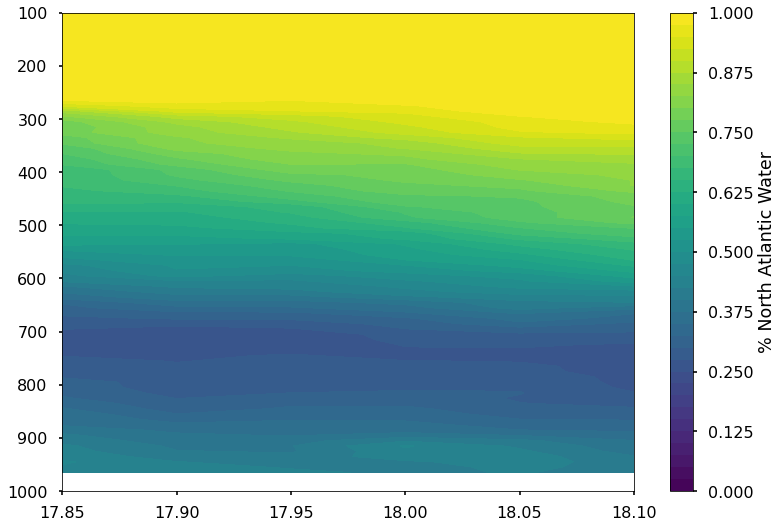

In [162]:
plt.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.naw_frac,axis=2),levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% North Atlantic Water')

/tmp/ipykernel_243104/3786683008.py:1: RuntimeWarning: Mean of empty slice
  plt.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.saw_frac,axis=2),levels=np.arange(0,1.01,0.025))


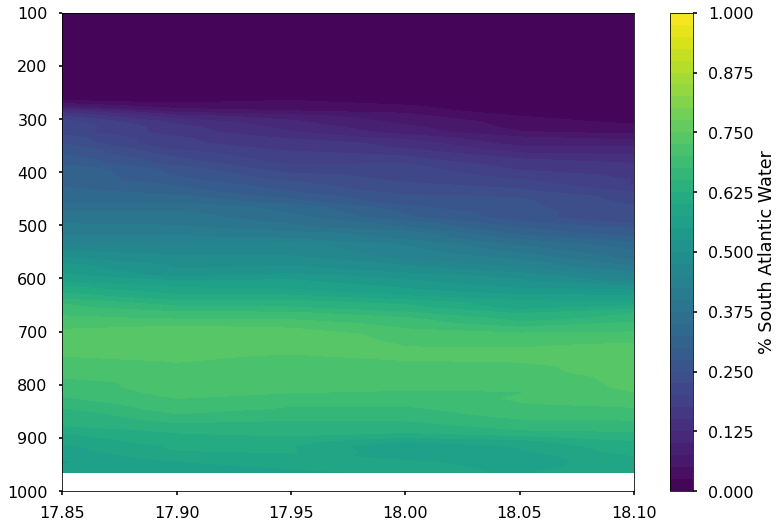

In [163]:
plt.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.saw_frac,axis=2),levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% South Atlantic Water')


## 2022

In [164]:
np.nansum(np.nanmean(df_2022_final.naw_transport,axis=2))

/tmp/ipykernel_243104/1887041703.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2022_final.naw_transport,axis=2))


-1.8149600137809143

In [165]:
np.nansum(np.nanmean(df_2022_final.saw_transport,axis=2))

/tmp/ipykernel_243104/234371692.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2022_final.saw_transport,axis=2))


-0.5448515846510915

In [166]:
np.nansum(np.nanmean(df_2022_final.transport,axis=2))

/tmp/ipykernel_243104/3663723316.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2022_final.transport,axis=2))


-2.359811598432006

In [167]:
np.nansum(np.nanmean(df_2022_final.naw_transport,axis=2))/np.nansum(np.nanmean(df_2022_final.transport,axis=2))

/tmp/ipykernel_243104/3135396668.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2022_final.naw_transport,axis=2))/np.nansum(np.nanmean(df_2022_final.transport,axis=2))


0.7691122524301847

In [168]:
np.nansum(np.nanmean(df_2022_final.saw_transport,axis=2))/np.nansum(np.nanmean(df_2022_final.transport,axis=2))

/tmp/ipykernel_243104/1106390318.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2022_final.saw_transport,axis=2))/np.nansum(np.nanmean(df_2022_final.transport,axis=2))


0.2308877475698154

### just surface layer

In [169]:
np.nansum(np.nanmean(subset_ds_2022_surf_final.transport,axis=2))

/tmp/ipykernel_243104/602237023.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(subset_ds_2022_surf_final.transport,axis=2))


-0.5631415926322594

In [170]:
0.4999255952042789/2.47

0.20239902639849347

## total SAW

In [171]:
np.nansum(np.nanmean(df_2022_final.saw_transport,axis=2))+np.nansum(np.nanmean(subset_ds_2022_surf_final.transport,axis=2))

/tmp/ipykernel_243104/29435408.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2022_final.saw_transport,axis=2))+np.nansum(np.nanmean(subset_ds_2022_surf_final.transport,axis=2))


-1.107993177283351

/tmp/ipykernel_243104/3390171382.py:1: RuntimeWarning: Mean of empty slice
  plt.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.naw_frac,axis=2),levels=np.arange(0,1.01,0.025))


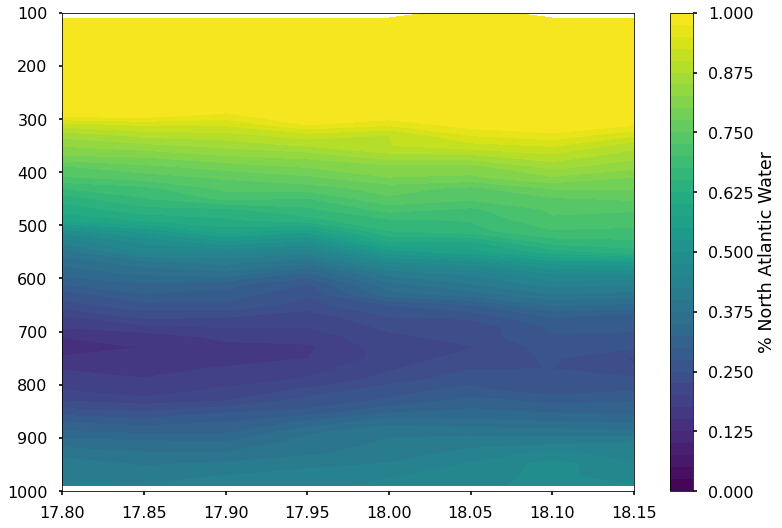

In [172]:
plt.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.naw_frac,axis=2),levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% North Atlantic Water')

/tmp/ipykernel_243104/3022784031.py:1: RuntimeWarning: Mean of empty slice
  plt.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.saw_frac,axis=2),levels=np.arange(0,1.01,0.025))


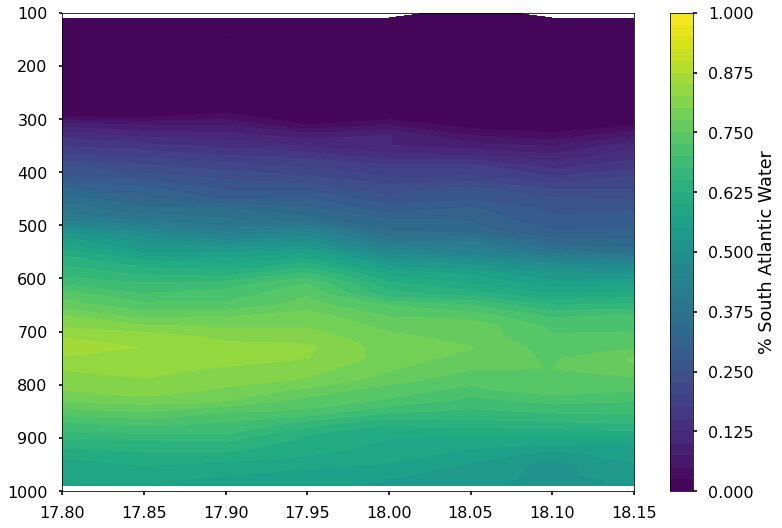

In [173]:
plt.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.saw_frac,axis=2),levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% South Atlantic Water')


## WOOHOO WE DID IT

/tmp/ipykernel_243104/2113083299.py:14: RuntimeWarning: Mean of empty slice
  first = ax1.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.saw_frac,axis=2),levels=levels)
/tmp/ipykernel_243104/2113083299.py:25: RuntimeWarning: Mean of empty slice
  second = ax2.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.saw_frac,axis=2),levels=levels)


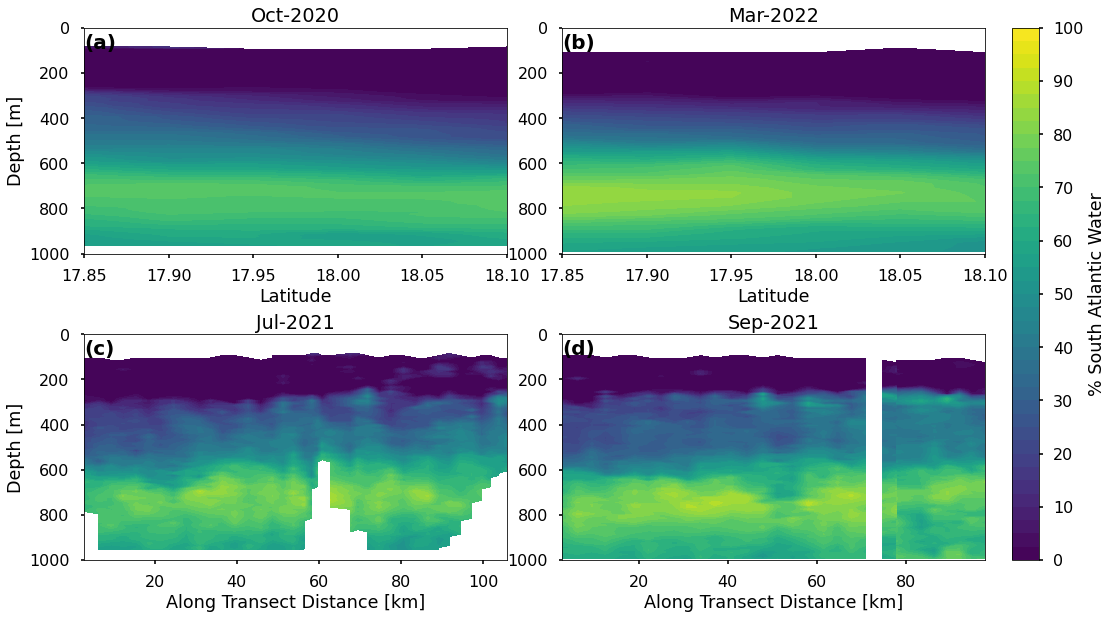

In [174]:
font_size = 20

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(16,8))


plt.tight_layout(pad=0.4, w_pad=1.5, h_pad=4.5)


axlist = [ax1,ax2,ax3,ax4]

levels=np.arange(0,1.01,0.025)


first = ax1.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.saw_frac,axis=2),levels=levels)
ax1.patch.set_facecolor('white')
ax1.set_title('Oct-2020')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Depth [m]')
#ax1.set_ylim(960,120)
ax1.set_ylim(1000,0)
ax1.set_xlim(17.85,18.10)
ax1.text(0,0.91,'(a)', transform=ax1.transAxes, size=font_size, weight='bold')


second = ax2.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.saw_frac,axis=2),levels=levels)
ax2.patch.set_facecolor('white')
ax2.set_title('Mar-2022')
ax2.set_xlabel('Latitude')
ax2.set_ylim(1000,0)
ax2.set_xlim(17.85,18.10)
ax2.text(0,0.91,'(b)', transform=ax2.transAxes, size=font_size, weight='bold')

third = ax3.contourf(np.cumsum(df_2021a_final.dist)/1000,df_2021a_final.depth,df_2021a_final.saw_frac,levels=levels)
ax3.patch.set_facecolor('white')
ax3.set_title('Jul-2021')
ax3.set_xlabel('Along Transect Distance [km]')
ax3.set_ylabel('Depth [m]')
ax3.set_ylim(1000,0)
ax3.text(0,0.91,'(c)', transform=ax3.transAxes, size=font_size, weight='bold')

fourth = ax4.contourf(np.cumsum(df_2021b_final.dist)/1000,df_2021b_final.depth,df_2021b_final.saw_frac,levels=levels)
ax4.patch.set_facecolor('white')
ax4.set_title('Sep-2021')
ax4.set_xlabel('Along Transect Distance [km]')
ax4.set_ylim(1000,0)
ax4.text(0,0.91,'(d)', transform=ax4.transAxes, size=font_size, weight='bold')

cbar = fig.colorbar(first, ax=axlist,label='% South Atlantic Water',pad=0.025)
cbar.get_ticks()
cbar.set_ticks([0,.10,.20,.30,.40,.50,.60,.70,.80,.90,1])
cbar.set_ticklabels([0,10,20,30,40,50,60,70,80,90,100])

plt.savefig('/home/jg1200/Figures/Percent_SAW_All.png',dpi=300,facecolor='white',bbox_inches='tight')


/tmp/ipykernel_243104/3625309070.py:14: RuntimeWarning: Mean of empty slice
  first = ax1.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.naw_frac,axis=2),levels=levels)
/tmp/ipykernel_243104/3625309070.py:24: RuntimeWarning: Mean of empty slice
  second = ax2.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.naw_frac,axis=2),levels=levels)


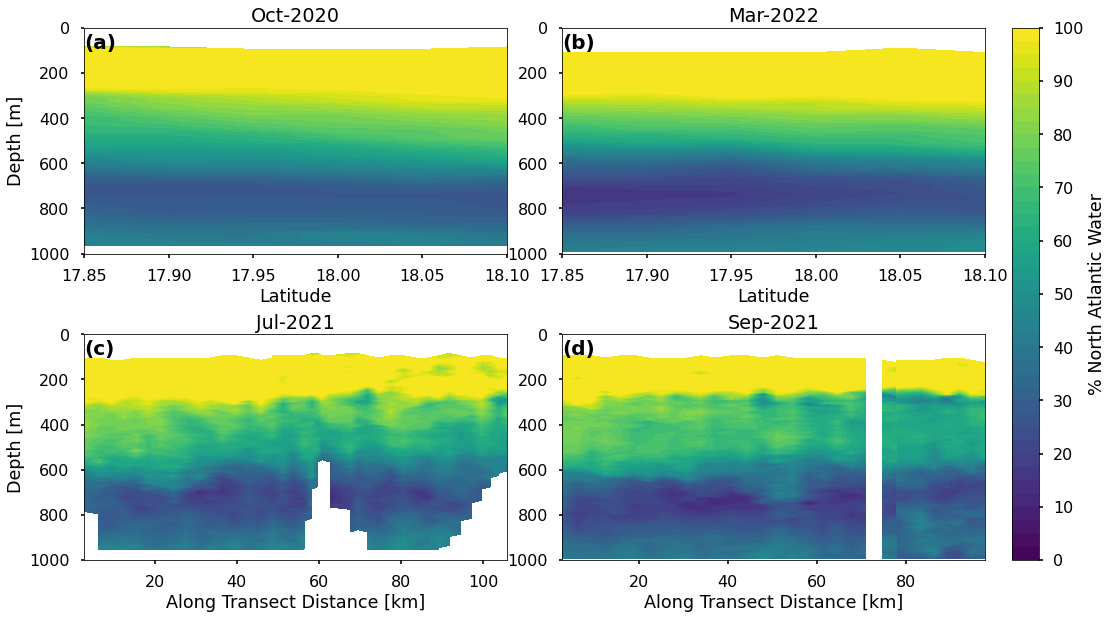

In [175]:
font_size = 20

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(16,8))


plt.tight_layout(pad=0.4, w_pad=1.5, h_pad=4.5)


axlist = [ax1,ax2,ax3,ax4]

levels=np.arange(0,1.01,0.025)


first = ax1.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.naw_frac,axis=2),levels=levels)
ax1.patch.set_facecolor('white')
ax1.set_title('Oct-2020')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Depth [m]')
ax1.set_ylim(1000,0)
ax1.set_xlim(17.85,18.10)
ax1.text(0,0.91,'(a)', transform=ax1.transAxes, size=font_size, weight='bold')


second = ax2.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.naw_frac,axis=2),levels=levels)
ax2.patch.set_facecolor('white')
ax2.set_title('Mar-2022')
ax2.set_xlabel('Latitude')
ax2.set_ylim(1000,0)
ax2.set_xlim(17.85,18.10)
ax2.text(0,0.91,'(b)', transform=ax2.transAxes, size=font_size, weight='bold')

third = ax3.contourf(np.cumsum(df_2021a_final.dist)/1000,df_2021a_final.depth,df_2021a_final.naw_frac,levels=levels)
ax3.patch.set_facecolor('white')
ax3.set_title('Jul-2021')
ax3.set_xlabel('Along Transect Distance [km]')
ax3.set_ylabel('Depth [m]')
ax3.set_ylim(1000,0)
ax3.text(0,0.91,'(c)', transform=ax3.transAxes, size=font_size, weight='bold')

fourth = ax4.contourf(np.cumsum(df_2021b_final.dist)/1000,df_2021b_final.depth,df_2021b_final.naw_frac,levels=levels)
ax4.patch.set_facecolor('white')
ax4.set_title('Sep-2021')
ax4.set_xlabel('Along Transect Distance [km]')
ax4.set_ylim(1000,0)
ax4.text(0,0.91,'(d)', transform=ax4.transAxes, size=font_size, weight='bold')

cbar = fig.colorbar(first, ax=axlist,label='% North Atlantic Water',pad=0.025)
cbar.get_ticks()
cbar.set_ticks([0,.10,.20,.30,.40,.50,.60,.70,.80,.90,1])
cbar.set_ticklabels([0,10,20,30,40,50,60,70,80,90,100])

plt.savefig('/home/jg1200/Figures/Percent_NAW_All.png',dpi=300,facecolor='white',bbox_inches='tight')


In [176]:
np.nansum(subset_ds_2022_surf_final.transport)

-2.5111354792202194

## more plots

In [177]:
def calc_transport_by_water_mass_multiple(dft,surf_dft):
    
    smw_naw = np.nansum(np.nanmean(dft.naw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1024.5) & (np.nanmean(dft.density,axis=2)<1026.3))])
    smw_saw = np.nansum(np.nanmean(dft.saw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1024.5) & (np.nanmean(dft.density,axis=2)<1026.3))])

    ucw_naw = np.nansum(np.nanmean(dft.naw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1026.3) & (np.nanmean(dft.density,axis=2)<1026.8))])
    ucw_saw = np.nansum(np.nanmean(dft.saw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1026.3) & (np.nanmean(dft.density,axis=2)<1026.8))])

    lcw_naw = np.nansum(np.nanmean(dft.naw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1026.8) & (np.nanmean(dft.density,axis=2)<1027.1))])
    lcw_saw = np.nansum(np.nanmean(dft.saw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1026.8) & (np.nanmean(dft.density,axis=2)<1027.1))])

    iw_naw = np.nansum(np.nanmean(dft.naw_transport.values,axis=2)[np.where(np.nanmean(dft.density,axis=2)>=1027.1)])
    iw_saw = np.nansum(np.nanmean(dft.saw_transport.values,axis=2)[np.where(np.nanmean(dft.density,axis=2)>=1027.1)])

    d = {'SA': [iw_saw, lcw_saw, ucw_saw, smw_saw,np.nansum(np.nanmean(surf_dft.transport,axis=2))],'NA': [iw_naw, lcw_naw, ucw_naw, smw_naw,np.nan] }
    df2 = pd.DataFrame(data=d, index=['IW', 'lCW', 'uCW', 'SMW','SW'])

    return(df2)

def calc_transport_by_water_mass_single(dft,surf_dft):
    smw_naw = np.nansum(dft.naw_transport.values[np.where((dft.density>=1024.5) & (dft.density<1026.3))])
    smw_saw = np.nansum(dft.saw_transport.values[np.where((dft.density>=1024.5) & (dft.density<1026.3))])

    ucw_naw = np.nansum(dft.naw_transport.values[np.where((dft.density>=1026.3) & (dft.density<1026.8))])
    ucw_saw = np.nansum(dft.saw_transport.values[np.where((dft.density>=1026.3) & (dft.density<1026.8))])

    lcw_naw = np.nansum(dft.naw_transport.values[np.where((dft.density>=1026.8) & (dft.density<1027.1))])
    lcw_saw = np.nansum(dft.saw_transport.values[np.where((dft.density>=1026.8) & (dft.density<1027.1))])

    iw_naw = np.nansum(dft.naw_transport.values[np.where(dft.density>=1027.1)])
    iw_saw = np.nansum(dft.saw_transport.values[np.where(dft.density>=1027.1)])

    d = {'SA': [iw_saw, lcw_saw, ucw_saw, smw_saw,np.nansum(surf_dft.transport)],'NA': [iw_naw, lcw_naw, ucw_naw, smw_naw,np.nan] }
    df2 = pd.DataFrame(data=d, index=['IW', 'lCW', 'uCW', 'SMW','SW'])

    return(df2)

df_2020_water_mass_transport = calc_transport_by_water_mass_multiple(df_2020_final,subset_ds_2020_surf_final)
df_2021a_water_mass_transport = calc_transport_by_water_mass_single(df_2021a_final,subset_ds_2021a_surf_final)
df_2021b_water_mass_transport = calc_transport_by_water_mass_single(df_2021b_final,subset_ds_2021b_surf_final)
df_2022_water_mass_transport = calc_transport_by_water_mass_multiple(df_2022_final,subset_ds_2022_surf_final)

/tmp/ipykernel_243104/2131768640.py:3: RuntimeWarning: Mean of empty slice
  smw_naw = np.nansum(np.nanmean(dft.naw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1024.5) & (np.nanmean(dft.density,axis=2)<1026.3))])
/tmp/ipykernel_243104/2131768640.py:4: RuntimeWarning: Mean of empty slice
  smw_saw = np.nansum(np.nanmean(dft.saw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1024.5) & (np.nanmean(dft.density,axis=2)<1026.3))])
/tmp/ipykernel_243104/2131768640.py:6: RuntimeWarning: Mean of empty slice
  ucw_naw = np.nansum(np.nanmean(dft.naw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1026.3) & (np.nanmean(dft.density,axis=2)<1026.8))])
/tmp/ipykernel_243104/2131768640.py:7: RuntimeWarning: Mean of empty slice
  ucw_saw = np.nansum(np.nanmean(dft.saw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1026.3) & (np.nanmean(dft.density,axis=2)<1026.8))])
/tmp/ipykernel_243104/2131768640.py:9: RuntimeWarning: M

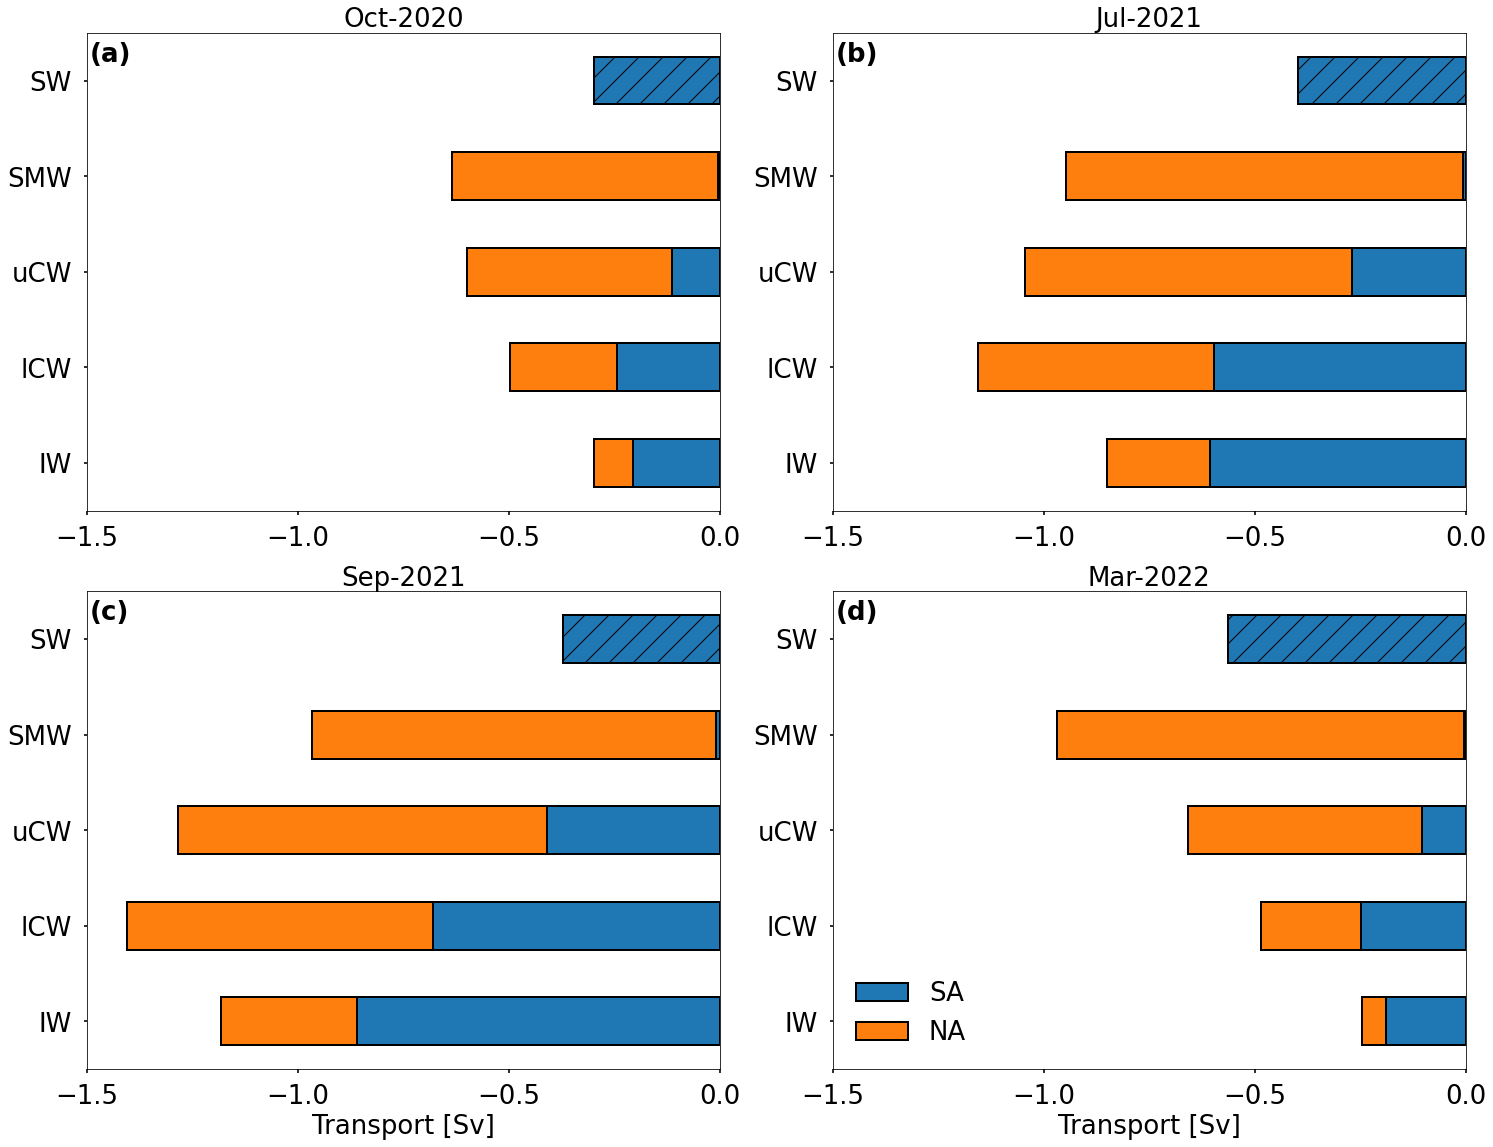

In [178]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

plt.tight_layout(pad=0.4, w_pad=6, h_pad=4.5)

font_size = 26

df_2020_water_mass_transport.plot.barh(stacked=True,ax=axs[0,0],color=['tab:blue','tab:orange'], edgecolor='black', linewidth=2)
axs[0,0].set_title('Oct-2020',fontsize=font_size)
axs[0,0].set_xlim(-1.5,0)
axs[0,0].set_xticks([-1.5,-1,-0.5,0])
axs[0,0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0,0].text(0.005,0.94,'(a)', transform=axs[0,0].transAxes, size=font_size, weight='bold')
axs[0,0].get_legend().remove()

df_2021a_water_mass_transport.plot.barh(stacked=True,ax=axs[0,1],color=['tab:blue','tab:orange'], edgecolor='black', linewidth=2)
axs[0,1].set_title('Jul-2021',fontsize=font_size)
axs[0,1].set_xlim(-1.5,0)
axs[0,1].set_xticks([-1.5,-1,-0.5,0])
axs[0,1].tick_params(axis='both', which='major', labelsize=font_size)
axs[0,1].text(0.005,0.94,'(b)', transform=axs[0,1].transAxes, size=font_size, weight='bold')
axs[0,1].get_legend().remove()

df_2021b_water_mass_transport.plot.barh(stacked=True,ax=axs[1,0],color=['tab:blue','tab:orange'], edgecolor='black', linewidth=2)
axs[1,0].set_title('Sep-2021',fontsize=font_size)
axs[1,0].set_xlim(-1.5,0)
axs[1,0].set_xticks([-1.5,-1,-0.5,0])
axs[1,0].tick_params(axis='both', which='major', labelsize=font_size)
axs[1,0].text(0.005,0.94,'(c)', transform=axs[1,0].transAxes, size=font_size, weight='bold')
axs[1,0].get_legend().remove()
axs[1,0].set_xlabel('Transport [Sv]',fontsize=font_size)

df_2022_water_mass_transport.plot.barh(stacked=True,ax=axs[1,1],color=['tab:blue','tab:orange'], edgecolor='black', linewidth=2)
axs[1,1].set_title('Mar-2022',fontsize=font_size)
axs[1,1].set_xlim(-1.5,0)
axs[1,1].set_xticks([-1.5,-1,-0.5,0])
axs[1,1].tick_params(axis='both', which='major', labelsize=font_size)
axs[1,1].text(0.005,0.94,'(d)', transform=axs[1,1].transAxes, size=font_size, weight='bold')
axs[1,1].legend(fontsize=font_size,markerscale=6,frameon=False,loc='lower left')
axs[1,1].set_xlabel('Transport [Sv]',fontsize=font_size)


hatches = ['','','','','/','','','','','']

for x in np.arange(0,len(axs)):    
    for y in np.arange(0,len(axs)):
        bars = axs[x,y].patches
        for bar, hatch in zip(bars, hatches):
            bar.set_hatch(hatch)

plt.savefig('/home/jg1200/Figures/Anegada_SAW_NAW_Transport_Water_Masses_Bar_Plot.png', bbox_inches='tight',dpi=300,facecolor='white')



In [179]:
df_2020_water_mass_transport

SA        NA
IW  -0.206017 -0.091558
lCW -0.243949 -0.252986
uCW -0.113125 -0.484847
SMW -0.004693 -0.630477
SW  -0.298785       NaN

In [180]:
df_2021a_water_mass_transport

SA        NA
IW  -0.607274 -0.242473
lCW -0.596382 -0.559571
uCW -0.269685 -0.775151
SMW -0.006613 -0.941016
SW  -0.397130       NaN

In [181]:
df_2021b_water_mass_transport

SA        NA
IW  -0.860452 -0.321303
lCW -0.679194 -0.725186
uCW -0.408874 -0.873914
SMW -0.008669 -0.958697
SW  -0.372718       NaN

In [182]:
df_2022_water_mass_transport

SA        NA
IW  -0.188605 -0.058147
lCW -0.248493 -0.236302
uCW -0.104322 -0.554504
SMW -0.003431 -0.966008
SW  -0.563142       NaN

## Percentage of SAW vs NAW in each water mass

In [183]:

tempdf = df_2020_water_mass_transport

for ind in np.arange(0,len(tempdf)):

    tot = tempdf.iloc[ind].SA+tempdf.iloc[ind].NA
    per_SA = (tempdf.iloc[ind].SA/tot)*100
    per_NA = (tempdf.iloc[ind].NA/tot)*100
    water_mass_name = tempdf.iloc[ind].name

    print(water_mass_name,'% SA:',per_SA,'%  (',tempdf.iloc[ind].SA,'Sv)')
    print(water_mass_name,'% NA:',per_NA,'%  (',tempdf.iloc[ind].NA,'Sv)')
   

IW % SA: 69.23203019424689 %  ( -0.20601698683024203 Sv)
IW % NA: 30.767969805753122 %  ( -0.09155768525753658 Sv)
lCW % SA: 49.09076391478382 %  ( -0.24394902892772943 Sv)
lCW % NA: 50.90923608521618 %  ( -0.25298564772794085 Sv)
uCW % SA: 18.918146698642975 %  ( -0.11312523096945515 Sv)
uCW % NA: 81.08185330135701 %  ( -0.4848468260797154 Sv)
SMW % SA: 0.7389231291128188 %  ( -0.004693418161143484 Sv)
SMW % NA: 99.2610768708872 %  ( -0.6304765983436307 Sv)
SW % SA: nan %  ( -0.298785189634609 Sv)
SW % NA: nan %  ( nan Sv)


In [184]:

tempdf = df_2021a_water_mass_transport

for ind in np.arange(0,len(tempdf)):

    tot = tempdf.iloc[ind].SA+tempdf.iloc[ind].NA
    per_SA = (tempdf.iloc[ind].SA/tot)*100
    per_NA = (tempdf.iloc[ind].NA/tot)*100
    water_mass_name = tempdf.iloc[ind].name

    print(water_mass_name,'% SA:',per_SA,'%  (',tempdf.iloc[ind].SA,'Sv)')
    print(water_mass_name,'% NA:',per_NA,'%  (',tempdf.iloc[ind].NA,'Sv)')
    

IW % SA: 71.46526878165473 %  ( -0.6072742651132931 Sv)
IW % NA: 28.534731218345264 %  ( -0.24247313731889575 Sv)
lCW % SA: 51.59223364664257 %  ( -0.5963815333289317 Sv)
lCW % NA: 48.40776635335744 %  ( -0.5595706152319827 Sv)
uCW % SA: 25.811213930575605 %  ( -0.2696847400845278 Sv)
uCW % NA: 74.18878606942441 %  ( -0.7751508139885916 Sv)
SMW % SA: 0.6978328196094886 %  ( -0.006612862179582372 Sv)
SMW % NA: 99.30216718039051 %  ( -0.9410155659707258 Sv)
SW % SA: nan %  ( -0.39712977082793577 Sv)
SW % NA: nan %  ( nan Sv)


In [185]:

tempdf = df_2021b_water_mass_transport

for ind in np.arange(0,len(tempdf)):

    tot = tempdf.iloc[ind].SA+tempdf.iloc[ind].NA
    per_SA = (tempdf.iloc[ind].SA/tot)*100
    per_NA = (tempdf.iloc[ind].NA/tot)*100
    water_mass_name = tempdf.iloc[ind].name

    print(water_mass_name,'% SA:',per_SA,'%  (',tempdf.iloc[ind].SA,'Sv)')
    print(water_mass_name,'% NA:',per_NA,'%  (',tempdf.iloc[ind].NA,'Sv)')
    

IW % SA: 72.81136218881532 %  ( -0.8604517989842706 Sv)
IW % NA: 27.188637811184673 %  ( -0.32130304410318095 Sv)
lCW % SA: 48.36255263595931 %  ( -0.6791943662323886 Sv)
lCW % NA: 51.63744736404068 %  ( -0.7251863564827787 Sv)
uCW % SA: 31.873827448396565 %  ( -0.4088735089535692 Sv)
uCW % NA: 68.12617255160345 %  ( -0.8739140998315122 Sv)
SMW % SA: 0.8961250497388532 %  ( -0.008668805558037467 Sv)
SMW % NA: 99.10387495026114 %  ( -0.9586968049182807 Sv)
SW % SA: nan %  ( -0.37271834259548375 Sv)
SW % NA: nan %  ( nan Sv)


In [186]:

tempdf = df_2022_water_mass_transport

for ind in np.arange(0,len(tempdf)):

    tot = tempdf.iloc[ind].SA+tempdf.iloc[ind].NA
    per_SA = (tempdf.iloc[ind].SA/tot)*100
    per_NA = (tempdf.iloc[ind].NA/tot)*100
    water_mass_name = tempdf.iloc[ind].name

    print(water_mass_name,'% SA:',per_SA,'%  (',tempdf.iloc[ind].SA,'Sv)')
    print(water_mass_name,'% NA:',per_NA,'%  (',tempdf.iloc[ind].NA,'Sv)')
    

IW % SA: 76.43520536552843 %  ( -0.18860508423898098 Sv)
IW % NA: 23.564794634471557 %  ( -0.05814650534206841 Sv)
lCW % SA: 51.25731933342733 %  ( -0.24849308402607279 Sv)
lCW % NA: 48.74268066657266 %  ( -0.23630223351605753 Sv)
uCW % SA: 15.834583608328407 %  ( -0.10432233729679594 Sv)
uCW % NA: 84.16541639167158 %  ( -0.5545035584591634 Sv)
SMW % SA: 0.3539242606115217 %  ( -0.003431079089241725 Sv)
SMW % NA: 99.64607573938848 %  ( -0.966007716463625 Sv)
SW % SA: nan %  ( -0.5631415926322594 Sv)
SW % NA: nan %  ( nan Sv)
